#### MOVIE RATING PREDICTION WITH PYTHON

#### MOVIE RATING PREDICTION WITH PYTHON
- Build a model that predicts the rating of a movie based on features like genre, director, and actors. You can use regression techniques to tackle this problem.
- The goal is to analyze historical movie data and develop a model that accurately estimates the rating given to a movie by users or critics.
- Movie Rating Prediction project enables you to explore data analysis, preprocessing, feature engineering, and machine learning modeling techniques. It provides insights into the factors that influence movie ratings and allows you to build a model that can estimate the ratings of movies accurately.



#### Import Required Libraries

In [8]:
!pip install category_encoders


   ---------------------------------------- 0.0/82.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/82.0 kB ? eta -:--:--
   -------------- ------------------------- 30.7/82.0 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------  81.9/82.0 kB 657.6 kB/s eta 0:00:01
   ---------------------------------------- 82.0/82.0 kB 574.1 kB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import lightgbm as lgb
import os
import pickle
import seaborn as sns
import statsmodels.api as sm
import statsmodels.regression.linear_model as smf
import timeit
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from numba import jit, cuda
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline
# !pip install dtale
!pip install category encoders

#### READ DATA FROM CSV 

In [16]:
# Reading the dataset into a data frame
# Getting error as ''utf-8' codec can't decode byte 0xe1 in position 76763: invalid continuation byte'
# So using 'encoding = 'latin-1'
# Load the CSV file with the specified encoding
movies_df = pd.read_csv("E:\\onedrive world\\OneDrive\\Desktop\\INTERNSHIP'S\\Cod_Soft INTERNSHIP\\Project-MOVIE RATING PREDICTION WITH PYTHON\\IMDb Movies India.csv", encoding='latin-1')
movies_df.head()

Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  
3  Siddhant Kapoor  
4      Antara Mali

In [18]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [20]:
movies_df.describe()

Rating
count  7919.000000
mean      5.841621
std       1.381777
min       1.100000
25%       4.900000
50%       6.000000
75%       6.800000
max      10.000000

#### Finding duplicate rows

In [22]:
movies_df.duplicated().sum()

6

- Only one column is of float datatype, all the other columns are of object datatype.
- We see a lot of missing values in the target column.
- Creating a new training data frame where there are missing values in the target column
- We see there are 6 duplicate rows in our dtaset

#### Train and test (validation) split


In [25]:
# Spliting the data based on target column
# If the target column is nan or null then it will go into the test df

rest_df, test_df = [x for y, x in movies_df.groupby(movies_df['Rating'].isna())]

In [27]:
test_df.head()

Name    Year Duration           Genre  Rating Votes  \
0                         NaN      NaN           Drama     NaN   NaN   
2         #Homecoming  (2021)   90 min  Drama, Musical     NaN   NaN   
4   ...And Once Again  (2010)  105 min           Drama     NaN   NaN   
7      .in for Motion  (2008)   59 min     Documentary     NaN   NaN   
14         101 Ratein  (1990)      NaN        Thriller     NaN   NaN   

              Director       Actor 1             Actor 2          Actor 3  
0        J.S. Randhawa      Manmauji              Birbal  Rajendra Bhatia  
2   Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur       Roy Angana  
4         Amol Palekar  Rajat Kapoor  Rituparna Sengupta      Antara Mali  
7        Anirban Datta           NaN                 NaN              NaN  
14              Harish     Saraswati        Disco Shanti              NaN

In [29]:
rest_df.head()

Name    Year Duration  \
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min   
3                             #Yaaram  (2019)  110 min   
5                ...Aur Pyaar Ho Gaya  (1997)  147 min   
6                           ...Yahaan  (2005)  142 min   
8                  ?: A Question Mark  (2012)   82 min   

                       Genre  Rating  Votes        Director          Actor 1  \
1                      Drama     7.0      8   Gaurav Bakshi     Rasika Dugal   
3            Comedy, Romance     4.4     35      Ovais Khan          Prateik   
5     Comedy, Drama, Musical     4.7    827    Rahul Rawail       Bobby Deol   
6        Drama, Romance, War     7.4  1,086  Shoojit Sircar  Jimmy Sheirgill   
8  Horror, Mystery, Thriller     5.6    326   Allyson Patel        Yash Dave   

                  Actor 2          Actor 3  
1          Vivek Ghamande    Arvind Jangid  
3              Ishita Raj  Siddhant Kapoor  
5  Aishwarya Rai Bachchan    Shammi Kapoor  
6          Minissha Lamba   Yashpal Sharma  
8          Muntazir Ahmad     Kiran Bhatia

#### Train test (validation) split

In [35]:
train_df, validation_df = train_test_split(rest_df, train_size = 0.75, random_state = 101)
train_df.head(5)

Name    Year Duration                   Genre  Rating  \
11500                Rahi  (1953)  139 min                   Drama     7.0   
5167                Gooli  (2008)  138 min  Action, Drama, Romance     6.4   
4825   Galiyon Ka Badshah  (1989)      NaN    Drama, Action, Crime     4.9   
3597       Delhi in a Day  (2011)   88 min           Comedy, Drama     6.2   
15080                 WOH  (2004)      NaN  Crime, Drama, Thriller     4.4   

      Votes            Director               Actor 1             Actor 2  \
11500    28  Khwaja Ahmad Abbas             Dev Anand      Nalini Jaywant   
5167     80            P. Satya                Sudeep      Mamta Mohandas   
4825     29     Sher Jung Singh               K. Yogi          Raaj Kumar   
3597    395       Prashant Nair       Victor Banerjee  Siddharth Bhardwaj   
15080    40        Raj N. Sippy  Priyanshu Chatterjee      Sumeet Goradia   

                Actor 3  
11500      Balraj Sahni  
5167   Kishore Kumar G.  
4825        Hema Malini  
3597      Vidya Bhushan  
15080       Cleo Isaacs

In [37]:
validation_df.head(5)

Name    Year Duration            Genre  Rating  \
12679  Seeking Happily Ever After  (2018)  104 min   Drama, Romance     6.8   
12294                       Samar  (1998)  126 min            Drama     7.5   
6739                    Jigariyaa  (2014)  142 min            Drama     4.9   
348                 Aakhri Insaaf  (1980)      NaN  Action, Mystery     4.9   
5439                  Hamari Baat  (1943)      NaN              NaN     8.2   

       Votes        Director              Actor 1            Actor 2  \
12679  1,117     Harish Vyas  Shivani Raghuvanshi       Anshuman Jha   
12294     31   Shyam Benegal   Rajeshwari Sachdev       Rajit Kapoor   
6739     301     Raj Purohit     Harshvardhan Deo      Cherry Mardia   
348       10         Kalidas   Mithun Chakraborty  Vijayendra Ghatge   
5439       9  M.I. Dharamsey          Devika Rani            Suraiya   

              Actor 3  
12679  Ekavali Khanna  
12294    Ravi Jhankal  
6739   Deepak Chaddha  
348       Ashok Kumar  
5439    David Abraham

In [62]:
# Checking for duplicate rows
train_df.duplicated().sum()

0

In [64]:
validation_df.duplicated().sum()

0

In [66]:
test_df.duplicated().sum()

0

We see that all the duplicate values are in test dataframe, proceeding to remove the duplicates.

In [69]:
test_df[movies_df.duplicated(keep = False)]

Name    Year Duration     Genre  Rating Votes  \
1249   Arab Ka Sona - Abu Kaalia  (1979)      NaN    Action     NaN   NaN   
1768                     Balidan  (1992)      NaN     Drama     NaN   NaN   
4722     First Time - Pehli Baar  (2009)      NaN       NaN     NaN   NaN   
9712                     Musafir     NaN      NaN  Thriller     NaN   NaN   
13068                    Shivani  (2019)      NaN     Crime     NaN   NaN   
13307          Slumdog Karodpati  (2019)  118 min  Thriller     NaN   NaN   

                  Director      Actor 1       Actor 2     Actor 3  
1249        Master Bhagwan    Meena Rai    Dara Singh         NaN  
1768                   NaN          NaN           NaN         NaN  
4722          Raja Bundela  Zeenat Aman   Nitin Arora  Raj Babbar  
9712           Shiva Dagar          NaN           NaN         NaN  
13068  Ugresh Prasad Ujala      Santosh           NaN         NaN  
13307        Rajesh Patole  Udhav Garje  Rahul Gavane   Govindrao

In [71]:
# Removing the duplicate values

test_df.drop_duplicates(inplace = True)
test_df.duplicated().sum()

0

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5939 entries, 11500 to 9574
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5939 non-null   object 
 1   Year      5939 non-null   object 
 2   Duration  4393 non-null   object 
 3   Genre     5860 non-null   object 
 4   Rating    5939 non-null   float64
 5   Votes     5939 non-null   object 
 6   Director  5935 non-null   object 
 7   Actor 1   5837 non-null   object 
 8   Actor 2   5783 non-null   object 
 9   Actor 3   5713 non-null   object 
dtypes: float64(1), object(9)
memory usage: 510.4+ KB


In [75]:
train_df.describe()

Rating
count  5939.000000
mean      5.859118
std       1.384323
min       1.100000
25%       4.900000
50%       6.000000
75%       6.900000
max       9.700000

In [77]:
train_df.describe(include = 'all')

Name    Year Duration  Genre       Rating Votes      Director  \
count     5939    5939     4393   5860  5939.000000  5939          5935   
unique    5612      92      172    380          NaN  1643          2623   
top     Sanjog  (2019)  120 min  Drama          NaN     7  Mahesh Bhatt   
freq         4     192      132    910          NaN   171            39   
mean       NaN     NaN      NaN    NaN     5.859118   NaN           NaN   
std        NaN     NaN      NaN    NaN     1.384323   NaN           NaN   
min        NaN     NaN      NaN    NaN     1.100000   NaN           NaN   
25%        NaN     NaN      NaN    NaN     4.900000   NaN           NaN   
50%        NaN     NaN      NaN    NaN     6.000000   NaN           NaN   
75%        NaN     NaN      NaN    NaN     6.900000   NaN           NaN   
max        NaN     NaN      NaN    NaN     9.700000   NaN           NaN   

           Actor 1 Actor 2 Actor 3  
count         5837    5783    5713  
unique        2103    2385    2566  
top     Dharmendra   Rekha    Pran  
freq           106      54      57  
mean           NaN     NaN     NaN  
std            NaN     NaN     NaN  
min            NaN     NaN     NaN  
25%            NaN     NaN     NaN  
50%            NaN     NaN     NaN  
75%            NaN     NaN     NaN  
max            NaN     NaN     NaN

In [79]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980 entries, 12679 to 2263
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1980 non-null   object 
 1   Year      1980 non-null   object 
 2   Duration  1458 non-null   object 
 3   Genre     1957 non-null   object 
 4   Rating    1980 non-null   float64
 5   Votes     1980 non-null   object 
 6   Director  1979 non-null   object 
 7   Actor 1   1957 non-null   object 
 8   Actor 2   1936 non-null   object 
 9   Actor 3   1914 non-null   object 
dtypes: float64(1), object(9)
memory usage: 170.2+ KB


In [81]:
validation_df.describe()

Rating
count  1980.000000
mean      5.789141
std       1.373123
min       1.600000
25%       4.900000
50%       5.900000
75%       6.800000
max      10.000000

In [83]:
validation_df.describe(include = 'all')

Name    Year Duration  Genre       Rating Votes  \
count     1980    1980     1458   1957  1980.000000  1980   
unique    1955      89      144    243          NaN   750   
top     Thokar  (2017)  135 min  Drama          NaN     9   
freq         3      66       43    267          NaN    65   
mean       NaN     NaN      NaN    NaN     5.789141   NaN   
std        NaN     NaN      NaN    NaN     1.373123   NaN   
min        NaN     NaN      NaN    NaN     1.600000   NaN   
25%        NaN     NaN      NaN    NaN     4.900000   NaN   
50%        NaN     NaN      NaN    NaN     5.900000   NaN   
75%        NaN     NaN      NaN    NaN     6.800000   NaN   
max        NaN     NaN      NaN    NaN    10.000000   NaN   

                    Director    Actor 1 Actor 2 Actor 3  
count                   1979       1957    1936    1914  
unique                  1188        920    1066    1114  
top     Hrishikesh Mukherjee  Jeetendra   Rekha    Pran  
freq                      14         41      25      18  
mean                     NaN        NaN     NaN     NaN  
std                      NaN        NaN     NaN     NaN  
min                      NaN        NaN     NaN     NaN  
25%                      NaN        NaN     NaN     NaN  
50%                      NaN        NaN     NaN     NaN  
75%                      NaN        NaN     NaN     NaN  
max                      NaN        NaN     NaN     NaN

In [85]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7057 non-null   object 
 2   Duration  1388 non-null   object 
 3   Genre     5810 non-null   object 
 4   Rating    0 non-null      float64
 5   Votes     1 non-null      object 
 6   Director  7065 non-null   object 
 7   Actor 1   6094 non-null   object 
 8   Actor 2   5403 non-null   object 
 9   Actor 3   4736 non-null   object 
dtypes: float64(1), object(9)
memory usage: 651.8+ KB


In [87]:
test_df.describe()

Rating
count     0.0
mean      NaN
std       NaN
min       NaN
25%       NaN
50%       NaN
75%       NaN
max       NaN

In [89]:
test_df.describe(include = 'all')

Name    Year Duration  Genre  Rating   Votes      Director  \
count    7584    7057     1388   5810     0.0       1          7065   
unique   7122     101      144    242     NaN       1          3766   
top     Mamta  (2021)  120 min  Drama     NaN  $5.16M  Jayant Desai   
freq        6     314       65   1602     NaN       1            52   
mean      NaN     NaN      NaN    NaN     NaN     NaN           NaN   
std       NaN     NaN      NaN    NaN     NaN     NaN           NaN   
min       NaN     NaN      NaN    NaN     NaN     NaN           NaN   
25%       NaN     NaN      NaN    NaN     NaN     NaN           NaN   
50%       NaN     NaN      NaN    NaN     NaN     NaN           NaN   
75%       NaN     NaN      NaN    NaN     NaN     NaN           NaN   
max       NaN     NaN      NaN    NaN     NaN     NaN           NaN   

               Actor 1 Actor 2 Actor 3  
count             6094    5403    4736  
unique            2956    2893    2603  
top     Master Bhagwan   Helen  Jeevan  
freq                61      38      34  
mean               NaN     NaN     NaN  
std                NaN     NaN     NaN  
min                NaN     NaN     NaN  
25%                NaN     NaN     NaN  
50%                NaN     NaN     NaN  
75%                NaN     NaN     NaN  
max                NaN     NaN     NaN

In [91]:
train_df.shape

(5939, 10)

In [93]:
validation_df.shape

(1980, 10)

In [95]:
test_df.shape

(7584, 10)

#### Handling missing values

In [98]:
train_missing = list(train_df.isnull().sum())
val_missing = list(validation_df.isnull().sum())
test_misisng = list(test_df.isnull().sum())

#### finding percentage of missing values in each columns 

In [101]:
train_missing_percent = list(train_df.isnull().sum() / len(train_df) * 100)
val_missing_percent = list(validation_df.isnull().sum() / len(validation_df) * 100)
test_misisng_percent = list(test_df.isnull().sum() / len(test_df) * 100)

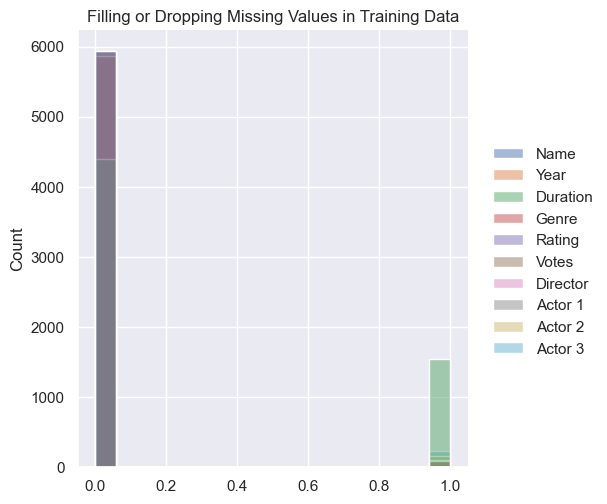

In [105]:
sns.displot(train_df.isnull())
plt.title("Filling or Dropping Missing Values in Training Data")
plt.show()

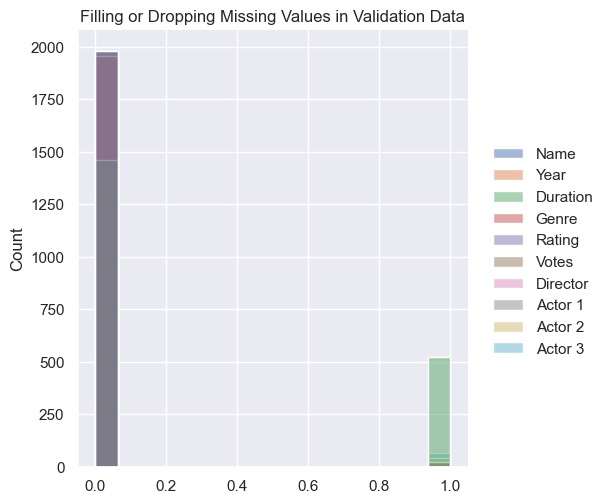

In [107]:
sns.displot(validation_df.isnull())
plt.title("Filling or Dropping Missing Values in Validation Data")
plt.show()

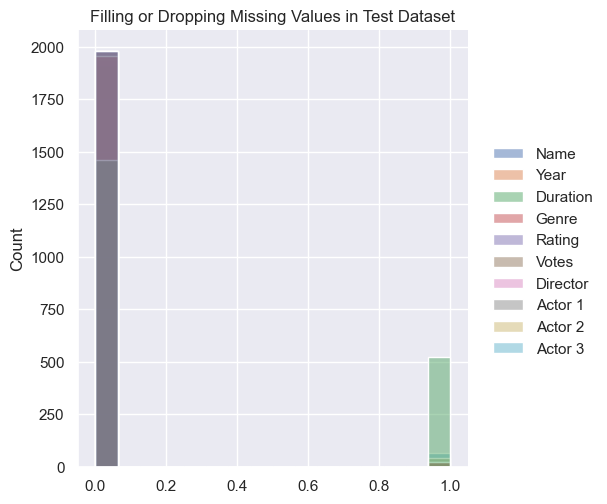

In [113]:
sns.displot(validation_df.isnull())
plt.title("Filling or Dropping Missing Values in Test Dataset")
plt.show()

#### HeatMap

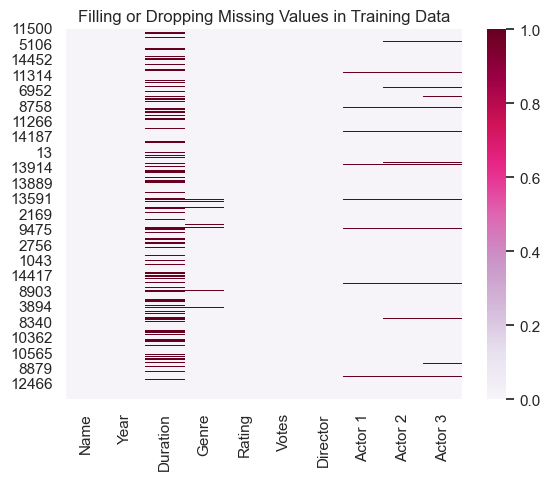

In [119]:
sns.heatmap(train_df.isnull(), cmap = 'PuRd')
plt.title("Filling or Dropping Missing Values in Training Data")
plt.show()

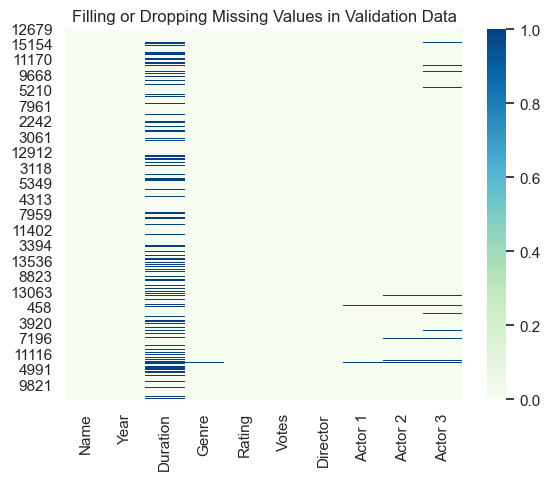

In [124]:
sns.heatmap(validation_df.isnull(), cmap = 'GnBu')
plt.title("Filling or Dropping Missing Values in Validation Data")
plt.show()

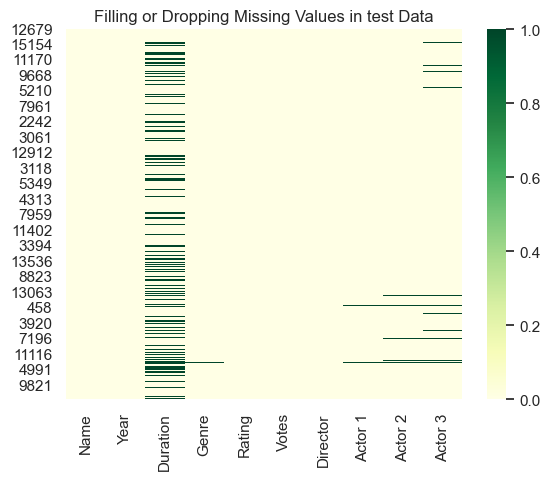

In [128]:
sns.heatmap(validation_df.isnull(), cmap = 'YlGn')
plt.title("Filling or Dropping Missing Values in test Data")
plt.show()

#### Missing values dataframe

In [161]:
missing_df = pd.DataFrame({'Columns' : list(train_df.columns), 'Train_missing' : train_missing, 'Percent_Train_missing' : train_missing_percent, 
                'Validation_missing' : val_missing, 'Percent_Val_missing' : val_missing_percent, 'Test_missing' : test_misisng, 
                           'Percent_Test_missing' : test_misisng_percent})
missing_df

Columns  Train_missing  Percent_Train_missing  Validation_missing  \
0      Name              0               0.000000                   0   
1      Year              0               0.000000                   0   
2  Duration           1546              26.031318                 522   
3     Genre             79               1.330190                  23   
4    Rating              0               0.000000                   0   
5     Votes              0               0.000000                   0   
6  Director              4               0.067351                   1   
7   Actor 1            102               1.717461                  23   
8   Actor 2            156               2.626705                  44   
9   Actor 3            226               3.805354                  66   

   Percent_Val_missing  Test_missing  Percent_Test_missing  
0             0.000000             0              0.000000  
1             0.000000           527              6.948840  
2            26.363636          6196             81.698312  
3             1.161616          1774             23.391350  
4             0.000000          7584            100.000000  
5             0.000000          7583             99.986814  
6             0.050505           519              6.843354  
7             1.161616          1490             19.646624  
8             2.222222          2181             28.757911  
9             3.333333          2848             37.552743

- We observe a similar pattern of missing data in both the training and validation dataframes.
- However, the test dataframe contains significantly more missing values.
- We can utilize the non-null values in the training and validation sets to assess the importance and impute missing values in the test dataframe accordingly.
.
."

#### Missing value treatment

- The `Year` column has no missing values in the training and validation dataframes, but there are missing values in the test dataframe.
- Filling the missing `Year` values in the test set based on values from the training set.
- Converting the `Year` column from object datatype to a numerical datatype.


In [215]:
# There are no missing values in Year column in train and validation dataframes, but there are missing year values in train dataframe
# Filing the missing year values in test set based on values of training set
# Converting the year column to a number datatype from object datatype
# Ensure all values in 'Year' column are strings before using .str accessor
train_df['Year'] = train_df['Year'].astype(str).str.extract('([0-9]+)').astype(float).astype(int)
train_df.head(5)


Name  Year  Duration                   Genre  Rating  \
11500                Rahi  1953     139.0                   Drama     7.0   
5167                Gooli  2008     138.0  Action, Drama, Romance     6.4   
4825   Galiyon Ka Badshah  1989       NaN    Drama, Action, Crime     4.9   
3597       Delhi in a Day  2011      88.0           Comedy, Drama     6.2   
15080                 WOH  2004       NaN  Crime, Drama, Thriller     4.4   

      Votes            Director               Actor 1             Actor 2  \
11500    28  Khwaja Ahmad Abbas             Dev Anand      Nalini Jaywant   
5167     80            P. Satya                Sudeep      Mamta Mohandas   
4825     29     Sher Jung Singh               K. Yogi          Raaj Kumar   
3597    395       Prashant Nair       Victor Banerjee  Siddharth Bhardwaj   
15080    40        Raj N. Sippy  Priyanshu Chatterjee      Sumeet Goradia   

                Actor 3  
11500      Balraj Sahni  
5167   Kishore Kumar G.  
4825        Hema Malini  
3597      Vidya Bhushan  
15080       Cleo Isaacs

In [217]:
# Ensure all values in 'Year' column are strings before using .str accessor
validation_df['Year'] = validation_df['Year'].astype(str).str.extract('([0-9]+)').astype(float).astype(int)
validation_df.head(5)


Name  Year  Duration            Genre  Rating  \
12679  Seeking Happily Ever After  2018     104.0   Drama, Romance     6.8   
12294                       Samar  1998     126.0            Drama     7.5   
6739                    Jigariyaa  2014     142.0            Drama     4.9   
348                 Aakhri Insaaf  1980       NaN  Action, Mystery     4.9   
5439                  Hamari Baat  1943       NaN              NaN     8.2   

       Votes        Director              Actor 1            Actor 2  \
12679  1,117     Harish Vyas  Shivani Raghuvanshi       Anshuman Jha   
12294     31   Shyam Benegal   Rajeshwari Sachdev       Rajit Kapoor   
6739     301     Raj Purohit     Harshvardhan Deo      Cherry Mardia   
348       10         Kalidas   Mithun Chakraborty  Vijayendra Ghatge   
5439       9  M.I. Dharamsey          Devika Rani            Suraiya   

              Actor 3  
12679  Ekavali Khanna  
12294    Ravi Jhankal  
6739   Deepak Chaddha  
348       Ashok Kumar  
5439    David Abraham

In [219]:
test_df['Year'] = test_df['Year'].str.replace(r'[()]', '', regex=True)
test_df.head(5)

Name  Year Duration           Genre  Rating Votes  \
0                       NaN      NaN           Drama     NaN   NaN   
2         #Homecoming  2021   90 min  Drama, Musical     NaN   NaN   
4   ...And Once Again  2010  105 min           Drama     NaN   NaN   
7      .in for Motion  2008   59 min     Documentary     NaN   NaN   
14         101 Ratein  1990      NaN        Thriller     NaN   NaN   

              Director       Actor 1             Actor 2          Actor 3  
0        J.S. Randhawa      Manmauji              Birbal  Rajendra Bhatia  
2   Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur       Roy Angana  
4         Amol Palekar  Rajat Kapoor  Rituparna Sengupta      Antara Mali  
7        Anirban Datta           NaN                 NaN              NaN  
14              Harish     Saraswati        Disco Shanti              NaN

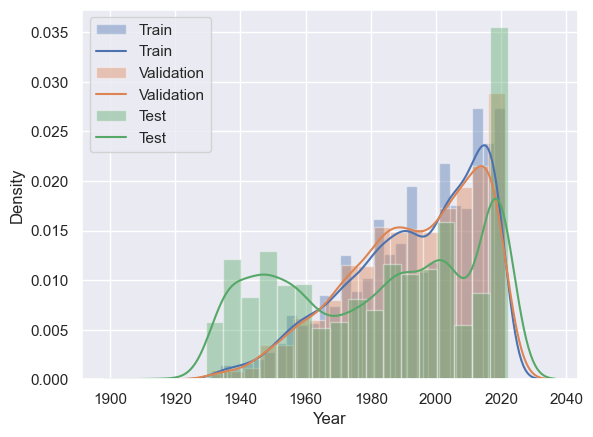

In [194]:
sns.distplot(train_df['Year'].values, label = "Train")
sns.distplot(validation_df['Year'].values, label = "Validation")
sns.distplot(test_df['Year'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Year')

plt.show()


- We see that the Train and validation is similarly distributed.
- While the test dat frame with missing values has a very diiferent distribution.
- We can impute the missing values from train into test.
- Even tough the year is a number it is a categorical variable, so we have to fill with mode of the column.

In [197]:
mode_year = train_df['Year'].mode()
test_df['Year'] = test_df['Year'].fillna(2019)

#### finding why the column still shows null values

In [200]:
test_df['Year'].info()

<class 'pandas.core.series.Series'>
Index: 7584 entries, 0 to 15507
Series name: Year
Non-Null Count  Dtype 
--------------  ----- 
7584 non-null   object
dtypes: object(1)
memory usage: 118.5+ KB


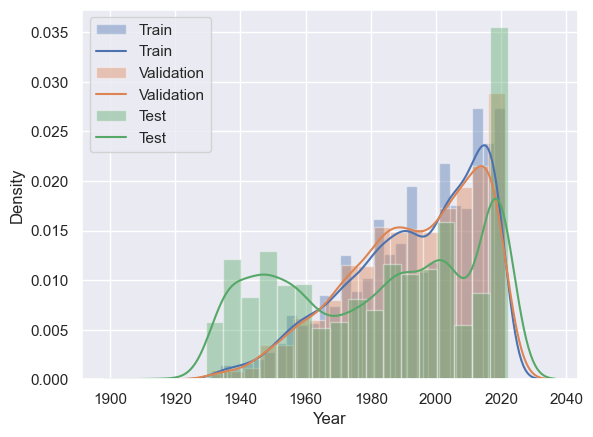

In [202]:
sns.distplot(train_df['Year'].values, label = "Train")
sns.distplot(validation_df['Year'].values, label = "Validation")
sns.distplot(test_df['Year'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Year')

plt.show()

#### Filling the missing values in duration column

In [223]:
# Ensure 'Duration' column is of type string
train_df['Duration'] = train_df['Duration'].astype(str)

# Now extract numeric values and convert to float
train_df['Duration'] = train_df['Duration'].str.extract('([0-9]+)').astype(float)

# Check the result
train_df.head(5)


Name  Year  Duration                   Genre  Rating  \
11500                Rahi  1953     139.0                   Drama     7.0   
5167                Gooli  2008     138.0  Action, Drama, Romance     6.4   
4825   Galiyon Ka Badshah  1989       NaN    Drama, Action, Crime     4.9   
3597       Delhi in a Day  2011      88.0           Comedy, Drama     6.2   
15080                 WOH  2004       NaN  Crime, Drama, Thriller     4.4   

      Votes            Director               Actor 1             Actor 2  \
11500    28  Khwaja Ahmad Abbas             Dev Anand      Nalini Jaywant   
5167     80            P. Satya                Sudeep      Mamta Mohandas   
4825     29     Sher Jung Singh               K. Yogi          Raaj Kumar   
3597    395       Prashant Nair       Victor Banerjee  Siddharth Bhardwaj   
15080    40        Raj N. Sippy  Priyanshu Chatterjee      Sumeet Goradia   

                Actor 3  
11500      Balraj Sahni  
5167   Kishore Kumar G.  
4825        Hema Malini  
3597      Vidya Bhushan  
15080       Cleo Isaacs

In [227]:
# Ensure 'Duration' column is of type string
validation_df['Duration'] = validation_df['Duration'].astype(str)

# Now extract numeric values and convert to float
validation_df['Duration'] = validation_df['Duration'].str.extract('([0-9]+)').astype(float)

# Check the result
validation_df.head(5)


Name  Year  Duration            Genre  Rating  \
12679  Seeking Happily Ever After  2018     104.0   Drama, Romance     6.8   
12294                       Samar  1998     126.0            Drama     7.5   
6739                    Jigariyaa  2014     142.0            Drama     4.9   
348                 Aakhri Insaaf  1980       NaN  Action, Mystery     4.9   
5439                  Hamari Baat  1943       NaN              NaN     8.2   

       Votes        Director              Actor 1            Actor 2  \
12679  1,117     Harish Vyas  Shivani Raghuvanshi       Anshuman Jha   
12294     31   Shyam Benegal   Rajeshwari Sachdev       Rajit Kapoor   
6739     301     Raj Purohit     Harshvardhan Deo      Cherry Mardia   
348       10         Kalidas   Mithun Chakraborty  Vijayendra Ghatge   
5439       9  M.I. Dharamsey          Devika Rani            Suraiya   

              Actor 3  
12679  Ekavali Khanna  
12294    Ravi Jhankal  
6739   Deepak Chaddha  
348       Ashok Kumar  
5439    David Abraham

In [229]:
test_df['Duration'] = test_df['Duration'].str.extract('([0-9]+)').astype(float)
test_df.head(5)

Name  Year  Duration           Genre  Rating Votes  \
0                       NaN       NaN           Drama     NaN   NaN   
2         #Homecoming  2021      90.0  Drama, Musical     NaN   NaN   
4   ...And Once Again  2010     105.0           Drama     NaN   NaN   
7      .in for Motion  2008      59.0     Documentary     NaN   NaN   
14         101 Ratein  1990       NaN        Thriller     NaN   NaN   

              Director       Actor 1             Actor 2          Actor 3  
0        J.S. Randhawa      Manmauji              Birbal  Rajendra Bhatia  
2   Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur       Roy Angana  
4         Amol Palekar  Rajat Kapoor  Rituparna Sengupta      Antara Mali  
7        Anirban Datta           NaN                 NaN              NaN  
14              Harish     Saraswati        Disco Shanti              NaN

#### Checking the distribution of duration

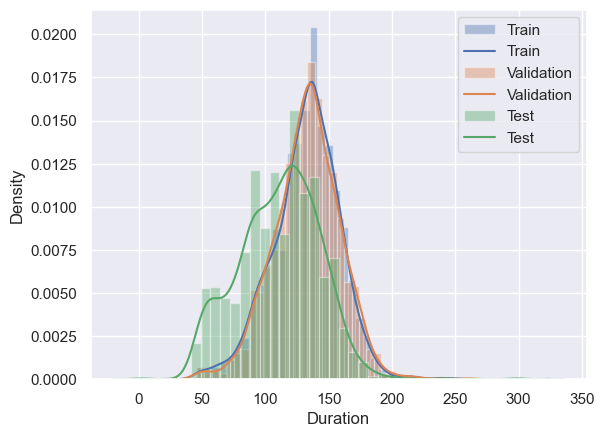

In [232]:


sns.distplot(train_df['Duration'].values, label = "Duration")
sns.distplot(validation_df['Duration'].values, label = "Validation")
sns.distplot(test_df['Duration'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Duration')

plt.show()

We can see that the distribution of training and validation is similar while that of test is a bit off

#### Checking for outliers to see if we need to fill the missing values with mean or median


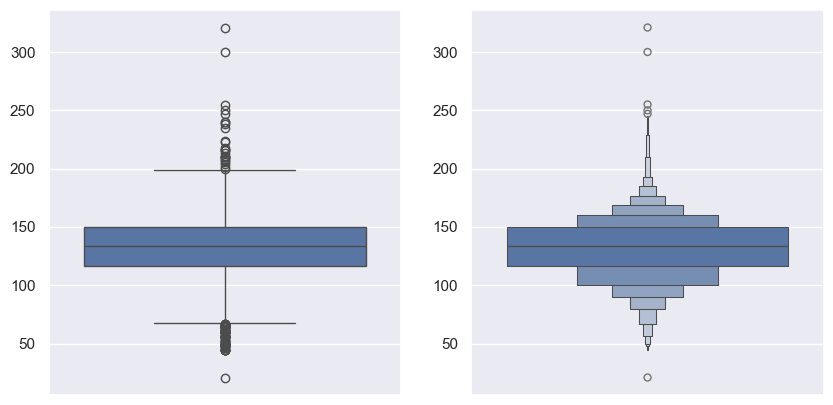

In [236]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(train_df['Duration'].values)

plt.subplot(1, 2, 2)
sns.boxenplot(train_df['Duration'].values)

plt.show()

We see outliers in training dataset, so deciding to fill the null values with median of train.

#### Filling the missing values

In [240]:
median_duration = train_df['Duration'].median()

train_df['Duration'] = train_df['Duration'].fillna(median_duration)
validation_df['Duration'] = validation_df['Duration'].fillna(median_duration)
test_df['Duration'] = test_df['Duration'].fillna(median_duration)

train_df['Duration'].info()

<class 'pandas.core.series.Series'>
Index: 5939 entries, 11500 to 9574
Series name: Duration
Non-Null Count  Dtype  
--------------  -----  
5939 non-null   float64
dtypes: float64(1)
memory usage: 92.8 KB


In [242]:
validation_df['Duration'].info()

<class 'pandas.core.series.Series'>
Index: 1980 entries, 12679 to 2263
Series name: Duration
Non-Null Count  Dtype  
--------------  -----  
1980 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB


In [244]:
test_df['Duration'].info()

<class 'pandas.core.series.Series'>
Index: 7584 entries, 0 to 15507
Series name: Duration
Non-Null Count  Dtype  
--------------  -----  
7584 non-null   float64
dtypes: float64(1)
memory usage: 118.5 KB


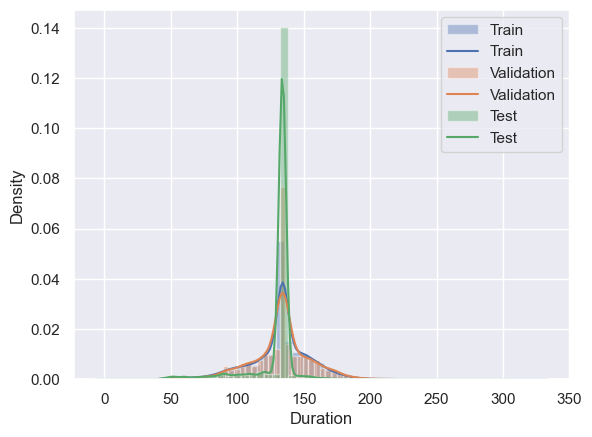

In [246]:
# Seeing the distribution after filling the missing values.

sns.distplot(train_df['Duration'].values, label = "Duration")
sns.distplot(validation_df['Duration'].values, label = "Validation")
sns.distplot(test_df['Duration'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Duration')

plt.show()

#### Filling the missing values in genre column

In [249]:

def expand_genre(df):
    genres_df = df['Genre'].str.split(', ', expand = True)
    df = pd.concat([df, genres_df], axis = 1)
    df.rename(columns = {0 : 'Genre_1', 1 : 'Genre_2', 2 : 'Genre_3'}, inplace = True)
    df.drop('Genre', axis = 1, inplace = True)
    return df

In [251]:
train_df = expand_genre(train_df)
validation_df = expand_genre(validation_df)
test_df = expand_genre(test_df)

#### Missing Values in Genre Columns across Datasets

In [255]:
print("Train Genre_1 missing :", (train_df['Genre_1'].isnull().sum() / len(train_df['Genre_1']) * 100))
print("Train Genre_2 missing :", (train_df['Genre_2'].isnull().sum() / len(train_df['Genre_2']) * 100))
print("Train Genre_3 missing :", (train_df['Genre_3'].isnull().sum() / len(train_df['Genre_3']) * 100))
print("Validation Genre_1 missing :", (validation_df['Genre_1'].isnull().sum() / len(validation_df['Genre_1']) * 100))
print("Validation Genre_2 missing :", (validation_df['Genre_2'].isnull().sum() / len(validation_df['Genre_2']) * 100))
print("Validation Genre_3 missing :", (validation_df['Genre_3'].isnull().sum() / len(validation_df['Genre_3']) * 100))
print("Test Genre_1 missing :", (test_df['Genre_1'].isnull().sum() / len(test_df['Genre_1']) * 100))
print("Test Genre_2 missing :", (test_df['Genre_2'].isnull().sum() / len(test_df['Genre_2']) * 100))
print("Test Genre_3 missing :", (test_df['Genre_3'].isnull().sum() / len(test_df['Genre_3']) * 100))

Train Genre_1 missing : 1.3301902677218387
Train Genre_2 missing : 35.948812931469945
Train Genre_3 missing : 64.65734972217545
Validation Genre_1 missing : 1.1616161616161615
Validation Genre_2 missing : 34.24242424242424
Validation Genre_3 missing : 63.98989898989898
Test Genre_1 missing : 23.39135021097046
Test Genre_2 missing : 85.5617088607595
Test Genre_3 missing : 94.35654008438819


We see that the missing values in the second and third sub-genre has missing values more than 35%, we drop the sub-genres
- calculates the percentage of missing values in the 'Genre_1', 'Genre_2', and 'Genre_3' columns for the train_df, validation_df, and test_df dataframes. By using the isnull().sum() method, it identifies how much data is missing in each column, and the result is expressed as a percentage of the total number of records in each respective dataset.

In [260]:
def drop_genre(df):
    df.drop(['Genre_2','Genre_3'], axis = 1, inplace = True)
    df.rename(columns = {'Genre_1' : 'Genre'}, inplace = True)
    return df

train_df = drop_genre(train_df)
validation_df = drop_genre(validation_df)
test_df = drop_genre(test_df)

In [262]:
train_df.head(5)

Name  Year  Duration  Rating Votes            Director  \
11500                Rahi  1953     139.0     7.0    28  Khwaja Ahmad Abbas   
5167                Gooli  2008     138.0     6.4    80            P. Satya   
4825   Galiyon Ka Badshah  1989     134.0     4.9    29     Sher Jung Singh   
3597       Delhi in a Day  2011      88.0     6.2   395       Prashant Nair   
15080                 WOH  2004     134.0     4.4    40        Raj N. Sippy   

                    Actor 1             Actor 2           Actor 3   Genre  
11500             Dev Anand      Nalini Jaywant      Balraj Sahni   Drama  
5167                 Sudeep      Mamta Mohandas  Kishore Kumar G.  Action  
4825                K. Yogi          Raaj Kumar       Hema Malini   Drama  
3597        Victor Banerjee  Siddharth Bhardwaj     Vidya Bhushan  Comedy  
15080  Priyanshu Chatterjee      Sumeet Goradia       Cleo Isaacs   Crime

In [264]:
validation_df.head(5)

Name  Year  Duration  Rating  Votes  \
12679  Seeking Happily Ever After  2018     104.0     6.8  1,117   
12294                       Samar  1998     126.0     7.5     31   
6739                    Jigariyaa  2014     142.0     4.9    301   
348                 Aakhri Insaaf  1980     134.0     4.9     10   
5439                  Hamari Baat  1943     134.0     8.2      9   

             Director              Actor 1            Actor 2         Actor 3  \
12679     Harish Vyas  Shivani Raghuvanshi       Anshuman Jha  Ekavali Khanna   
12294   Shyam Benegal   Rajeshwari Sachdev       Rajit Kapoor    Ravi Jhankal   
6739      Raj Purohit     Harshvardhan Deo      Cherry Mardia  Deepak Chaddha   
348           Kalidas   Mithun Chakraborty  Vijayendra Ghatge     Ashok Kumar   
5439   M.I. Dharamsey          Devika Rani            Suraiya   David Abraham   

        Genre  
12679   Drama  
12294   Drama  
6739    Drama  
348    Action  
5439      NaN

In [266]:
test_df.head(5)

Name  Year  Duration  Rating Votes            Director  \
0                       NaN     134.0     NaN   NaN       J.S. Randhawa   
2         #Homecoming  2021      90.0     NaN   NaN  Soumyajit Majumdar   
4   ...And Once Again  2010     105.0     NaN   NaN        Amol Palekar   
7      .in for Motion  2008      59.0     NaN   NaN       Anirban Datta   
14         101 Ratein  1990     134.0     NaN   NaN              Harish   

         Actor 1             Actor 2          Actor 3        Genre  
0       Manmauji              Birbal  Rajendra Bhatia        Drama  
2   Sayani Gupta   Plabita Borthakur       Roy Angana        Drama  
4   Rajat Kapoor  Rituparna Sengupta      Antara Mali        Drama  
7            NaN                 NaN              NaN  Documentary  
14     Saraswati        Disco Shanti              NaN     Thriller

#### Filling the missing values based on Mode Imputaion method 

In [272]:
# Imputing Missing 'Genre' Values Using Mode by Year
mode_per_year = train_df.groupby('Year')['Genre'].apply(lambda x: x.mode().iloc[0])    # Gives a df with node of each year
train_df['Genre'] = train_df.apply(lambda row: mode_per_year[row['Year']] if pd.isnull(row['Genre']) else row['Genre'], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5939 entries, 11500 to 9574
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5939 non-null   object 
 1   Year      5939 non-null   int32  
 2   Duration  5939 non-null   float64
 3   Rating    5939 non-null   float64
 4   Votes     5939 non-null   object 
 5   Director  5935 non-null   object 
 6   Actor 1   5837 non-null   object 
 7   Actor 2   5783 non-null   object 
 8   Actor 3   5713 non-null   object 
 9   Genre     5939 non-null   object 
dtypes: float64(2), int32(1), object(7)
memory usage: 487.2+ KB


imputes missing values in the 'Genre' column of the train_df dataframe by using the mode (most frequent value) of the 'Genre' for each specific 'Year'. It first calculates the mode of the 'Genre' for each 'Year', then applies this mode to fill missing values in the 'Genre' column

In [274]:
validation_df['Genre'] = validation_df.apply(lambda row:mode_per_year[row['Year']] if pd.isnull(row['Genre']) else row['Genre'], axis=1)
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980 entries, 12679 to 2263
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1980 non-null   object 
 1   Year      1980 non-null   int32  
 2   Duration  1980 non-null   float64
 3   Rating    1980 non-null   float64
 4   Votes     1980 non-null   object 
 5   Director  1979 non-null   object 
 6   Actor 1   1957 non-null   object 
 7   Actor 2   1936 non-null   object 
 8   Actor 3   1914 non-null   object 
 9   Genre     1980 non-null   object 
dtypes: float64(2), int32(1), object(7)
memory usage: 162.4+ KB


#### Filling the missing values of the genre in test df with the mode of train_df

In [277]:
genre_mode = train_df['Genre'].mode()
genre_mode

0    Drama
Name: Genre, dtype: object

In [279]:
test_df['Genre'] = test_df['Genre'].fillna('Drama')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7057 non-null   object 
 2   Duration  7584 non-null   float64
 3   Rating    0 non-null      float64
 4   Votes     1 non-null      object 
 5   Director  7065 non-null   object 
 6   Actor 1   6094 non-null   object 
 7   Actor 2   5403 non-null   object 
 8   Actor 3   4736 non-null   object 
 9   Genre     7584 non-null   object 
dtypes: float64(2), object(8)
memory usage: 651.8+ KB


In [281]:
# Treating the missing values in Votes column in test dataset
# Checking the unique values

set(test_df['Votes'].tolist())

{'$5.16M', nan}

In [283]:
# The one non null value seems to be a wrong value, making it to nan

test_df.index[test_df['Votes'] == '$5.16M']

Index([9500], dtype='int64')

In [285]:
test_df['Votes'][9500] = pd.NA

In [287]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7057 non-null   object 
 2   Duration  7584 non-null   float64
 3   Rating    0 non-null      float64
 4   Votes     0 non-null      object 
 5   Director  7065 non-null   object 
 6   Actor 1   6094 non-null   object 
 7   Actor 2   5403 non-null   object 
 8   Actor 3   4736 non-null   object 
 9   Genre     7584 non-null   object 
dtypes: float64(2), object(8)
memory usage: 909.8+ KB


In [289]:
# Filling the missing values in the names of Directors and actors as 'Not Available'

def fill_names(df):
    df['Director'] = df['Director'].fillna('Not Available')
    df['Actor 1'] = df['Actor 1'].fillna('Not Available')
    df['Actor 2'] = df['Actor 2'].fillna('Not Available')
    df['Actor 3'] = df['Actor 3'].fillna('Not Available')
    return df

train_df = fill_names(train_df)
validation_df = fill_names(validation_df)
test_df = fill_names(test_df)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5939 entries, 11500 to 9574
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5939 non-null   object 
 1   Year      5939 non-null   int32  
 2   Duration  5939 non-null   float64
 3   Rating    5939 non-null   float64
 4   Votes     5939 non-null   object 
 5   Director  5939 non-null   object 
 6   Actor 1   5939 non-null   object 
 7   Actor 2   5939 non-null   object 
 8   Actor 3   5939 non-null   object 
 9   Genre     5939 non-null   object 
dtypes: float64(2), int32(1), object(7)
memory usage: 487.2+ KB


In [291]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980 entries, 12679 to 2263
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1980 non-null   object 
 1   Year      1980 non-null   int32  
 2   Duration  1980 non-null   float64
 3   Rating    1980 non-null   float64
 4   Votes     1980 non-null   object 
 5   Director  1980 non-null   object 
 6   Actor 1   1980 non-null   object 
 7   Actor 2   1980 non-null   object 
 8   Actor 3   1980 non-null   object 
 9   Genre     1980 non-null   object 
dtypes: float64(2), int32(1), object(7)
memory usage: 162.4+ KB


In [293]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7057 non-null   object 
 2   Duration  7584 non-null   float64
 3   Rating    0 non-null      float64
 4   Votes     0 non-null      object 
 5   Director  7584 non-null   object 
 6   Actor 1   7584 non-null   object 
 7   Actor 2   7584 non-null   object 
 8   Actor 3   7584 non-null   object 
 9   Genre     7584 non-null   object 
dtypes: float64(2), object(8)
memory usage: 909.8+ KB


#### Missing Values Summary Across Train, Validation, and Test Datasets

In [296]:
# Checking for missing values

train_missing = list(train_df.isnull().sum())
val_missing = list(validation_df.isnull().sum())
test_misisng = list(test_df.isnull().sum())

train_missing_percent = list(train_df.isnull().sum() / len(train_df) * 100)
val_missing_percent = list(validation_df.isnull().sum() / len(validation_df) * 100)
test_misisng_percent = list(test_df.isnull().sum() / len(test_df) * 100)

missing_df = pd.DataFrame({'Columns' : list(train_df.columns), 'Train_missing' : train_missing, 'Percent_Train_missing' : train_missing_percent, 
                'Validation_missing' : val_missing, 'Percent_Val_missing' : val_missing_percent, 'Test_missing' : test_misisng, 
                           'Percent_Test_missing' : test_misisng_percent})
missing_df

Columns  Train_missing  Percent_Train_missing  Validation_missing  \
0      Name              0                    0.0                   0   
1      Year              0                    0.0                   0   
2  Duration              0                    0.0                   0   
3    Rating              0                    0.0                   0   
4     Votes              0                    0.0                   0   
5  Director              0                    0.0                   0   
6   Actor 1              0                    0.0                   0   
7   Actor 2              0                    0.0                   0   
8   Actor 3              0                    0.0                   0   
9     Genre              0                    0.0                   0   

   Percent_Val_missing  Test_missing  Percent_Test_missing  
0                  0.0             0               0.00000  
1                  0.0           527               6.94884  
2                  0.0             0               0.00000  
3                  0.0          7584             100.00000  
4                  0.0          7584             100.00000  
5                  0.0             0               0.00000  
6                  0.0             0               0.00000  
7                  0.0             0               0.00000  
8                  0.0             0               0.00000  
9                  0.0             0               0.00000

All the missing data is now cleared.
- calculates and presents the count and percentage of missing values for each column in the train, validation, and test datasets. It creates a DataFrame, missing_df, which summarizes the missing data statistics across all datasets, helping to quickly identify which columns have missing values and how they differ across datasets.

### Exploratory Data Analysis(EDA)

In [304]:
# Exploring the signficance of every variable

filled_df = pd.concat([train_df, validation_df], axis = 0)
filled_df.head(5)

Name  Year  Duration  Rating Votes            Director  \
11500                Rahi  1953     139.0     7.0    28  Khwaja Ahmad Abbas   
5167                Gooli  2008     138.0     6.4    80            P. Satya   
4825   Galiyon Ka Badshah  1989     134.0     4.9    29     Sher Jung Singh   
3597       Delhi in a Day  2011      88.0     6.2   395       Prashant Nair   
15080                 WOH  2004     134.0     4.4    40        Raj N. Sippy   

                    Actor 1             Actor 2           Actor 3   Genre  
11500             Dev Anand      Nalini Jaywant      Balraj Sahni   Drama  
5167                 Sudeep      Mamta Mohandas  Kishore Kumar G.  Action  
4825                K. Yogi          Raaj Kumar       Hema Malini   Drama  
3597        Victor Banerjee  Siddharth Bhardwaj     Vidya Bhushan  Comedy  
15080  Priyanshu Chatterjee      Sumeet Goradia       Cleo Isaacs   Crime

In [306]:
filled_df['Votes'].info

<bound method Series.info of 11500        28
5167         80
4825         29
3597        395
15080        40
          ...  
65            5
2648      2,236
9224         72
6737         28
2263     22,777
Name: Votes, Length: 7919, dtype: object>

In [308]:
# Votes should be a numberic column, but it is of object datatype, converting the column to numeric datatype

filled_df['Votes'] = filled_df['Votes'].str.replace(',','').astype(int)
train_df['Votes'] = train_df['Votes'].str.replace(',','').astype(int)
validation_df['Votes'] = validation_df['Votes'].str.replace(',','').astype(int)

#### scatterplot

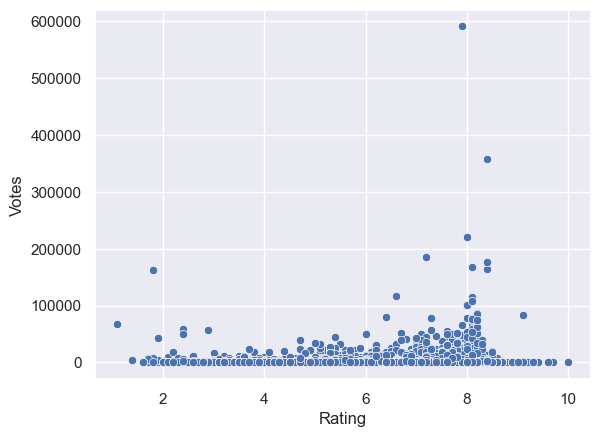

In [311]:
sns.scatterplot(x = filled_df['Rating'], y = filled_df['Votes'])
plt.show()

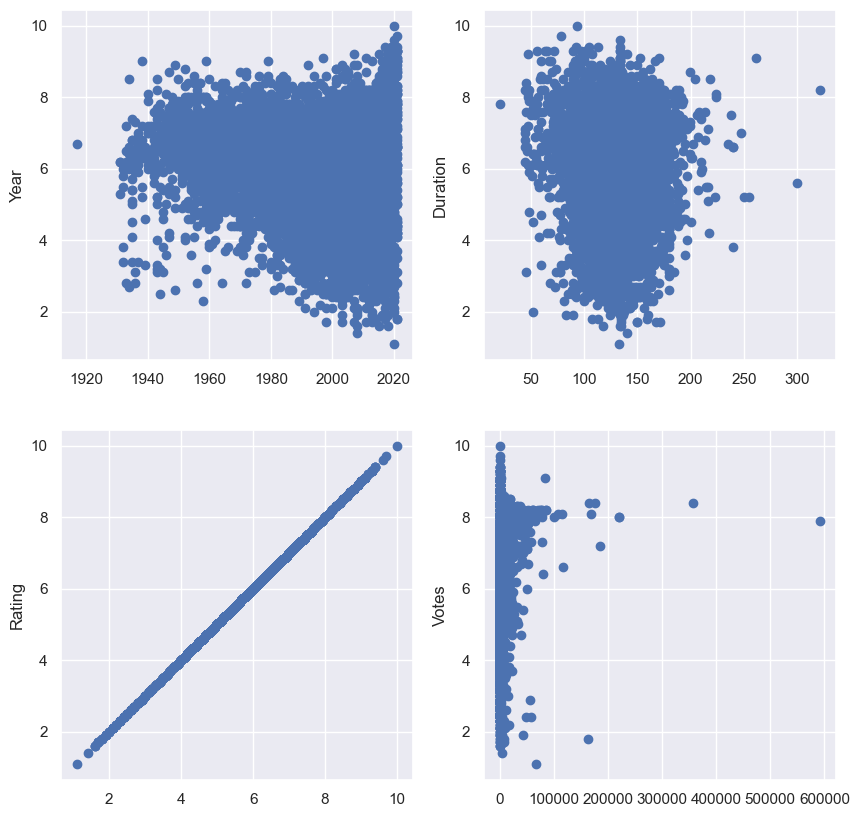

In [313]:
# Visualising the data to understand the significance

numeric_cols = filled_df.select_dtypes(include = np.number)
col_names = list(numeric_cols.columns)
col_index = 0
plt_rows = 2
plt_cols = 2

fig, ax = plt.subplots(nrows = plt_rows, ncols = plt_cols, figsize = (10, 10))

for row_count in range(plt_rows):
    for col_count in range(plt_cols):
        ax[row_count][col_count].scatter(x = filled_df[col_names[col_index]], y = filled_df['Rating'], c = ['b'])
        ax[row_count][col_count].set_ylabel(col_names[col_index])
        col_index += 1

#### HeatMap

In [316]:
# Checking the heat map

# plt.figure(figsize = (4,4))
# sns.heatmap(filled_df.corr(), annot = True, cmap = 'coolwarm')
# plt.show()

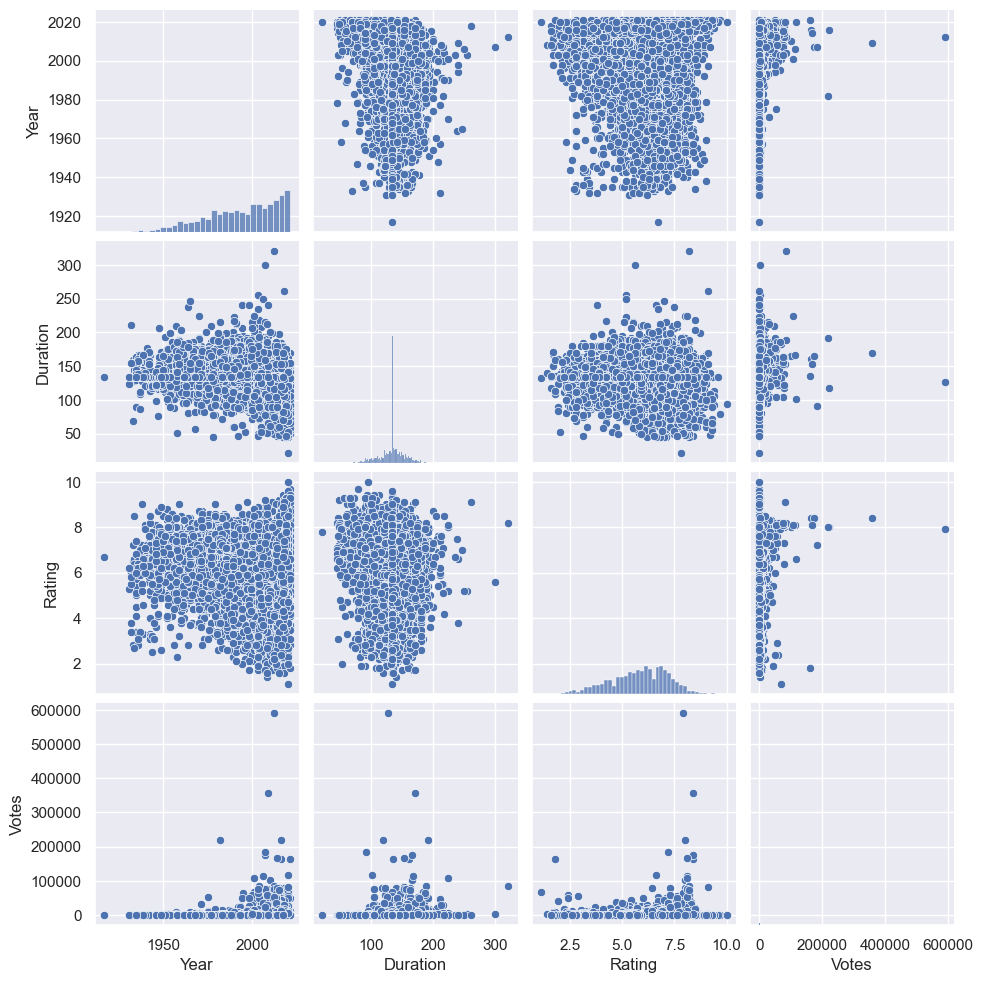

In [318]:
sns.pairplot(filled_df)

#### There is nothing unsual with that we can see from the above visualizations

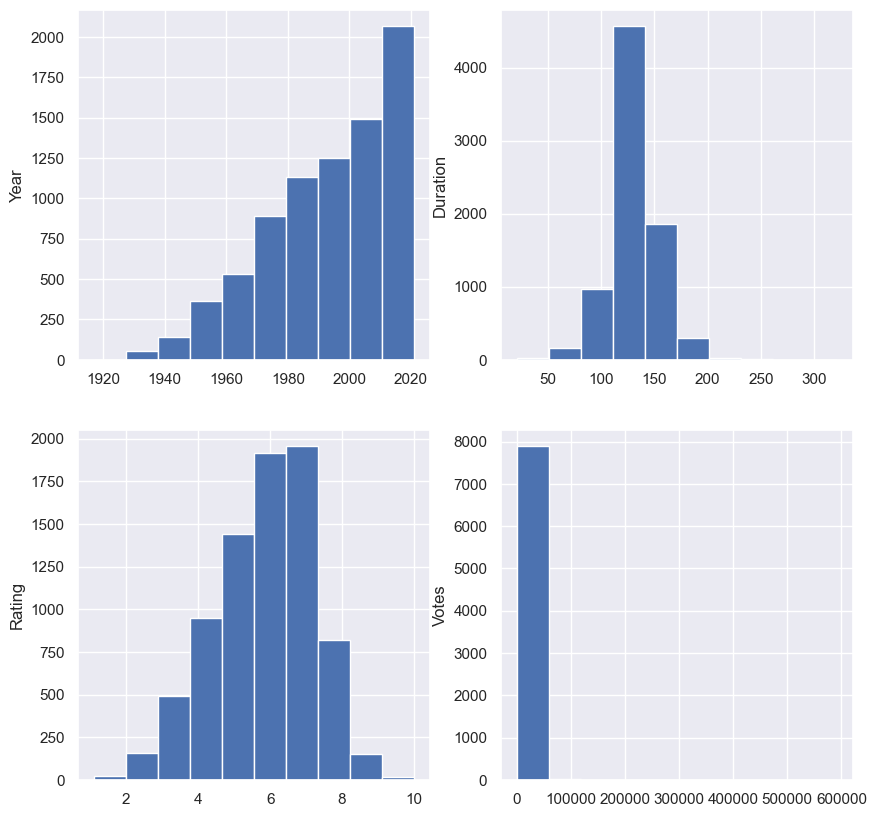

In [320]:
# Checking the distributions of each column

col_index = 0

fig, ax = plt.subplots(nrows = plt_rows, ncols = plt_cols, figsize = (10, 10))

for row_count in range(plt_rows):
    for col_count in range(plt_cols):
        ax[row_count][col_count].hist(filled_df[col_names[col_index]])
        ax[row_count][col_count].set_ylabel(col_names[col_index])
        col_index += 1

In [321]:
# Viz functions

def top_ten(col):
    filled_df[col].value_counts().sort_values(ascending = False)[:10].plot(kind = "bar")
    plt.title("Top Ten {}s".format(col))
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
    
def word_map(col):
    text_data = ' '.join(filled_df[col])
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(text_data)
    plt.figure(figsize = (10,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

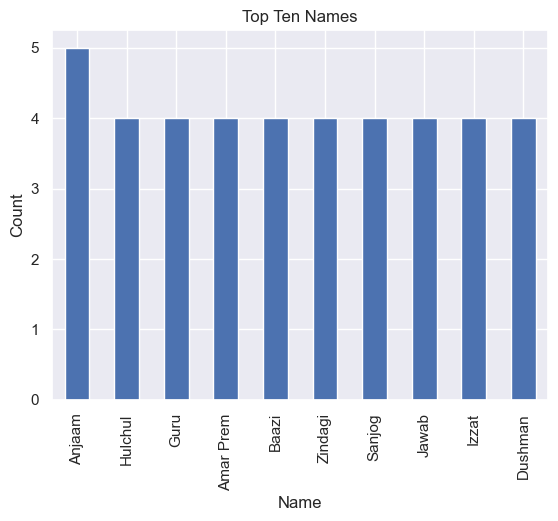

In [322]:
top_ten("Name")

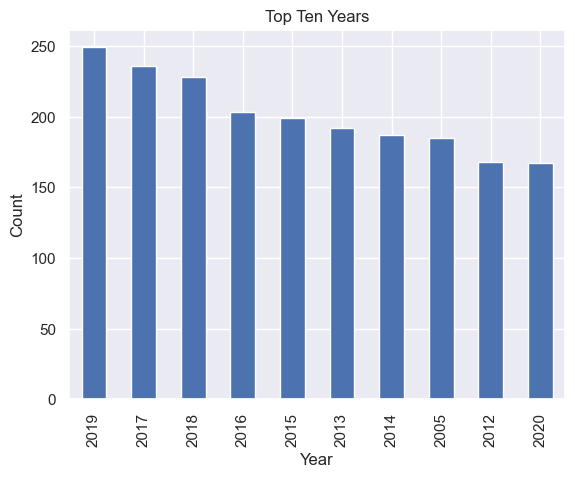

In [323]:
top_ten("Year")

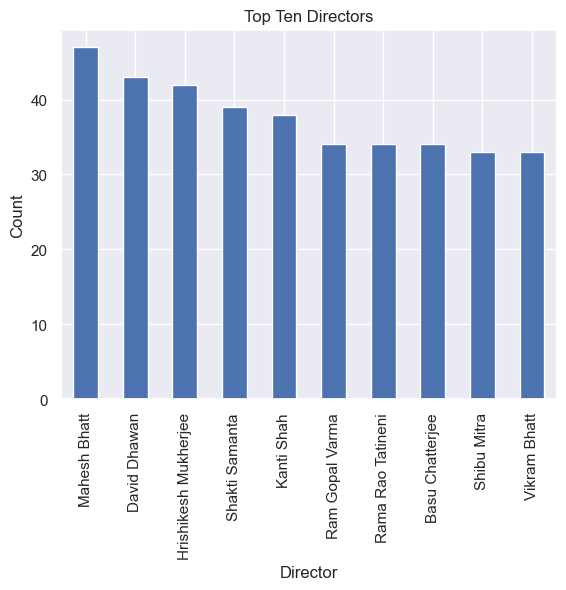

In [324]:
top_ten("Director")

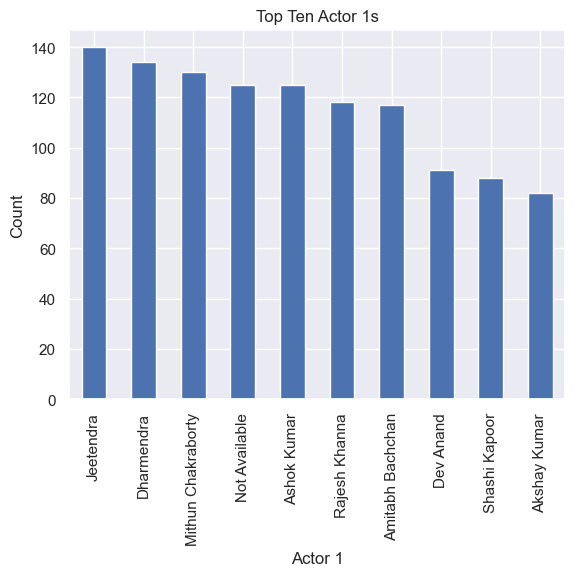

In [325]:
top_ten("Actor 1")

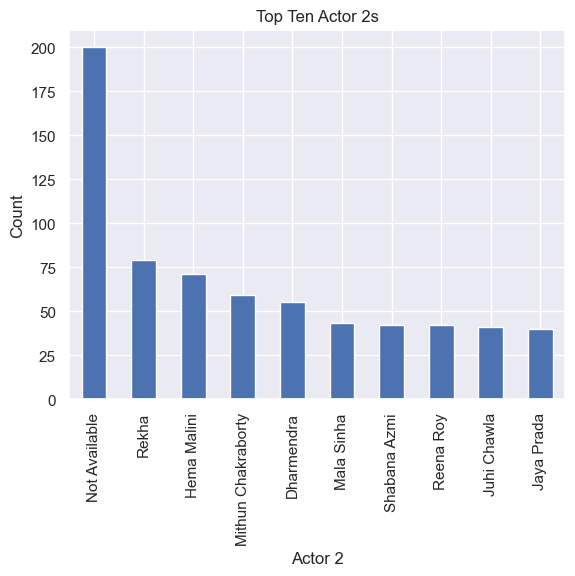

In [326]:
top_ten("Actor 2")

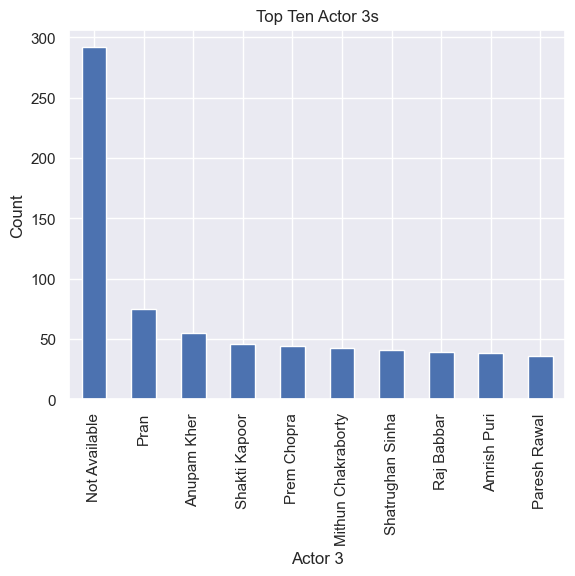

In [327]:
top_ten("Actor 3")

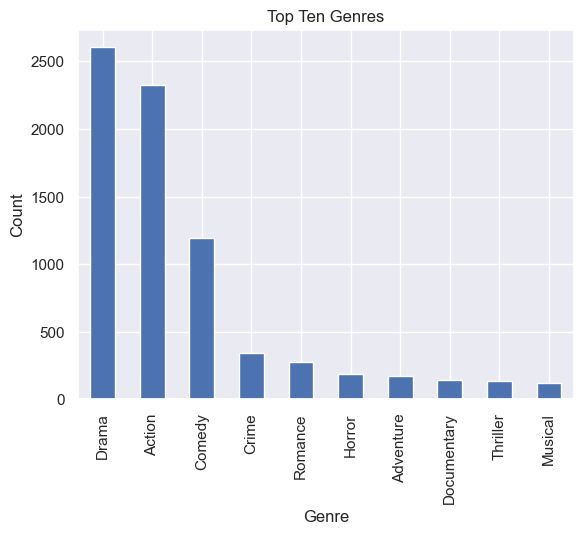

In [328]:
top_ten("Genre")

In [329]:
filled_df.head(5)

Name  Year  Duration  Rating  Votes            Director  \
11500                Rahi  1953     139.0     7.0     28  Khwaja Ahmad Abbas   
5167                Gooli  2008     138.0     6.4     80            P. Satya   
4825   Galiyon Ka Badshah  1989     134.0     4.9     29     Sher Jung Singh   
3597       Delhi in a Day  2011      88.0     6.2    395       Prashant Nair   
15080                 WOH  2004     134.0     4.4     40        Raj N. Sippy   

                    Actor 1             Actor 2           Actor 3   Genre  
11500             Dev Anand      Nalini Jaywant      Balraj Sahni   Drama  
5167                 Sudeep      Mamta Mohandas  Kishore Kumar G.  Action  
4825                K. Yogi          Raaj Kumar       Hema Malini   Drama  
3597        Victor Banerjee  Siddharth Bhardwaj     Vidya Bhushan  Comedy  
15080  Priyanshu Chatterjee      Sumeet Goradia       Cleo Isaacs   Crime

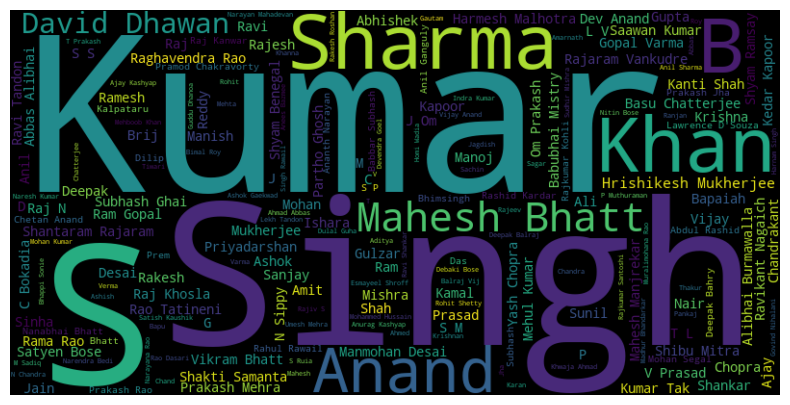

In [341]:
word_map("Director")

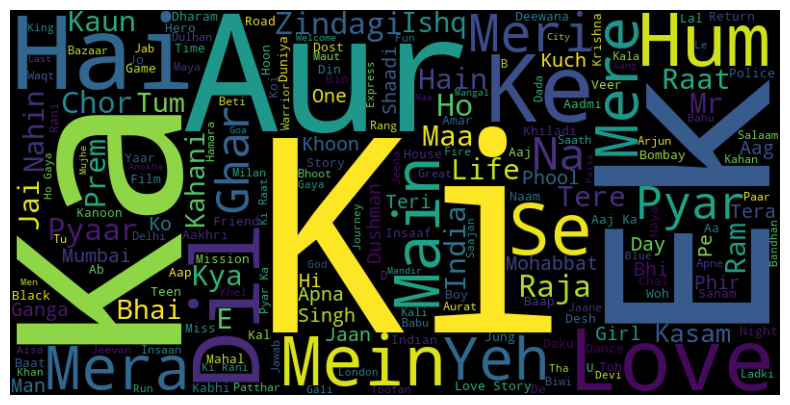

In [342]:
word_map("Name")

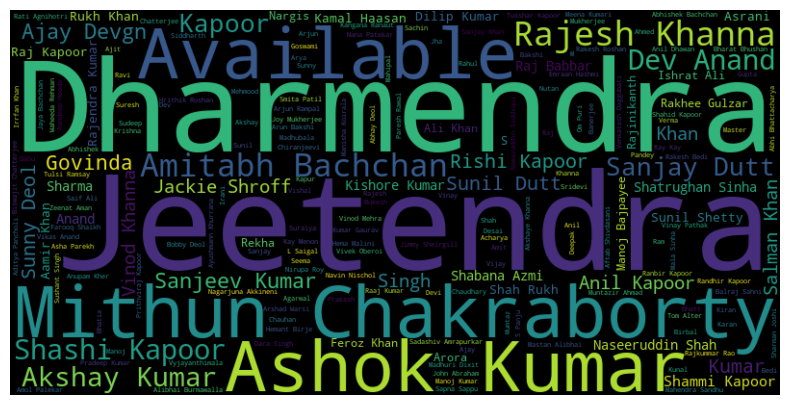

In [344]:
word_map("Actor 1")

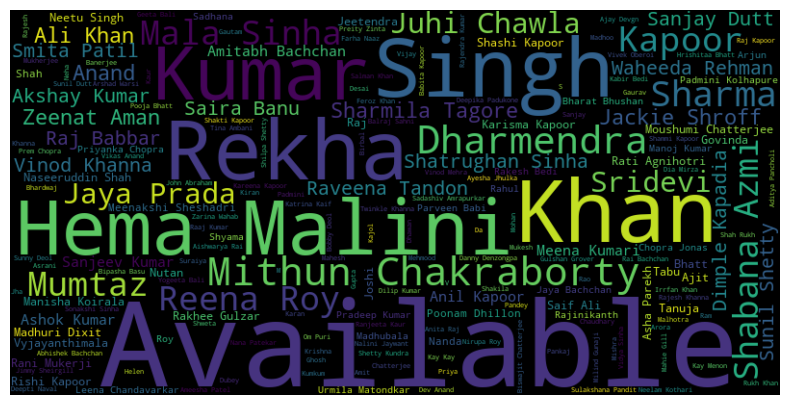

In [347]:
word_map("Actor 2")

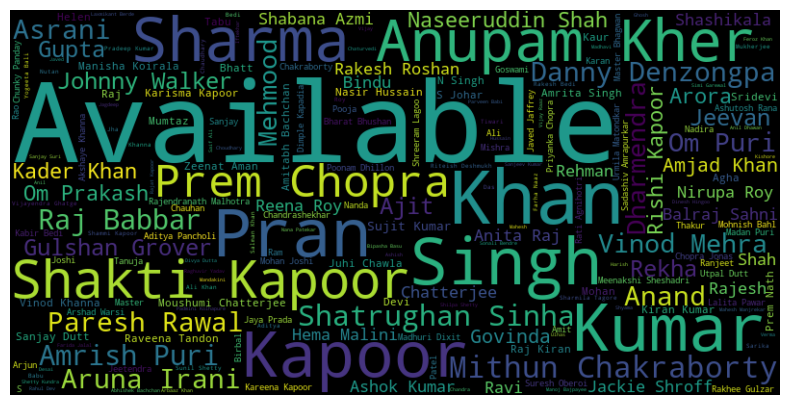

In [348]:
word_map("Actor 3")

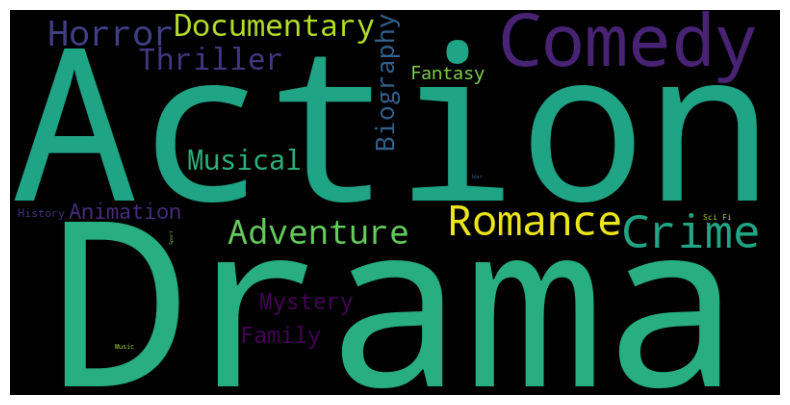

In [349]:
word_map("Genre")


- The movie title "Anjaam" has appeared in 5 different films.
- The year 2019 saw the highest number of movie releases.
- Director "Mahesh Bhatt" holds the record for directing the most films.
- "Jeetendra" has been the lead actor in the greatest number of films.
- "Mithun Chakraborty" appears in the top 10 of all actor categories, making him the most notable actor across all films.
- "Rekha" has consistently been the lead actress in several films.
- Drama and Action genres dominate the dataset, significantly outnumbering all other genres.

#### Checking each variable against the target variable

In [356]:
def rating_per(col, color):
    avg_rating = filled_df.groupby(col)['Rating'].mean().reset_index()
    plt.figure(figsize = (8, 4))
    plt.bar(avg_rating[col], avg_rating['Rating'], color = color)
    plt.title('{}-wise Ratings'.format(col))
    plt.xlabel(col)
    plt.ylabel('Rating')
    plt.grid(axis='y', linestyle='--', alpha=0.8)
    plt.show()

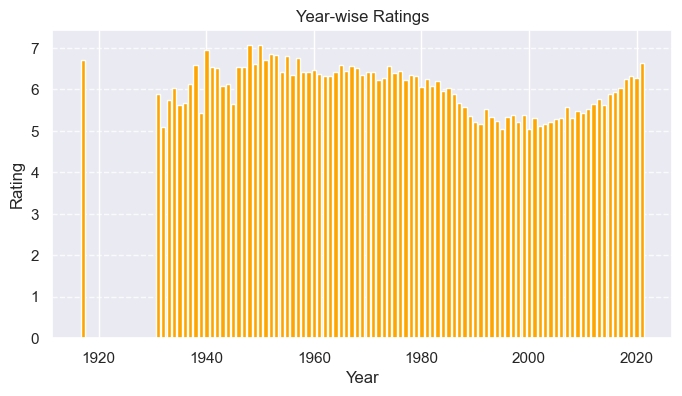

In [358]:
rating_per('Year', 'orange')

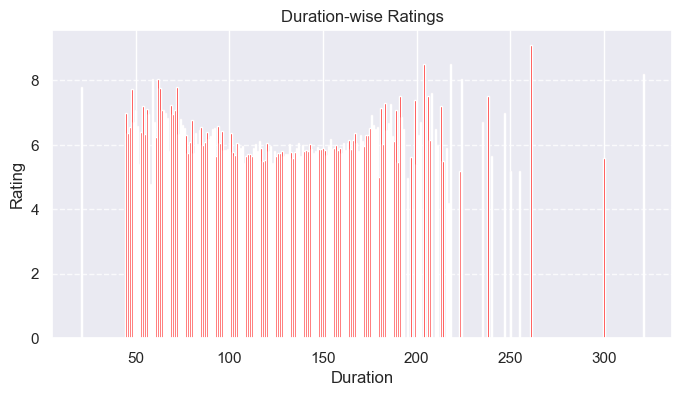

In [360]:
rating_per('Duration', 'red')

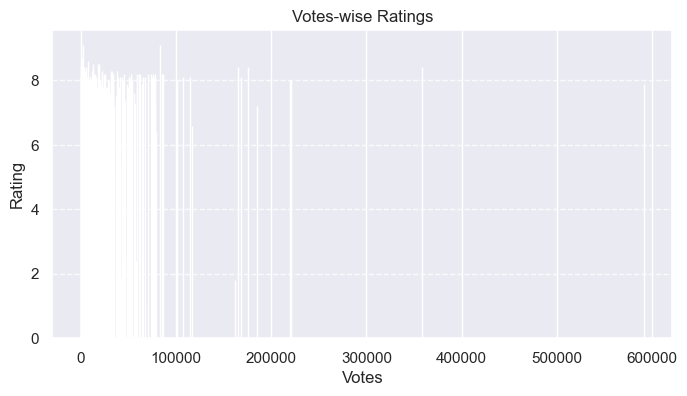

In [366]:
rating_per('Votes','blue')

In [368]:
def top_rated(col):
    avg_rating = filled_df.groupby(col)['Rating'].mean().reset_index()
    top20 = avg_rating.sort_values(by='Rating', ascending=False).head(20)[col]
    top20_df = filled_df[filled_df[col].isin(top20)]
    sorted_top20_df = top20_df.sort_values(by = 'Rating', ascending = False)
    plt.figure(figsize = (10, 6))
    sns.violinplot(x = 'Rating', y = col, data = sorted_top20_df, palette = 'muted')
    plt.title('{}-wise Rating Distribution'.format(col))
    plt.xlabel(col)
    plt.ylabel('Rating')
    plt.show()

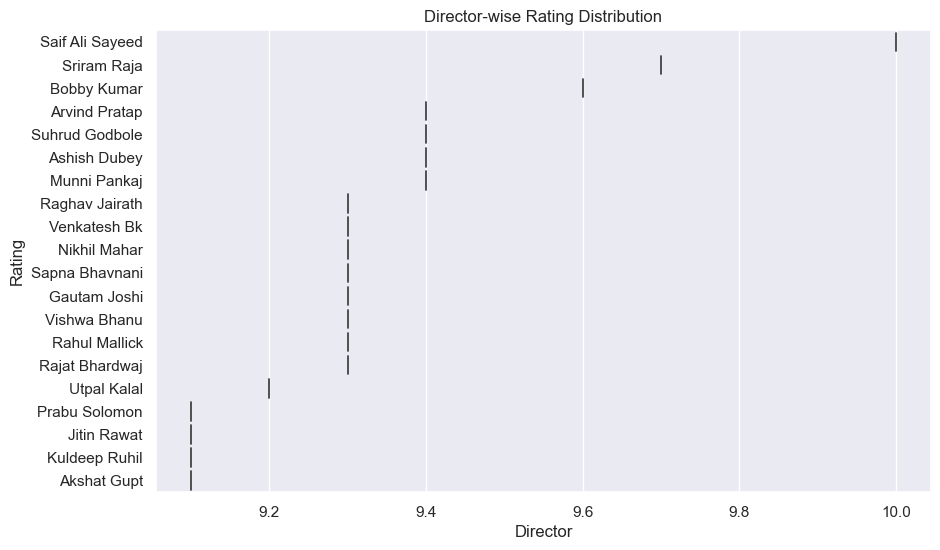

In [370]:
top_rated('Director')

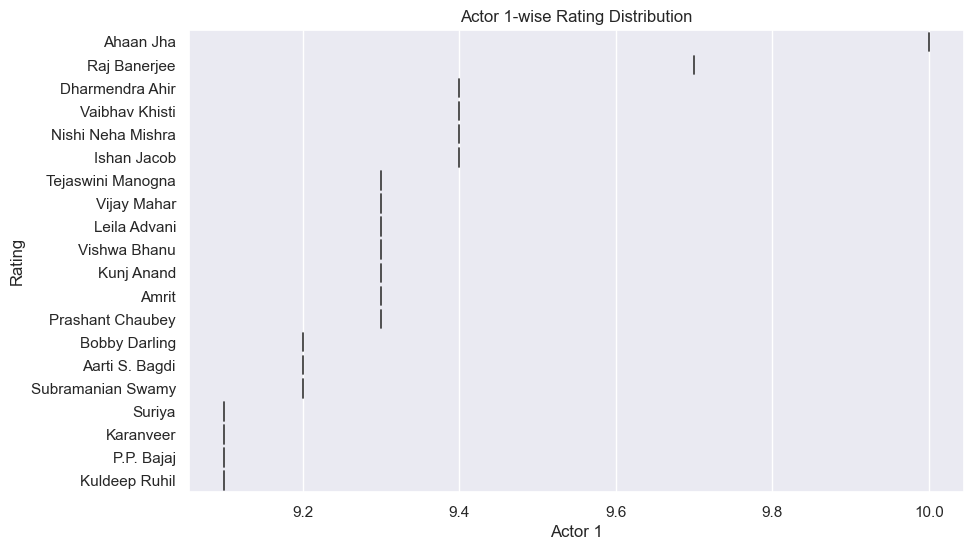

In [372]:
top_rated('Actor 1')

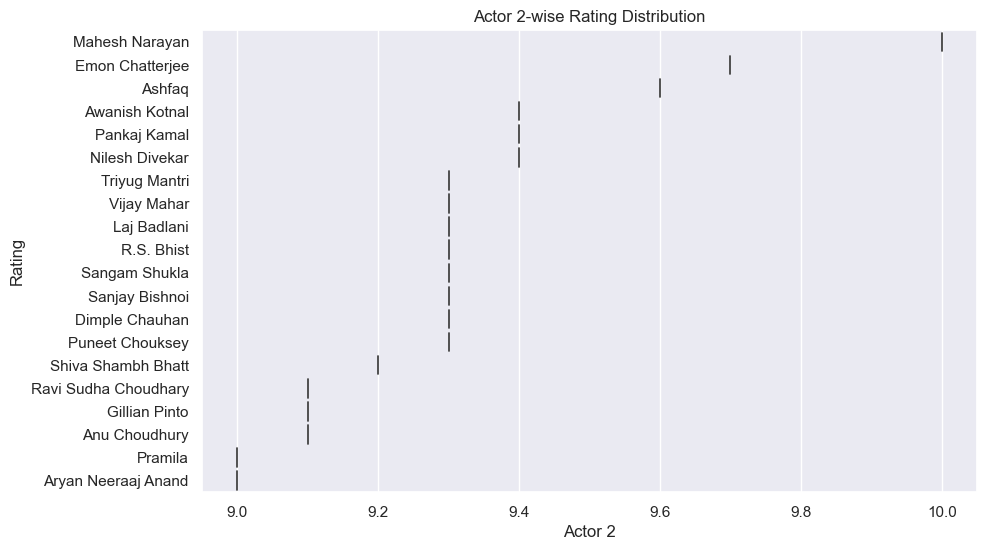

In [374]:
top_rated('Actor 2')

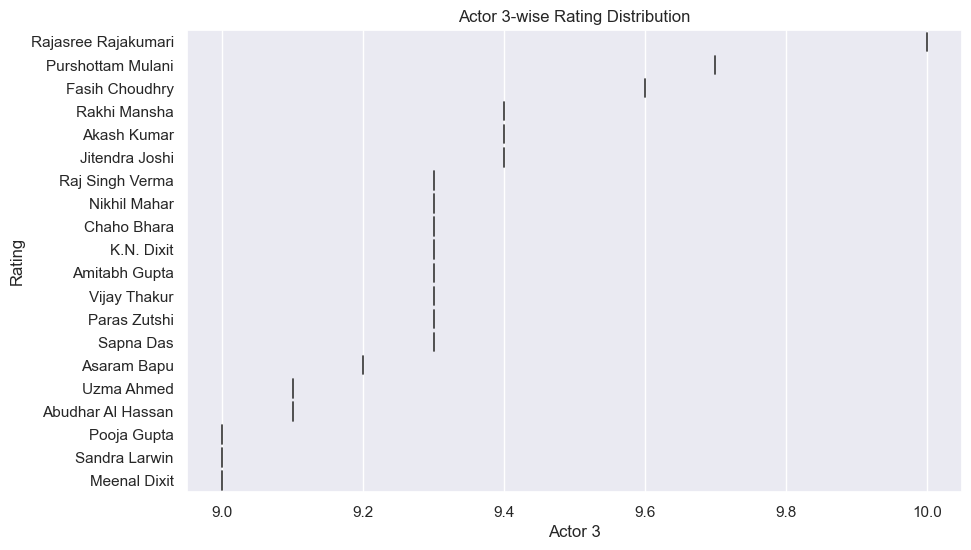

In [376]:
top_rated('Actor 3')

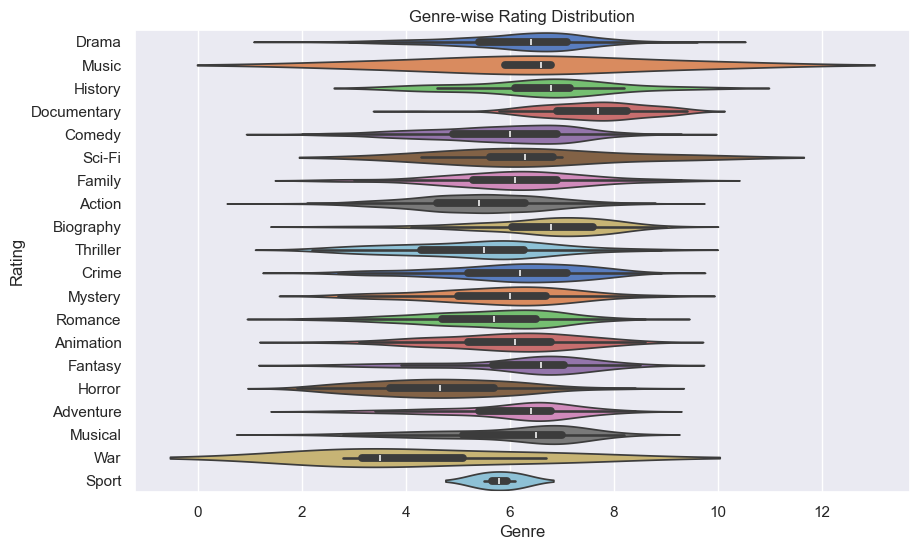

In [378]:
top_rated('Genre')


- Analyzing the average ratings per year reveals that movies released between 1980 and 2010 tend to have lower ratings, with a noticeable upward trend starting after 2000. This could be attributed to the technological advancements at the turn of the 21st century and how Indian cinema adapted to these innovations.
- Interestingly, movies with durations around the median tend to have lower ratings, while films at both ends of the duration spectrum receive higher ratings.
- There is a high concentration of votes under 10,000, which makes it challenging to draw conclusions based solely on vote counts.
- When looking at the top 20 rated directors and actors, it's clear that the highest-rated individuals have relatively few works credited to their name. This suggests that top-rated directors and actors have worked on fewer films overall.
- It’s no surprise that the Drama genre has the highest average ratings, likely due to the large number of Drama films.
- The high ratings for the Music genre are unexpected, especially when compared to the more popular Family and Romance genres, which typically dominate the Indian movie industry.

In [381]:
top_movies_overall = filled_df.nlargest(10, 'Rating')

# Find the top 10 movies per year
top_movies_per_year = filled_df.groupby('Year').apply(lambda x: x.nlargest(10, 'Rating')).reset_index(drop=True)

# Display the results
print("Top 10 Movies Overall:")
print(top_movies_overall)

print("\nTop 10 Movies Per Year:")
print(top_movies_per_year)

Top 10 Movies Overall:
                      Name  Year  Duration  Rating  Votes         Director  \
8339       Love Qubool Hai  2020      94.0    10.0      5  Saif Ali Sayeed   
5410            Half Songs  2021      79.0     9.7      7      Sriram Raja   
2563                 Breed  2020     134.0     9.6     48      Bobby Kumar   
14222  The Reluctant Crime  2020     113.0     9.4     16    Arvind Pratap   
5077          Gho Gho Rani  2019     105.0     9.4     47     Munni Pankaj   
11704             Ram-Path  2017     134.0     9.4      5     Ashish Dubey   
6852                  June  2021      93.0     9.4     18   Suhrud Godbole   
9105                 Meher  2020     134.0     9.3     27   Rajat Bhardwaj   
1314          Ashok Vatika  2018      97.0     9.3      7    Rahul Mallick   
1729              Baikunth  2021      72.0     9.3     29     Vishwa Bhanu   

                 Actor 1          Actor 2              Actor 3        Genre  
8339           Ahaan Jha   Mahesh Naraya

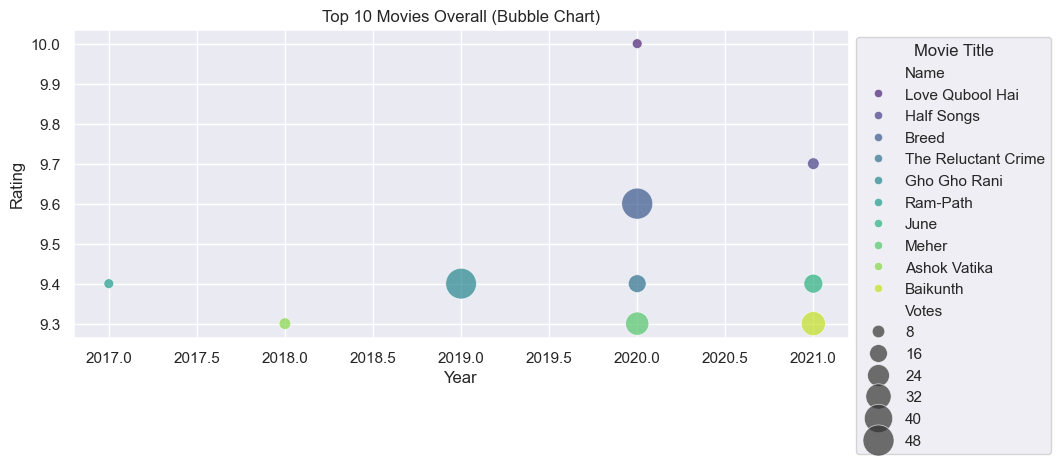

In [383]:
# Visualising the top rated movies per year will not be clear because of the large number of rows
# Trying to visualise the overall top rated movies based on the number of votes

plt.figure(figsize=(10, 4))
sns.scatterplot(x = 'Year', y = 'Rating', size = 'Votes', data = top_movies_overall, hue = 'Name', sizes = (50, 500), palette = 'viridis', alpha = 0.7)
plt.title('Top 10 Movies Overall (Bubble Chart)')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'Movie Title')
plt.show()

- We see that the top rated movies overall have very low votes compared to the other mvies with thousands of votes.
- We also see that the years 2020 and 2021 have the most number of top rated movies 7 of top 10
- We also see that the all of the top rated movies are after 2017

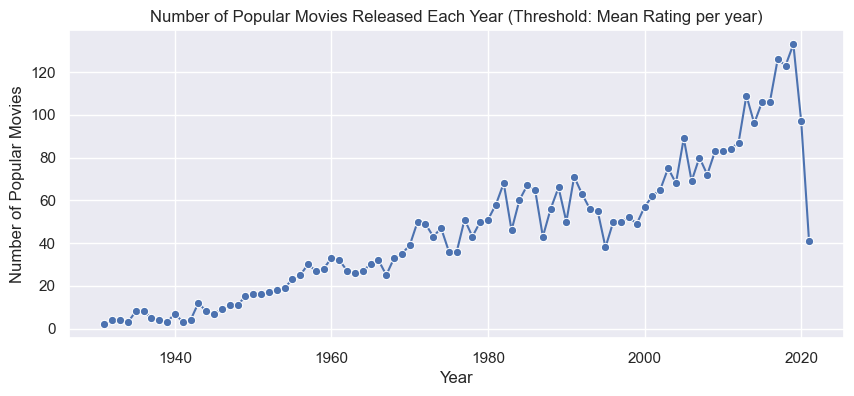

In [386]:
# Checking the number of popular movies each year
# We need to define what is popular
# We can see popular as the movies with a certain rating or above, but from the above explorations
# We know that some years had movies with low ratings
# Considering the mean rating of each year as the threshold for populariry
# We also cannot neglect the number of votes as even low rated movies can ve very polpular
# Decided to check movies based or rating and based on votes with same metrics of mean per year as threshold

mean_rating_per_year = filled_df.groupby('Year')['Rating'].mean().reset_index()

# Merge the mean popularity back into the original dataframe
mean_rated_df = pd.merge(filled_df, mean_rating_per_year, on = 'Year', suffixes=('', '_mean'))

# Use the mean popularity as the threshold
mean_rated_df['IsPopular_Rating'] = mean_rated_df['Rating'] > mean_rated_df['Rating_mean']

# Count the number of popular movies released each year
popular_rated_movies_count = mean_rated_df[mean_rated_df['IsPopular_Rating']].groupby('Year').size().reset_index(name = 'Number of Popular Movies (Rated)')

# Visualize the number of popular movies released each year using a line chart
plt.figure(figsize=(10, 4))
sns.lineplot(x='Year', y='Number of Popular Movies (Rated)', data=popular_rated_movies_count, marker='o', color='b')
plt.title('Number of Popular Movies Released Each Year (Threshold: Mean Rating per year)')
plt.xlabel('Year')
plt.ylabel('Number of Popular Movies')
plt.grid(True)
plt.show()

In [388]:
print(popular_rated_movies_count)

    Year  Number of Popular Movies (Rated)
0   1931                                 2
1   1932                                 4
2   1933                                 4
3   1934                                 3
4   1935                                 8
..   ...                               ...
86  2017                               126
87  2018                               123
88  2019                               133
89  2020                                97
90  2021                                41

[91 rows x 2 columns]


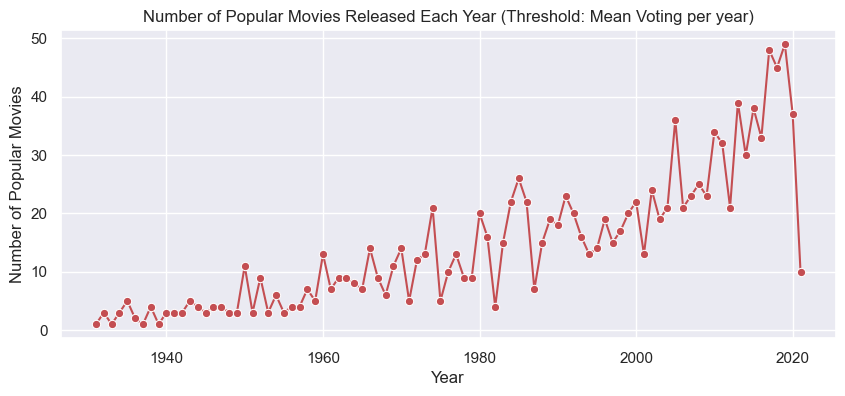

In [390]:
mean_votes_per_year = filled_df.groupby('Year')['Votes'].mean().reset_index()

# Merge the mean popularity back into the original dataframe
mean_voted_df = pd.merge(filled_df, mean_votes_per_year, on = 'Year', suffixes=('', '_mean'))

# Use the mean popularity as the threshold
mean_voted_df['IsPopular_Voting'] = mean_voted_df['Votes'] > mean_voted_df['Votes_mean']

# Count the number of popular movies released each year
popular_voted_movies_count = mean_voted_df[mean_voted_df['IsPopular_Voting']].groupby('Year').size().reset_index(name = 'Number of Popular Movies (Voted)')

# Visualize the number of popular movies released each year using a line chart
plt.figure(figsize=(10, 4))
sns.lineplot(x='Year', y='Number of Popular Movies (Voted)', data=popular_voted_movies_count, marker='o', color='r')
plt.title('Number of Popular Movies Released Each Year (Threshold: Mean Voting per year)')
plt.xlabel('Year')
plt.ylabel('Number of Popular Movies')
plt.grid(True)
plt.show()

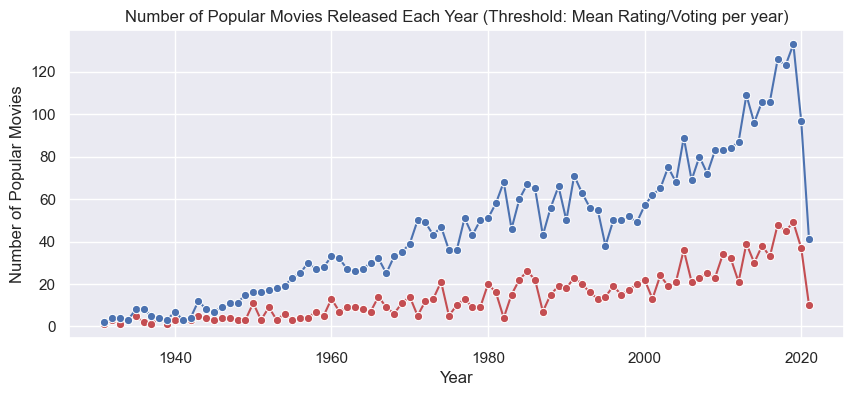

In [392]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Year', y='Number of Popular Movies (Voted)', data=popular_voted_movies_count, marker='o', color='r')
sns.lineplot(x='Year', y='Number of Popular Movies (Rated)', data=popular_rated_movies_count, marker='o', color='b')
plt.title('Number of Popular Movies Released Each Year (Threshold: Mean Rating/Voting per year)')
plt.xlabel('Year')
plt.ylabel('Number of Popular Movies')
plt.grid(True)
plt.show()

- We can see that there is increase in the number of popular movies over the years and specially after the year 2000 we see a considerable increase compared to the previous years.

In [395]:
#### Find the maximum rating for each year

In [397]:

max_rating_per_year = filled_df.groupby('Year')['Rating'].max().reset_index()

# Merge the maximum rating back into the original dataframe
max_rated_df = pd.merge(filled_df, max_rating_per_year, on='Year', suffixes=('', '_max'))

# Count the number of votes for movies that performed better in rating each year
better_movies_votes_per_year = max_rated_df[max_rated_df['Rating'] == max_rated_df['Rating_max']].groupby('Year')['Votes'].sum().reset_index(name = 'Total Votes').sort_values(by = 'Year')

# Count the number of votes for movies that performed better in rating overall
better_movies_votes_overall = max_rated_df[max_rated_df['Rating'] == max_rated_df['Rating_max']].groupby('Name')['Votes'].sum().reset_index(name = 'Total Votes').sort_values(by = 'Total Votes', ascending = False)

print("Number of votes for movies that performed better in rating each year:")
print(better_movies_votes_per_year)

print("\nNumber of votes for movies that performed better in rating overall:")
print(better_movies_votes_overall)

Number of votes for movies that performed better in rating each year:
    Year  Total Votes
0   1917           22
1   1931          124
2   1932           12
3   1933           37
4   1934            6
..   ...          ...
87  2017            5
88  2018            7
89  2019           47
90  2020            5
91  2021            7

[92 rows x 2 columns]

Number of votes for movies that performed better in rating overall:
                           Name  Total Votes
0                      3 Idiots       357889
26           Gangs of Wasseypur        86355
18  Dilwale Dulhania Le Jayenge        65134
35                   Hera Pheri        59545
69             Paan Singh Tomar        34161
..                          ...          ...
59                      Mazdoor            6
87  Sant Ravidas Ki Amar Kahani            6
46                       Laadli            5
51              Love Qubool Hai            5
83                     Ram-Path            5

[106 rows x 2 columns]


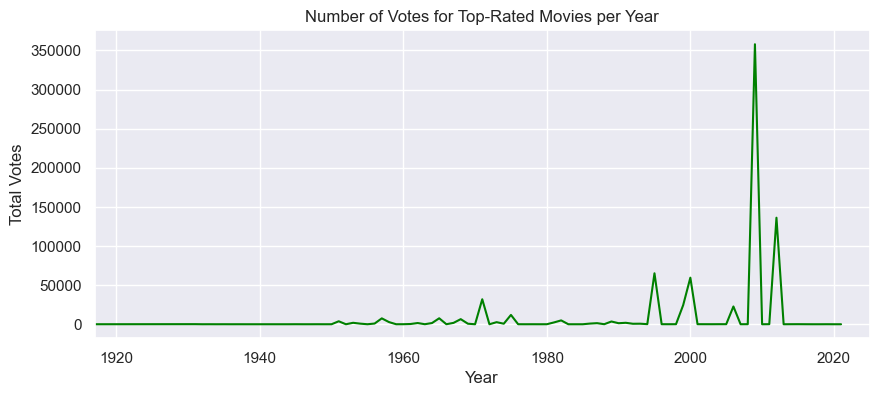

In [403]:
# Visualize the number of votes for movies that performed better in rating per year using a bar plot

plt.figure(figsize = (10, 4))
sns.lineplot(x = 'Year', y = 'Total Votes', data = better_movies_votes_per_year, color = 'green')
plt.title('Number of Votes for Top-Rated Movies per Year')
plt.ylabel('Total Votes')
plt.xlabel('Year')
plt.xlim(left = min(filled_df['Year']), right = 2025)
plt.show()

#### Visualize the number of votes for movies that performed better in rating overall using a bar plot

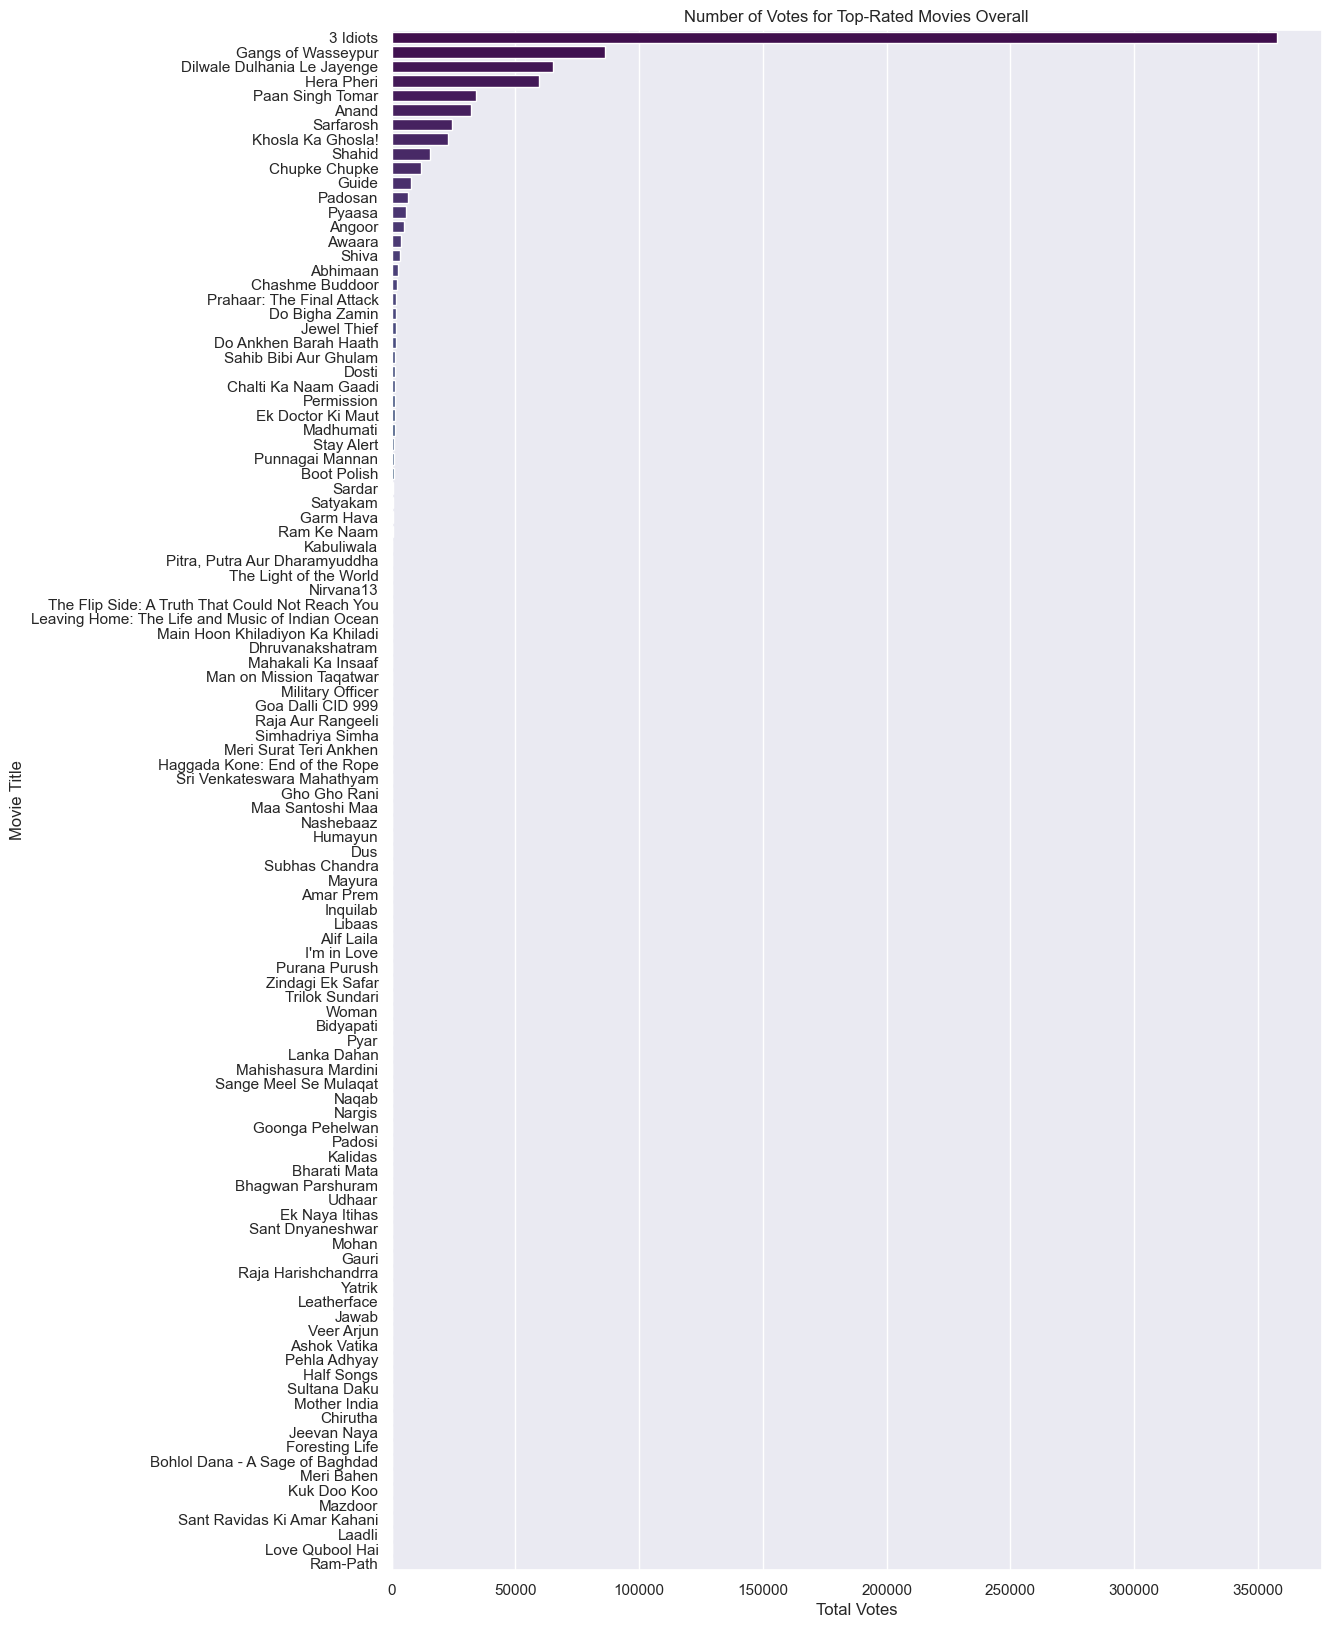

In [406]:
plt.figure(figsize = (12, 20))
sns.barplot(y = 'Name', x = 'Total Votes', data = better_movies_votes_overall, palette = 'viridis')
plt.title('Number of Votes for Top-Rated Movies Overall')
plt.ylabel('Movie Title')
plt.xlabel('Total Votes')
plt.show()

- We see that 3 idiots is by far the mosed voted best rated movie overall in Indian cinema

### Futher Preprocesing and model building

#### Encoding all the categorical values before building the models.
    - If there are alot of unique values, its better to drop the variable, encoding it makes the process more complex and insignificant
    - If there are a few objects, proceed with encoding
    - If there are only two unique values use Label encoder
    - If there are more than 2 unique values use ONE HOT encoder
    - 

#### Encoding all the object datatype variables

In [412]:
obj_list = train_df.select_dtypes(include = ['object']).columns.tolist()
print(obj_list)

['Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre']


#### Analyzing Unique Values in Object Columns to Determine Relevance for Use

In [419]:
for i in obj_list:
    print("Unique values in training dataset for %s column is: %s" % (i, train_df[i].nunique()))

Unique values in training dataset for Name column is: 5612
Unique values in training dataset for Director column is: 2624
Unique values in training dataset for Actor 1 column is: 2104
Unique values in training dataset for Actor 2 column is: 2386
Unique values in training dataset for Actor 3 column is: 2567
Unique values in training dataset for Genre column is: 20


#### Evaluating the Percentage of Unique Values in Each Object Column to Determine Their Relevance

In [423]:
for i in obj_list:
    print("Percentage of unique values in training dataset for %s column is: %s percent" % (i, train_df[i].nunique() / len(train_df) * 100))

Percentage of unique values in training dataset for Name column is: 94.49402256272099 percent
Percentage of unique values in training dataset for Director column is: 44.182522310153225 percent
Percentage of unique values in training dataset for Actor 1 column is: 35.4268395352753 percent
Percentage of unique values in training dataset for Actor 2 column is: 40.175113655497555 percent
Percentage of unique values in training dataset for Actor 3 column is: 43.222764775214685 percent
Percentage of unique values in training dataset for Genre column is: 0.3367570298029971 percent


In [427]:
train_df.head(5)

Name  Year  Duration  Rating  Votes            Director  \
11500                Rahi  1953     139.0     7.0     28  Khwaja Ahmad Abbas   
5167                Gooli  2008     138.0     6.4     80            P. Satya   
4825   Galiyon Ka Badshah  1989     134.0     4.9     29     Sher Jung Singh   
3597       Delhi in a Day  2011      88.0     6.2    395       Prashant Nair   
15080                 WOH  2004     134.0     4.4     40        Raj N. Sippy   

                    Actor 1             Actor 2           Actor 3   Genre  
11500             Dev Anand      Nalini Jaywant      Balraj Sahni   Drama  
5167                 Sudeep      Mamta Mohandas  Kishore Kumar G.  Action  
4825                K. Yogi          Raaj Kumar       Hema Malini   Drama  
3597        Victor Banerjee  Siddharth Bhardwaj     Vidya Bhushan  Comedy  
15080  Priyanshu Chatterjee      Sumeet Goradia       Cleo Isaacs   Crime

In [429]:
# Droping the insignificant variables

train_df = train_df.drop(['Name'], axis = 1)
validation_df = validation_df.drop(['Name'], axis = 1)

train_df.head(5)

Year  Duration  Rating  Votes            Director  \
11500  1953     139.0     7.0     28  Khwaja Ahmad Abbas   
5167   2008     138.0     6.4     80            P. Satya   
4825   1989     134.0     4.9     29     Sher Jung Singh   
3597   2011      88.0     6.2    395       Prashant Nair   
15080  2004     134.0     4.4     40        Raj N. Sippy   

                    Actor 1             Actor 2           Actor 3   Genre  
11500             Dev Anand      Nalini Jaywant      Balraj Sahni   Drama  
5167                 Sudeep      Mamta Mohandas  Kishore Kumar G.  Action  
4825                K. Yogi          Raaj Kumar       Hema Malini   Drama  
3597        Victor Banerjee  Siddharth Bhardwaj     Vidya Bhushan  Comedy  
15080  Priyanshu Chatterjee      Sumeet Goradia       Cleo Isaacs   Crime

In [431]:
validation_df.head(5)

Year  Duration  Rating  Votes        Director              Actor 1  \
12679  2018     104.0     6.8   1117     Harish Vyas  Shivani Raghuvanshi   
12294  1998     126.0     7.5     31   Shyam Benegal   Rajeshwari Sachdev   
6739   2014     142.0     4.9    301     Raj Purohit     Harshvardhan Deo   
348    1980     134.0     4.9     10         Kalidas   Mithun Chakraborty   
5439   1943     134.0     8.2      9  M.I. Dharamsey          Devika Rani   

                 Actor 2         Actor 3   Genre  
12679       Anshuman Jha  Ekavali Khanna   Drama  
12294       Rajit Kapoor    Ravi Jhankal   Drama  
6739       Cherry Mardia  Deepak Chaddha   Drama  
348    Vijayendra Ghatge     Ashok Kumar  Action  
5439             Suraiya   David Abraham   Drama

In [433]:
# Using Target encoding to encode the categorical variables
# As there are a diverese range of categorical variables

categorical_variables = train_df.select_dtypes(include = ['object']).columns.tolist()
encoder = ce.TargetEncoder(cols = categorical_variables)
encoded_df = encoder.fit_transform(train_df[categorical_variables], train_df['Rating'])

In [444]:
encoded_df.columns = [f"{col}_TargetEncoded" for col in categorical_variables]
train_df = pd.concat([train_df, encoded_df], axis = 1)
train_df.head(5)

Year  Duration  Rating  Votes  Director_TargetEncoded  \
11500  1953     139.0     7.0     28                5.998386   
5167   2008     138.0     6.4     80                5.929491   
4825   1989     134.0     4.9     29                5.850732   
3597   2011      88.0     6.2    395                6.035138   
15080  2004     134.0     4.4     40                5.554315   

       Actor 1_TargetEncoded  Actor 2_TargetEncoded  Actor 3_TargetEncoded  \
11500               6.831455               5.865679               6.167203   
5167                5.877261               5.872009               5.929491   
4825                5.734328               6.035590               5.911561   
3597                5.989191               5.903469               5.903469   
15080               5.916825               5.669274               5.669274   

       Genre_TargetEncoded  Director_TargetEncoded  Actor 1_TargetEncoded  \
11500             6.185942                5.998386               6.831455   
5167              5.437335                5.929491               5.877261   
4825              6.185942                5.850732               5.734328   
3597              5.857559                6.035138               5.989191   
15080             6.041985                5.554315               5.916825   

       Actor 2_TargetEncoded  Actor 3_TargetEncoded  Genre_TargetEncoded  \
11500               5.865679               6.167203             6.185942   
5167                5.872009               5.929491             5.437335   
4825                6.035590               5.911561             6.185942   
3597                5.903469               5.903469             5.857559   
15080               5.669274               5.669274             6.041985   

       Director_TargetEncoded  Actor 1_TargetEncoded  Actor 2_TargetEncoded  \
11500                5.998386               6.831455               5.865679   
5167                 5.929491               5.877261               5.872009   
4825                 5.850732               5.734328               6.035590   
3597                 6.035138               5.989191               5.903469   
15080                5.554315               5.916825               5.669274   

       Actor 3_TargetEncoded  Genre_TargetEncoded  
11500               6.167203             6.185942  
5167                5.929491             5.437335  
4825                5.911561             6.185942  
3597                5.903469             5.857559  
15080               5.669274             6.041985

#### Droping the categorical variables and keeping the encoded columns

In [451]:
# Check the column names to ensure the columns exist
print(train_df.columns)

# Drop the columns if they exist
columns_to_drop = ['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre']
train_df = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], axis=1)

# Display the first 5 rows of the dataframe
train_df.head(5)


Index(['Year', 'Duration', 'Rating', 'Votes', 'Director_TargetEncoded',
       'Actor 1_TargetEncoded', 'Actor 2_TargetEncoded',
       'Actor 3_TargetEncoded', 'Genre_TargetEncoded',
       'Director_TargetEncoded', 'Actor 1_TargetEncoded',
       'Actor 2_TargetEncoded', 'Actor 3_TargetEncoded', 'Genre_TargetEncoded',
       'Director_TargetEncoded', 'Actor 1_TargetEncoded',
       'Actor 2_TargetEncoded', 'Actor 3_TargetEncoded',
       'Genre_TargetEncoded'],
      dtype='object')


Year  Duration  Rating  Votes  Director_TargetEncoded  \
11500  1953     139.0     7.0     28                5.998386   
5167   2008     138.0     6.4     80                5.929491   
4825   1989     134.0     4.9     29                5.850732   
3597   2011      88.0     6.2    395                6.035138   
15080  2004     134.0     4.4     40                5.554315   

       Actor 1_TargetEncoded  Actor 2_TargetEncoded  Actor 3_TargetEncoded  \
11500               6.831455               5.865679               6.167203   
5167                5.877261               5.872009               5.929491   
4825                5.734328               6.035590               5.911561   
3597                5.989191               5.903469               5.903469   
15080               5.916825               5.669274               5.669274   

       Genre_TargetEncoded  Director_TargetEncoded  Actor 1_TargetEncoded  \
11500             6.185942                5.998386               6.831455   
5167              5.437335                5.929491               5.877261   
4825              6.185942                5.850732               5.734328   
3597              5.857559                6.035138               5.989191   
15080             6.041985                5.554315               5.916825   

       Actor 2_TargetEncoded  Actor 3_TargetEncoded  Genre_TargetEncoded  \
11500               5.865679               6.167203             6.185942   
5167                5.872009               5.929491             5.437335   
4825                6.035590               5.911561             6.185942   
3597                5.903469               5.903469             5.857559   
15080               5.669274               5.669274             6.041985   

       Director_TargetEncoded  Actor 1_TargetEncoded  Actor 2_TargetEncoded  \
11500                5.998386               6.831455               5.865679   
5167                 5.929491               5.877261               5.872009   
4825                 5.850732               5.734328               6.035590   
3597                 6.035138               5.989191               5.903469   
15080                5.554315               5.916825               5.669274   

       Actor 3_TargetEncoded  Genre_TargetEncoded  
11500               6.167203             6.185942  
5167                5.929491             5.437335  
4825                5.911561             6.185942  
3597                5.903469             5.857559  
15080               5.669274             6.041985

#### Traget encoding the validation df


In [462]:
from category_encoders import TargetEncoder
# Define the encoder and categorical variables list
encoder = TargetEncoder()
categorical_variables = ['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre']  # Add more if needed

# Ensure that all categorical variables exist in the dataframe
valid_categorical_vars = [col for col in categorical_variables if col in validation_df.columns]

# Apply target encoding
encoded_val_df = encoder.fit_transform(validation_df[valid_categorical_vars], validation_df['Rating'])

# Rename columns after encoding
encoded_val_df.columns = [f"{col}_TargetEncoded" for col in valid_categorical_vars]

# Concatenate the encoded columns back to the dataframe
validation_df = pd.concat([validation_df, encoded_val_df], axis=1)

# Drop the original categorical columns if they exist
columns_to_drop = ['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre']
validation_df = validation_df.drop(columns=[col for col in columns_to_drop if col in validation_df.columns], axis=1)

# Display the first few rows to check the results
validation_df.head(5)


Year  Duration  Rating  Votes  Director_TargetEncoded  \
12679  2018     104.0     6.8   1117                5.920663   
12294  1998     126.0     7.5     31                6.067291   
6739   2014     142.0     4.9    301                5.673457   
348    1980     134.0     4.9     10                5.706975   
5439   1943     134.0     8.2      9                6.102815   

       Actor 1_TargetEncoded  Actor 2_TargetEncoded  Actor 3_TargetEncoded  \
12679               5.920663               5.953810               5.920663   
12294               6.011739               6.011739               6.011739   
6739                5.673457               5.673457               5.673457   
348                 5.271714               5.673457               5.929144   
5439                6.102815               6.063762               6.116939   

       Genre_TargetEncoded  
12679             6.134947  
12294             6.134947  
6739              6.134947  
348               5.391610  
5439              6.134947

In [464]:
validation_df.head(5)

Year  Duration  Rating  Votes  Director_TargetEncoded  \
12679  2018     104.0     6.8   1117                5.920663   
12294  1998     126.0     7.5     31                6.067291   
6739   2014     142.0     4.9    301                5.673457   
348    1980     134.0     4.9     10                5.706975   
5439   1943     134.0     8.2      9                6.102815   

       Actor 1_TargetEncoded  Actor 2_TargetEncoded  Actor 3_TargetEncoded  \
12679               5.920663               5.953810               5.920663   
12294               6.011739               6.011739               6.011739   
6739                5.673457               5.673457               5.673457   
348                 5.271714               5.673457               5.929144   
5439                6.102815               6.063762               6.116939   

       Genre_TargetEncoded  
12679             6.134947  
12294             6.134947  
6739              6.134947  
348               5.391610  
5439              6.134947

Now there are no variables of object datatype in our dataframe, now we can feed it to the model

In [467]:
train_df.shape

(5939, 19)

In [469]:
validation_df.shape

(1980, 9)

We see that the number of columns in validation df is lesser than that in the training df because some of genres in trainng dataset is not present in the validation dataset

#### Create a scatter plot with points colored by the 'Rating' column

ValueError: Data must be 1-dimensional, got ndarray of shape (5939, 3) instead

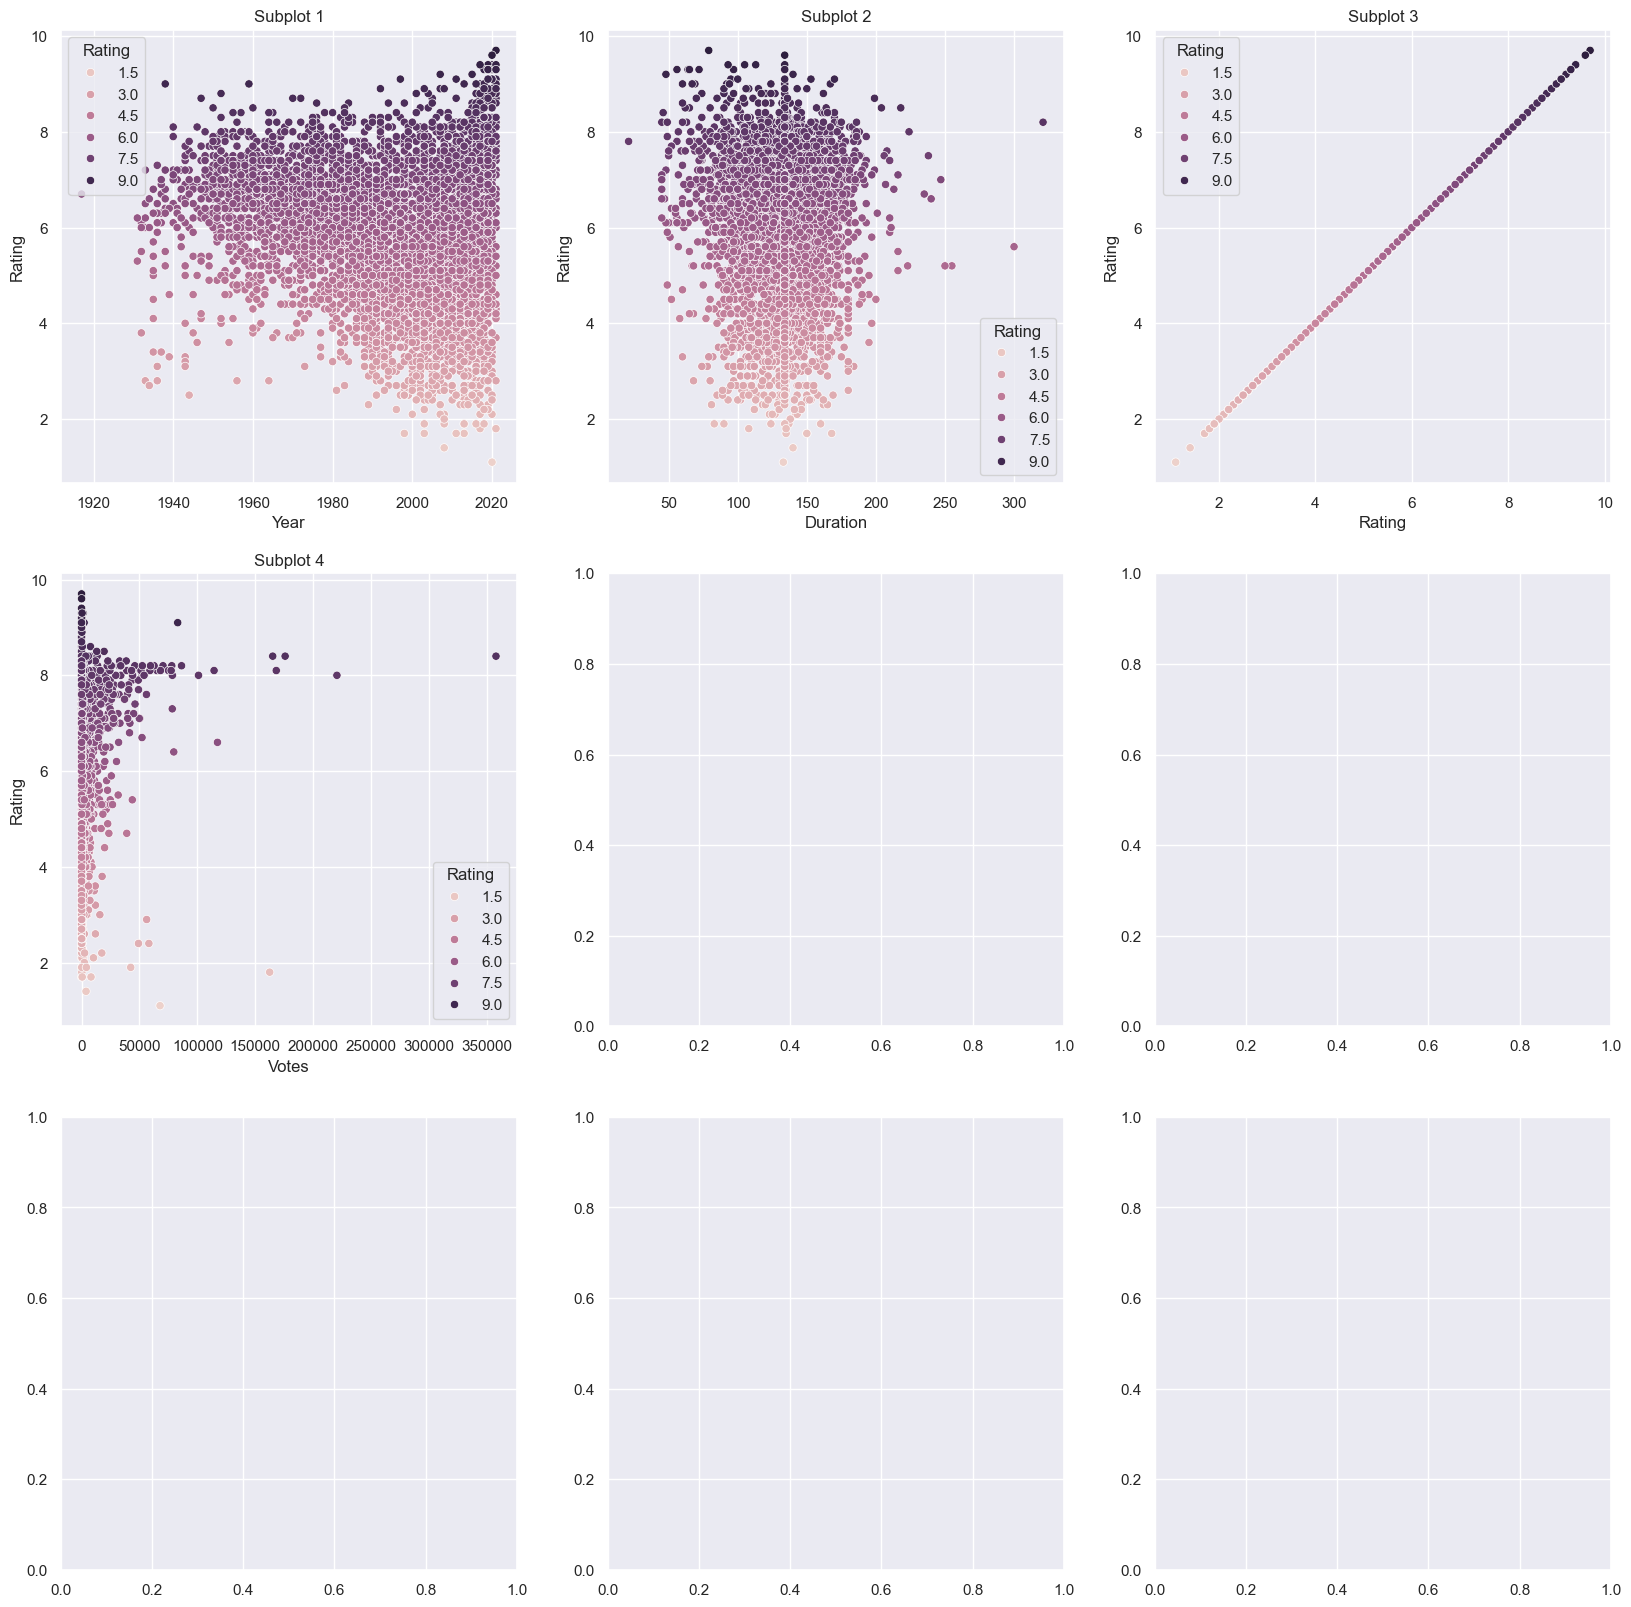

In [485]:
# Exploratory data analysis
# Exploring the signficance of every variable
# Visualising the data to understand the significance


numeric_cols = train_df.select_dtypes(include = np.number)
col_names = list(numeric_cols.columns)
col_index = 0
plt_rows = 3
plt_cols = 3

fig, ax = plt.subplots(nrows = plt_rows, ncols = plt_cols, figsize = (20, 20))
ax = ax.flatten()

for i, ax in enumerate(ax):
#     for col_count in range(plt_cols):
#         ax[row_count][col_count].scatterplot(y = train_df[col_names[col_index]], x = train_df.index, hue = "Rating")
#         ax[row_count][col_count].set_ylabel(col_names[col_index])
#         col_index += 1
    sns.scatterplot(x = train_df[col_names[col_index]], y = train_df['Rating'], data = train_df, hue = "Rating", ax = ax)
    ax.set_title(f'Subplot {i+1}')
    col_index += 1

plt.tight_layout()
plt.show()

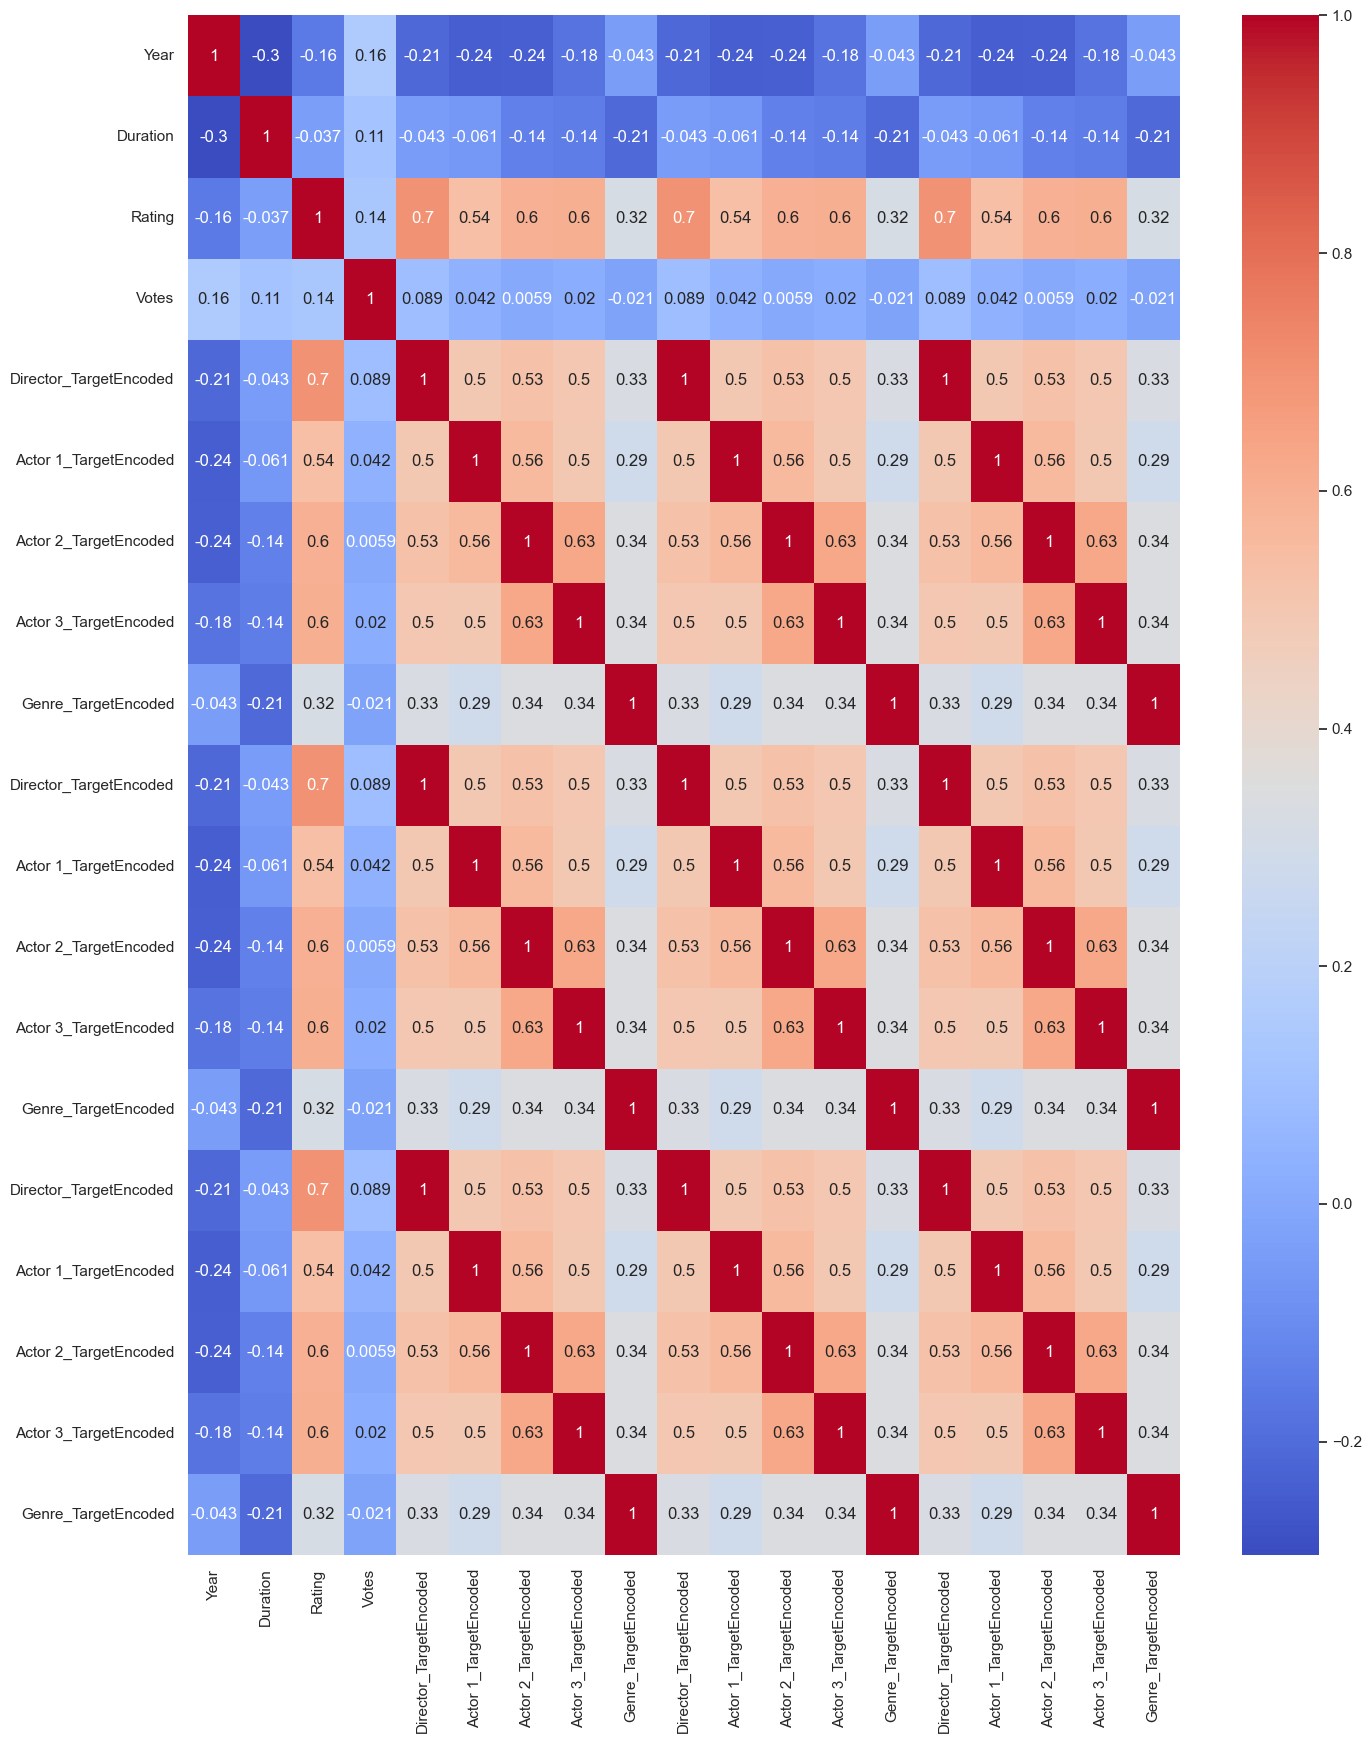

In [487]:
# Checking the heat map

plt.figure(figsize = (16,20))
sns.heatmap(train_df.corr(), annot = True, cmap = 'coolwarm')
plt.show()

- There is not much high correlation or auto correlation
- Duration has very low correlation with Rating and Votes is also pretty low
- We can proceed with the dataset for model building

In [496]:
# Splitting dependent and independent variable

raw_x_train = train_df.drop(['Rating'], axis = 1)
raw_y_train = train_df['Rating']

raw_x_val = validation_df.drop(['Rating'], axis = 1)
raw_y_val = validation_df['Rating']

raw_x_train.head(5)

Year  Duration  Votes  Director_TargetEncoded  Actor 1_TargetEncoded  \
11500  1953     139.0     28                5.998386               6.831455   
5167   2008     138.0     80                5.929491               5.877261   
4825   1989     134.0     29                5.850732               5.734328   
3597   2011      88.0    395                6.035138               5.989191   
15080  2004     134.0     40                5.554315               5.916825   

       Actor 2_TargetEncoded  Actor 3_TargetEncoded  Genre_TargetEncoded  \
11500               5.865679               6.167203             6.185942   
5167                5.872009               5.929491             5.437335   
4825                6.035590               5.911561             6.185942   
3597                5.903469               5.903469             5.857559   
15080               5.669274               5.669274             6.041985   

       Director_TargetEncoded  Actor 1_TargetEncoded  Actor 2_TargetEncoded  \
11500                5.998386               6.831455               5.865679   
5167                 5.929491               5.877261               5.872009   
4825                 5.850732               5.734328               6.035590   
3597                 6.035138               5.989191               5.903469   
15080                5.554315               5.916825               5.669274   

       Actor 3_TargetEncoded  Genre_TargetEncoded  Director_TargetEncoded  \
11500               6.167203             6.185942                5.998386   
5167                5.929491             5.437335                5.929491   
4825                5.911561             6.185942                5.850732   
3597                5.903469             5.857559                6.035138   
15080               5.669274             6.041985                5.554315   

       Actor 1_TargetEncoded  Actor 2_TargetEncoded  Actor 3_TargetEncoded  \
11500               6.831455               5.865679               6.167203   
5167                5.877261               5.872009               5.929491   
4825                5.734328               6.035590               5.911561   
3597                5.989191               5.903469               5.903469   
15080               5.916825               5.669274               5.669274   

       Genre_TargetEncoded  
11500             6.185942  
5167              5.437335  
4825              6.185942  
3597              5.857559  
15080             6.041985

In [508]:
raw_x_val.head(5)

Year  Duration  Votes  Director_TargetEncoded  Actor 1_TargetEncoded  \
12679  2018     104.0   1117                5.920663               5.920663   
12294  1998     126.0     31                6.067291               6.011739   
6739   2014     142.0    301                5.673457               5.673457   
348    1980     134.0     10                5.706975               5.271714   
5439   1943     134.0      9                6.102815               6.102815   

       Actor 2_TargetEncoded  Actor 3_TargetEncoded  Genre_TargetEncoded  
12679               5.953810               5.920663             6.134947  
12294               6.011739               6.011739             6.134947  
6739                5.673457               5.673457             6.134947  
348                 5.673457               5.929144             5.391610  
5439                6.063762               6.116939             6.134947

In [514]:
# Function to find the best value of K based on mean squared error

def find_k(x_train, y_train, x_test, y_test):
    error_rate = []    # Finding the error rate for 50 iterations

    for i in range(1, 50):
        knn = KNeighborsRegressor(n_neighbors = i)    # Building the model with i neighbors
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(mean_squared_error(y_test, y_pred))
    
# Ploting the error values to find the best value of k
    
    plt.figure(figsize = (8, 8))
    plt.plot(range(1,50), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markersize = 10, markerfacecolor = 'blue')
    plt.title("Mean Squared Error vs K-Value")
    plt.xlabel("K-Value")
    plt.ylabel("Mean Squared Error")
    plt.show()

In [135]:
# Building KNN regressor with k = 11
knn_raw = KNeighborsRegressor(n_neighbors = 11)
knn_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_knn = knn_raw.predict(raw_x_train)
raw_y_pred_val_knn = knn_raw.predict(raw_x_val)

print("Accuracy Scores for KNN Regressor model on raw data")
raw_knn_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_knn)
raw_train_knn_r2s = r2_score(raw_y_train, raw_y_pred_train_knn)
raw_val_knn_r2s = r2_score(raw_y_val, raw_y_pred_val_knn)
print("Mean Squared Error :", raw_knn_rmse)
print("R-squared Score (Train) :", raw_train_knn_r2s)
print("R-squared Score (Test) :", raw_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on raw data
Mean Squared Error : 1.477971533516988
R-squared Score (Train) : 0.33046720097840265
R-squared Score (Test) : 0.21572776813994943
**************************************************************************************************


In [136]:
# Function for checking the best model out of the tested models for correlation treated dataset

def check_scores(mse_list, r2_train_list, r2_test_list, data):
    models_list = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net Regression', "Decission Tree Regression",
                   'Random Forest Regression', 'Gradient Boosting Regression', 'LGBoost Regression', 'XGBoost Regression', 
                   'K Nearest Neighbour', 'SVR - Linear', 'SVR - Polynomial', 'SVR - Sigmoid', 'SVR - RBF']

    accuracy = pd.DataFrame({'Method' : models_list, 'Mean Squared Error' : mse_list, 'R2Score(Training)' : r2_train_list,
                           'R2Score(Testing)' : r2_test_list})

    sns.lineplot(x = 'Method', y = 'Mean Squared Error', data = accuracy, label = 'MSE', color = 'green', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'green')
    sns.lineplot(x = 'Method', y = 'R2Score(Training)', data = accuracy, label = 'R2Train', color = 'blue', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'blue')
    sns.lineplot(x = 'Method', y = 'R2Score(Testing)', data = accuracy, label = 'R2Test', color = 'brown', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'brown')
    plt.xticks(rotation = 90)
    plt.title("Accuracy on %s dataset" % data)
    plt.ylim(0.0, 1.0)
    plt.axhline(y = 0.7, linewidth = 1, color = 'red')
    plt.show()

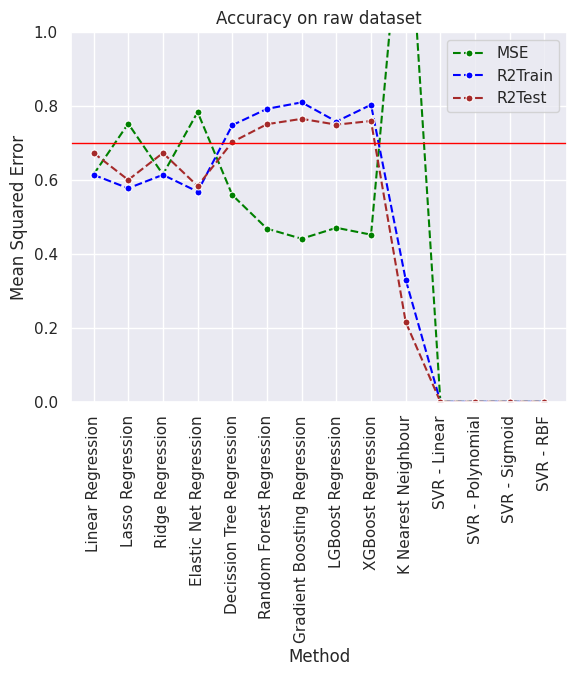

In [137]:
# Checking the accuracy of models on raw data

raw_mse_list = [raw_lr_rmse, raw_lar_rmse, raw_ridge_rmse, raw_enet_rmse, raw_dtree_rmse, raw_rf_rmse, raw_gb_rmse, raw_lgb_rmse,
                raw_xgb_rmse, raw_knn_rmse, 0, 0, 0, 0]

raw_r2_train_list = [raw_train_lr_r2s, raw_train_lar_r2s, raw_train_ridge_r2s, raw_train_enet_r2s, raw_train_dtree_r2s,
                    raw_train_rf_r2s, raw_train_gb_r2s, raw_train_lgb_r2s, raw_train_xgb_r2s, raw_train_knn_r2s, 0, 0, 0, 0]

raw_r2_test_list = [raw_val_lr_r2s, raw_val_lar_r2s, raw_val_ridge_r2s, raw_val_enet_r2s, raw_val_dtree_r2s, raw_val_rf_r2s,
                   raw_val_gb_r2s, raw_val_lgb_r2s, raw_val_xgb_r2s, raw_val_knn_r2s, 0, 0, 0, 0]

check_scores(raw_mse_list, raw_r2_train_list, raw_r2_test_list, 'raw')

- Ensemble models like Random Forest, Gradient Boost Regressor, LightGBM, and XGBoost show good performance with relatively low MSE and high R-squared scores on the test set.
- Decision Tree performs well but may have a slightly higher MSE compared to ensemble methods.
- Linear Regression and Ridge Regression show similar performance, indicating that L2 regularization might be more suitable for the data.
- Lasso Regression and Elastic Net Regression seem to have slightly higher MSE and lower R-squared scores compared to other models.
- KNN Regressor appears to perform less well on the dataset, with a higher MSE and lower R-squared scores.
- Checking the above we can see that Random Forest, Gradient Boosting, LGBoost and XGBoost have all performed better
- They all have men squared erros less than 0.5 
- All four hae r2 score of more than 0.75 for both train and test

#### Handling outliers to see if accuracy can be improved

In [138]:
# Checking for outliers

olt_x_train = raw_x_train
olt_y_train = train_df['Rating'] 

olt_x_val = raw_x_val
olt_y_val = validation_df['Rating'] 

olt_x_train.head(2)

Year  Duration  Votes  Director_TargetEncoded  Actor 1_TargetEncoded  \
11500  1953     139.0     28                5.998386               6.831455   
5167   2008     138.0     80                5.929491               5.877261   

       Actor 2_TargetEncoded  Actor 3_TargetEncoded  Genre_TargetEncoded  
11500               5.865679               6.167203             6.185942  
5167                5.872009               5.929491             5.437335

In [139]:
olt_x_val.head(2)

Year  Duration  Votes  Director_TargetEncoded  Actor 1_TargetEncoded  \
12679  2018     104.0   1117                5.920663               5.920663   
12294  1998     126.0     31                6.067291               6.011739   

       Actor 2_TargetEncoded  Actor 3_TargetEncoded  Genre_TargetEncoded  
12679               5.953810               5.920663             6.134947  
12294               6.011739               6.011739             6.134947

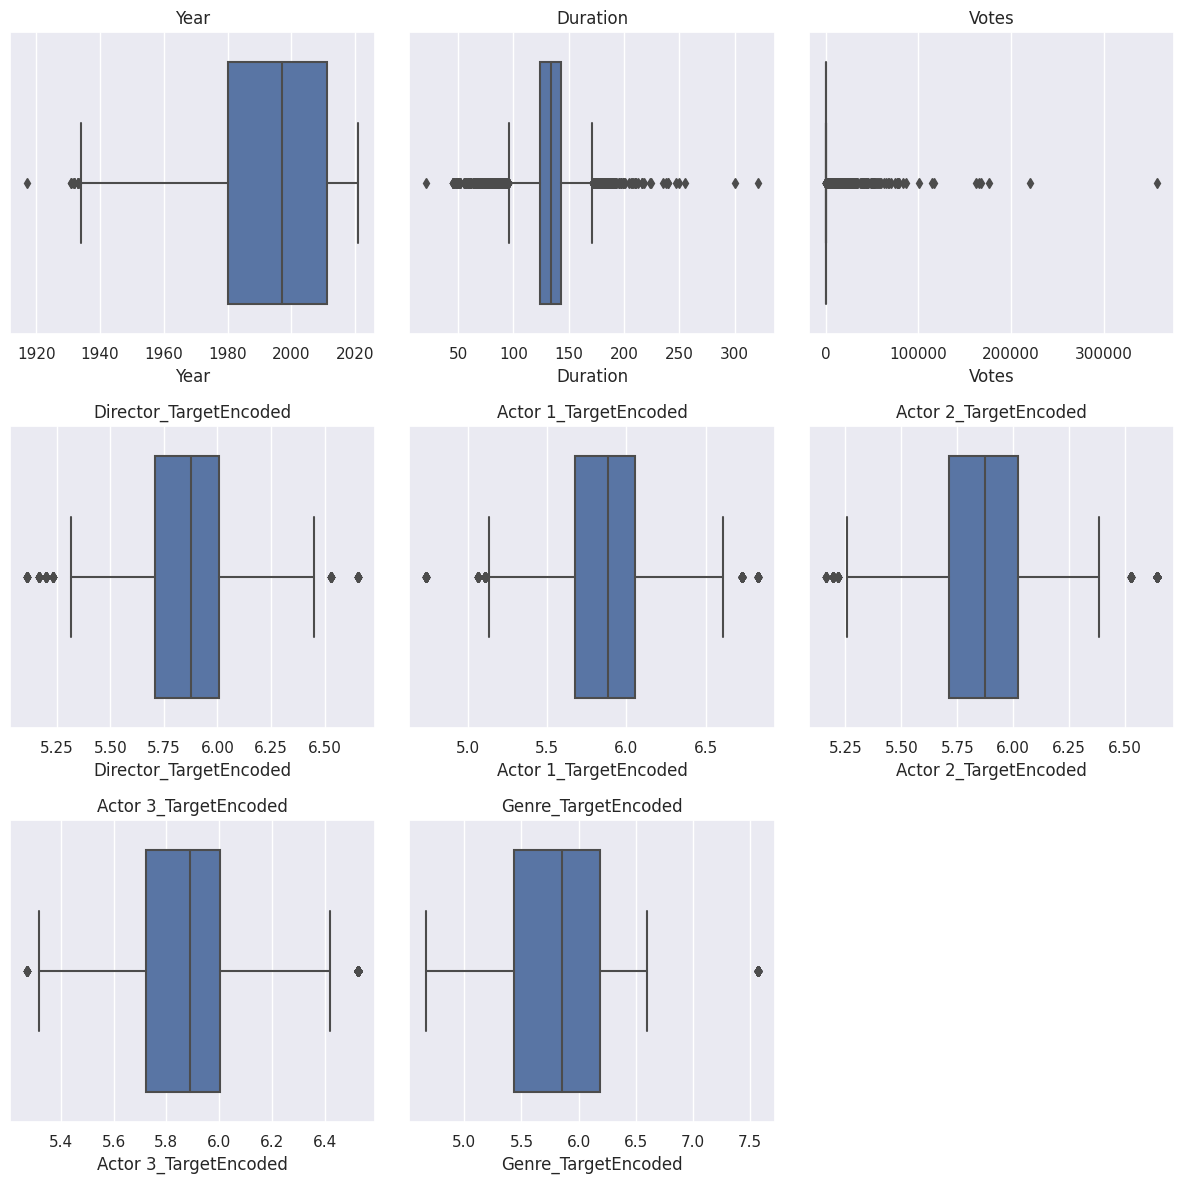

In [140]:
# Checking for outliers using boxplots

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

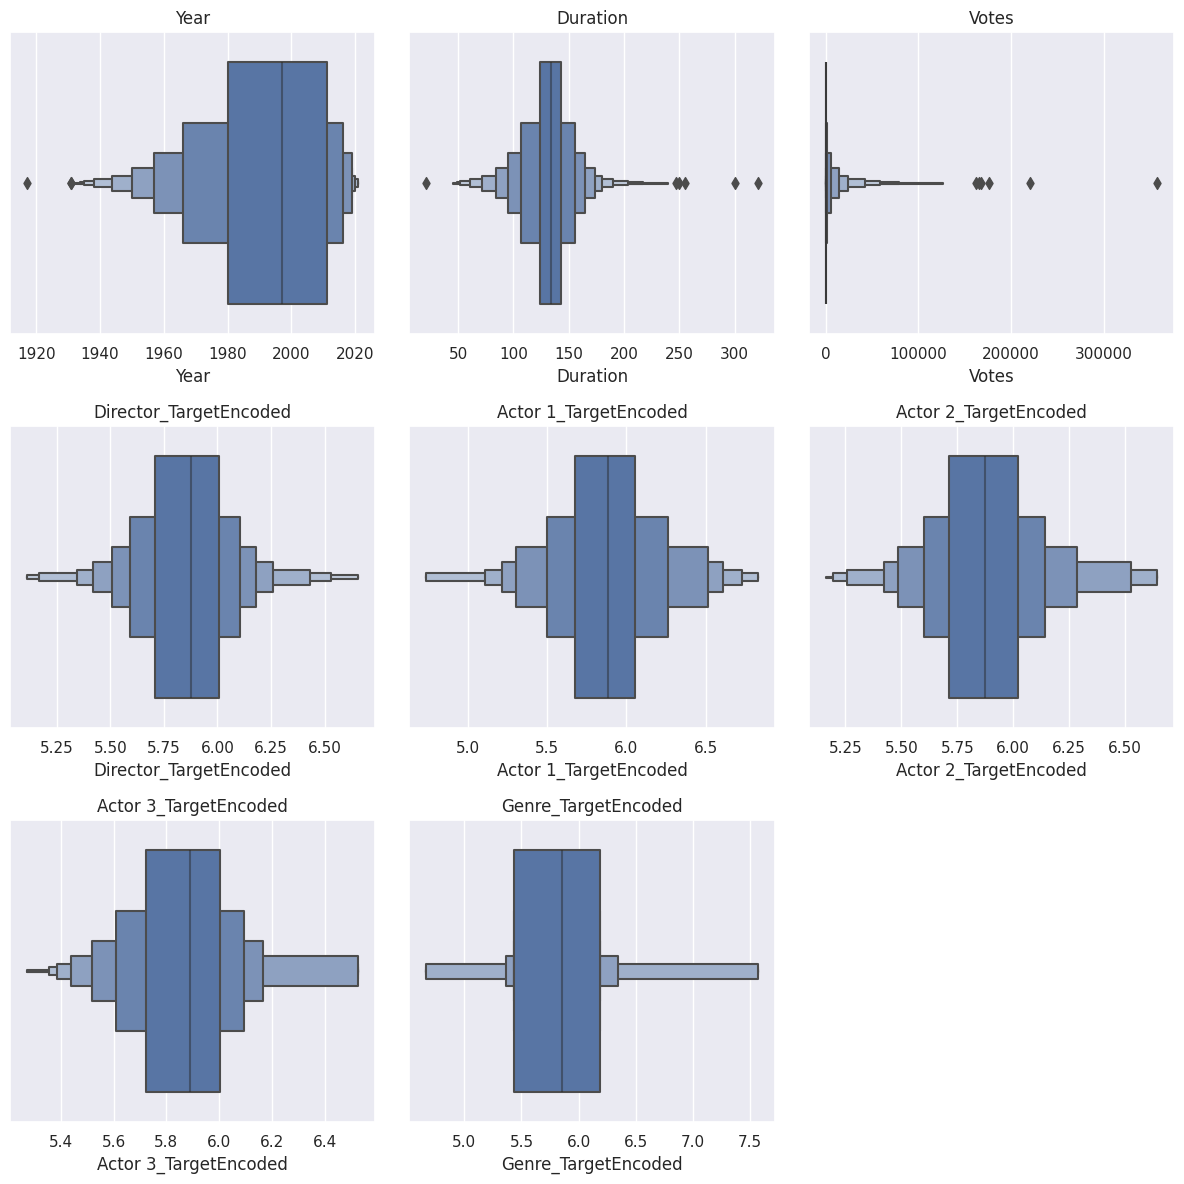

In [141]:
# Checking for outliers using boxen plot

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxenplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

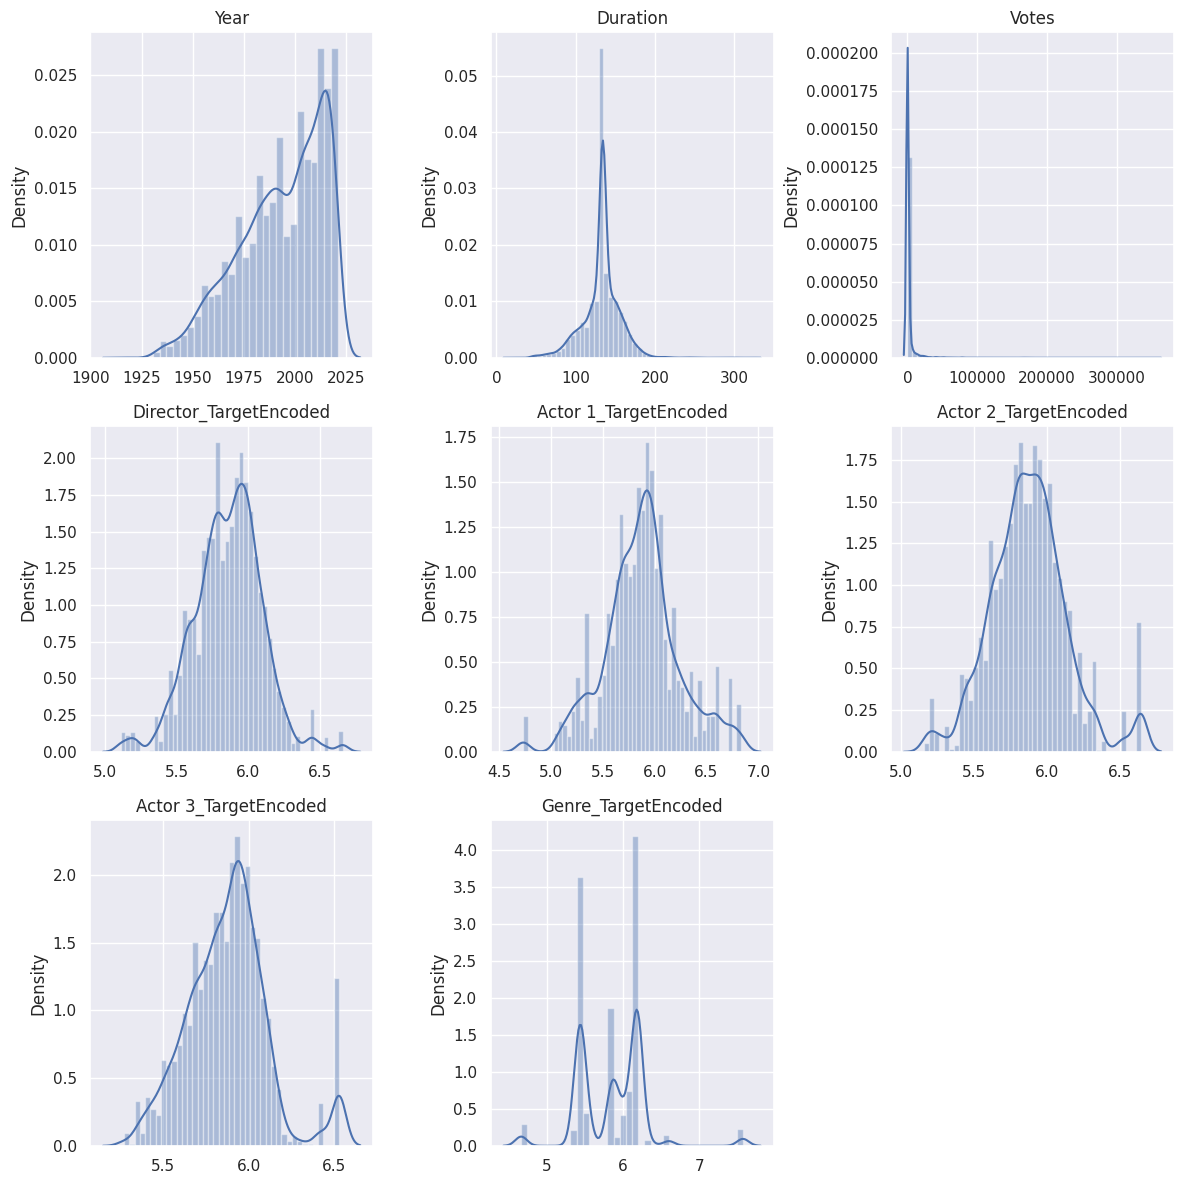

In [142]:
# Checking for outliers using dist plot

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.distplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

- We see outliers and skewness throughout the dataset
    - Using IQR method on all columns except Year
- Building the prediction models after treating the outliers.

In [143]:
# Outlier treatment

out_list = ['Duration', 'Votes', 'Director_TargetEncoded', 'Actor 1_TargetEncoded', 'Actor 2_TargetEncoded',
            'Actor 3_TargetEncoded', 'Genre_TargetEncoded']

for i in olt_x_train.columns:
    col_q1 = olt_x_train[i].quantile(0.25)
    col_q3 = olt_x_train[i].quantile(0.75)
    col_iqr = col_q3 - col_q1
    
    upper_limit = col_q3 + (1.5 * col_iqr)
    lower_limit = col_q1 - (1.5 * col_iqr)
    
    if i in out_list:
        olt_x_train[i] = np.where(olt_x_train[i] > upper_limit, upper_limit, 
                                   np.where(olt_x_train[i] < lower_limit, lower_limit, olt_x_train[i]))

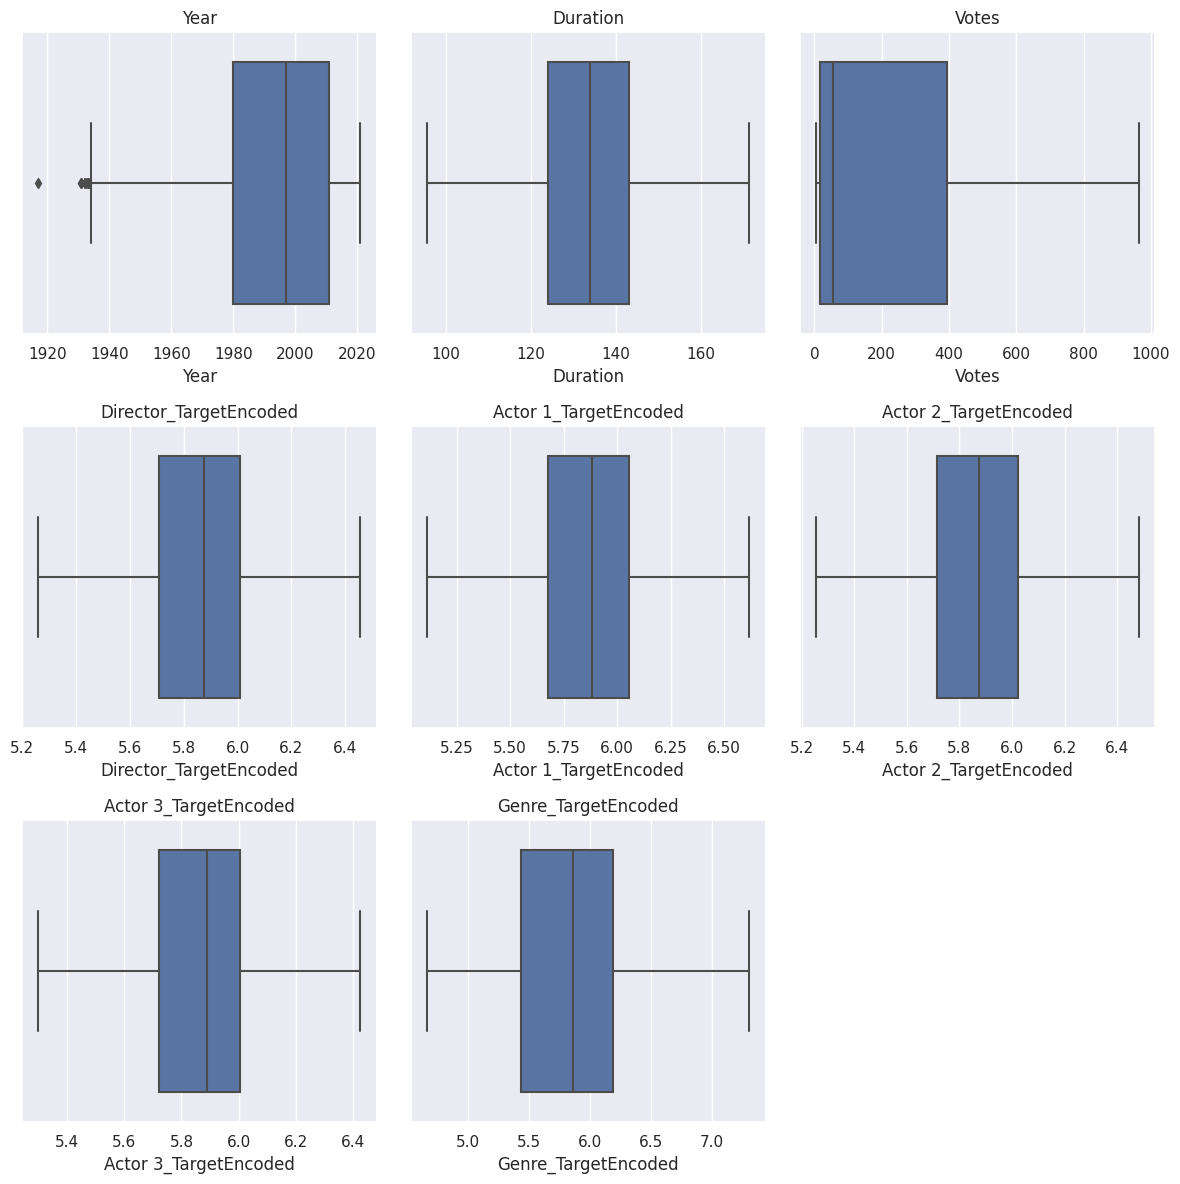

In [144]:
# Checking the visuals to see if the outliers are fixed

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

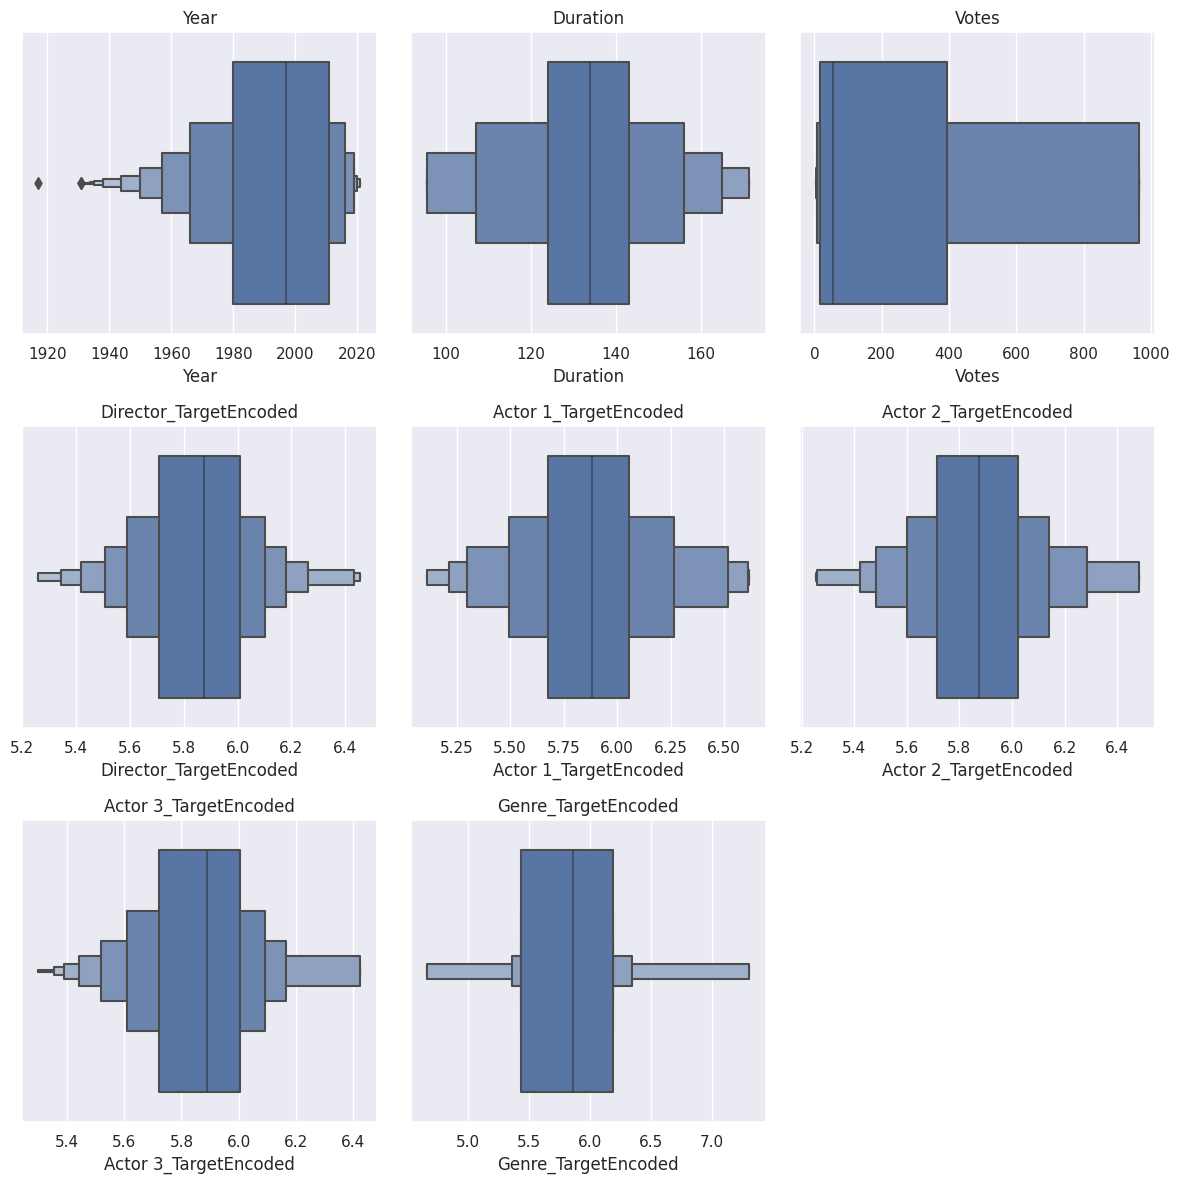

In [145]:
# Checking for outliers using boxen plot

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxenplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

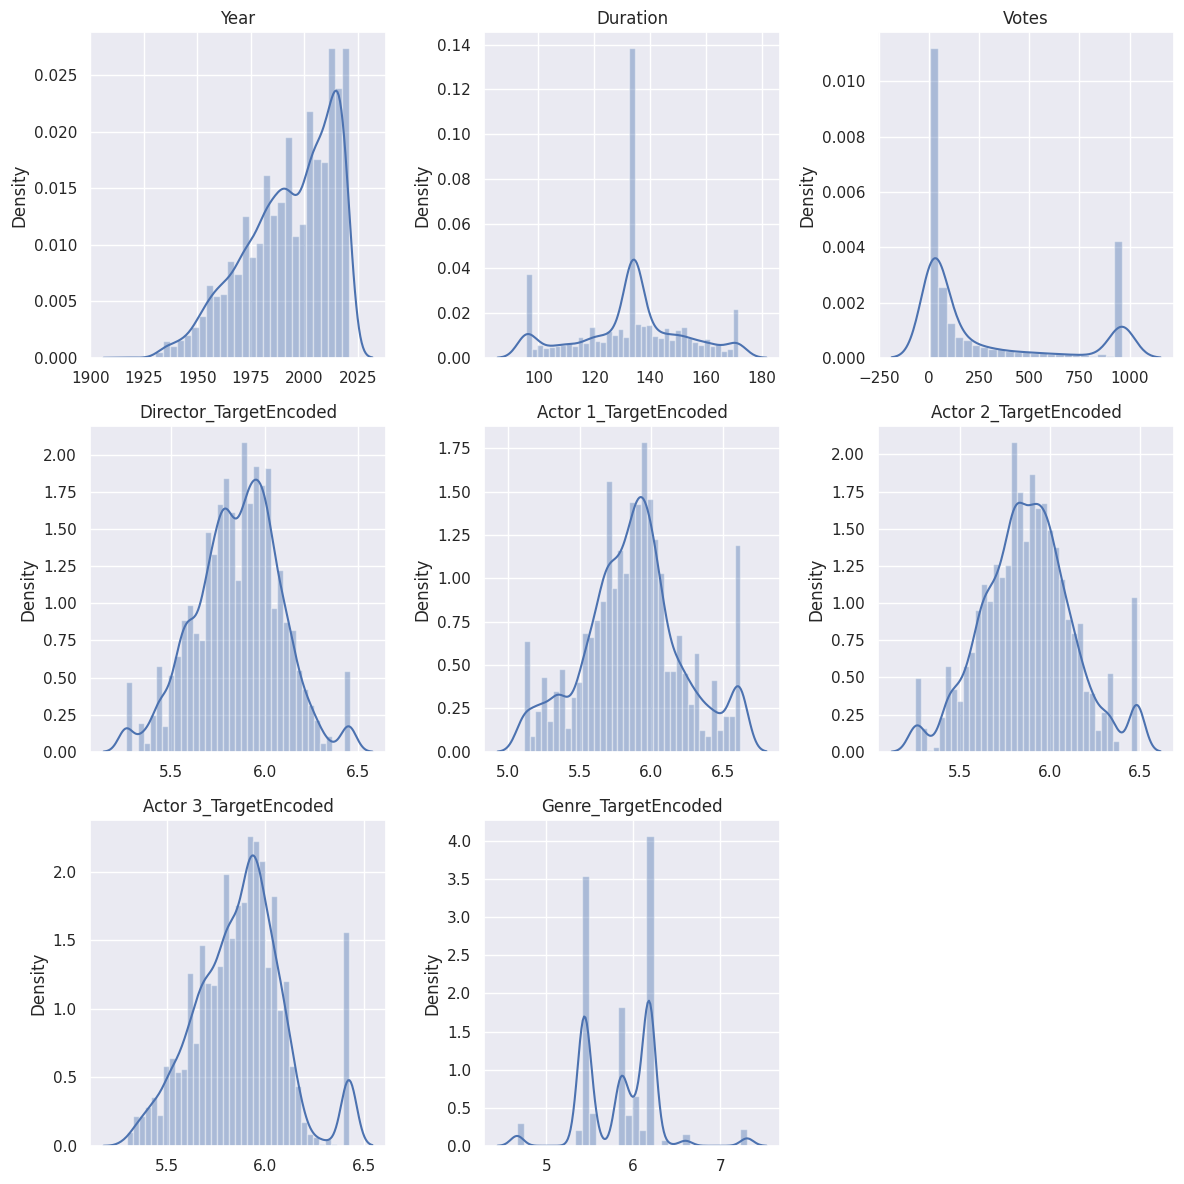

In [146]:
# Checking for outliers using dist plot

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.distplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [147]:
# Using the same treatment on the validation dataset

for i in olt_x_val.columns:
    col_q1 = olt_x_val[i].quantile(0.25)
    col_q3 = olt_x_val[i].quantile(0.75)
    col_iqr = col_q3 - col_q1
    
    upper_limit = col_q3 + (1.5 * col_iqr)
    lower_limit = col_q1 - (1.5 * col_iqr)
    
    if i in out_list:
        olt_x_val[i] = np.where(olt_x_val[i] > upper_limit, upper_limit, 
                                   np.where(olt_x_val[i] < lower_limit, lower_limit, olt_x_val[i]))

#### Building the models on outlier treated data

In [148]:
# Building the models

# Linear Regression model
linear_model_olt = LinearRegression()
linear_model_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_lr = linear_model_olt.predict(olt_x_train)
olt_y_pred_val_lr = linear_model_olt.predict(olt_x_val)

print("Accuracy Scores for Linear Regression model on outlier treated data")
olt_lr_mse = mean_squared_error(olt_y_val, olt_y_pred_val_lr)
olt_train_lr_r2s = r2_score(olt_y_train, olt_y_pred_train_lr)
olt_val_lr_r2s = r2_score(olt_y_val, olt_y_pred_val_lr)
print("Mean Squared Error :", olt_lr_mse)
print("R-squared Score (Train) :", olt_train_lr_r2s)
print("R-squared Score (Test) :", olt_val_lr_r2s)
print("**************" * 7)

# Lasso Regression (L1 Regularization) going with alpha = 0.05, after checking various values
lasso_model_olt = Lasso(alpha = 0.05)
lasso_model_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_lar = lasso_model_olt.predict(olt_x_train)
olt_y_pred_val_lar = lasso_model_olt.predict(olt_x_val)

print("Accuracy Scores for Lasso Regression (L1 Regularization) model on outlier treated data")
olt_lar_mse = mean_squared_error(olt_y_val, olt_y_pred_val_lar)
olt_train_lar_r2s = r2_score(olt_y_train, olt_y_pred_train_lar)
olt_val_lar_r2s = r2_score(olt_y_val, olt_y_pred_val_lar)
print("Mean Squared Error :", olt_lar_mse)
print("R-squared Score (Train) :", olt_train_lar_r2s)
print("R-squared Score (Test) :", olt_val_lar_r2s)
print("**************" * 7)

# Ridge Regression (L2 Regularization) going with alpha = 0.05, after checking various values
ridge_model_olt = Ridge(alpha = 0.05)
ridge_model_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_ridge = ridge_model_olt.predict(olt_x_train)
olt_y_pred_val_ridge = ridge_model_olt.predict(olt_x_val)

print("Accuracy Scores for Ridge Regression (L2 Regularization) model on outlier treated data")
olt_ridge_mse = mean_squared_error(olt_y_val, olt_y_pred_val_ridge)
olt_train_ridge_r2s = r2_score(olt_y_train, olt_y_pred_train_ridge)
olt_val_ridge_r2s = r2_score(olt_y_val, olt_y_pred_val_ridge)
print("Mean Squared Error :", olt_ridge_mse)
print("R-squared Score (Train) :", olt_train_ridge_r2s)
print("R-squared Score (Test) :", olt_val_ridge_r2s)
print("**************" * 7)

# Elastic Net Regression (L1 and L2 Regularizations) going with alpha = 0.05, after checking various values
enet_model_olt = ElasticNet(alpha = 0.05, random_state = 101)
enet_model_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_enet = enet_model_olt.predict(olt_x_train)
olt_y_pred_val_enet = enet_model_olt.predict(olt_x_val)

print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on outlier treated data")
olt_enet_mse = mean_squared_error(olt_y_val, olt_y_pred_val_enet)
olt_train_enet_r2s = r2_score(olt_y_train, olt_y_pred_train_enet)
olt_val_enet_r2s = r2_score(olt_y_val, olt_y_pred_val_enet)
print("Mean Squared Error :", olt_enet_mse)
print("R-squared Score (Train) :", olt_train_enet_r2s)
print("R-squared Score (Test) :", olt_val_enet_r2s)
print("**************" * 7)

# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree_olt = DecisionTreeRegressor(max_depth = 6)
dtree_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_dtree = dtree_olt.predict(olt_x_train)
olt_y_pred_val_dtree = dtree_olt.predict(olt_x_val)

print("Accuracy Scores for Decision Tree model on outlier treated data")
olt_dtree_mse = mean_squared_error(olt_y_val, olt_y_pred_val_dtree)
olt_train_dtree_r2s = r2_score(olt_y_train, olt_y_pred_train_dtree)
olt_val_dtree_r2s = r2_score(olt_y_val, olt_y_pred_val_dtree)
print("Mean Squared Error :", olt_dtree_mse)
print("R-squared Score (Train) :", olt_train_dtree_r2s)
print("R-squared Score (Test) :", olt_val_dtree_r2s)
print("**************" * 7)

# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_olt = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 6)
rf_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_rf = rf_olt.predict(olt_x_train)
olt_y_pred_val_rf = rf_olt.predict(olt_x_val)

print("Accuracy Scores for Random Forest model on outlier treated data")
olt_rf_mse = mean_squared_error(olt_y_val, olt_y_pred_val_rf)
olt_train_rf_r2s = r2_score(olt_y_train, olt_y_pred_train_rf)
olt_val_rf_r2s = r2_score(olt_y_val, olt_y_pred_val_rf)
print("Mean Squared Error :", olt_rf_mse)
print("R-squared Score (Train) :", olt_train_rf_r2s)
print("R-squared Score (Test) :", olt_val_rf_r2s)
print("**************" * 7)

# Gradient Boosting Regression model
gb_olt = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 123)
gb_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_gb = gb_olt.predict(olt_x_train)
olt_y_pred_val_gb = gb_olt.predict(olt_x_val)

print("Accuracy Scores for Gradient Boost Regressor model on outlier treated data")
olt_gb_mse = mean_squared_error(olt_y_val, olt_y_pred_val_gb)
olt_train_gb_r2s = r2_score(olt_y_train, olt_y_pred_train_gb)
olt_val_gb_r2s = r2_score(olt_y_val, olt_y_pred_val_gb)
print("Mean Squared Error :", olt_gb_mse)
print("R-squared Score (Train) :", olt_train_gb_r2s)
print("R-squared Score (Test) :", olt_val_gb_r2s)
print("**************" * 7)

# LGBoost Regression model - Max depth and Num_leaves = 3 after testing various values
lgb_olt = lgb.LGBMRegressor(random_state = 11, max_depth = 3, num_leaves = 3, force_col_wise = True)
lgb_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_lgb = lgb_olt.predict(olt_x_train)
olt_y_pred_val_lgb = lgb_olt.predict(olt_x_val)

print("Accuracy Scores for LGBoost model on outlier treated data")
olt_lgb_mse = mean_squared_error(olt_y_val, olt_y_pred_val_lgb)
olt_train_lgb_r2s = r2_score(olt_y_train, olt_y_pred_train_lgb)
olt_val_lgb_r2s = r2_score(olt_y_val, olt_y_pred_val_lgb)
print("Mean Squared Error :", olt_lgb_mse)
print("R-squared Score (Train) :", olt_train_lgb_r2s)
print("R-squared Score (Test) :", olt_val_lgb_r2s)
print("**************" * 7)

# XGBoost Regression model - Max depth = 2 after testing various values
xgb_olt = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_xgb = xgb_olt.predict(olt_x_train)
olt_y_pred_val_xgb = xgb_olt.predict(olt_x_val)

print("Accuracy Scores for XGBoost model on outlier treated data")
olt_xgb_mse = mean_squared_error(olt_y_val, olt_y_pred_val_xgb)
olt_train_xgb_r2s = r2_score(olt_y_train, olt_y_pred_train_xgb)
olt_val_xgb_r2s = r2_score(olt_y_val, olt_y_pred_val_xgb)
print("Mean Squared Error :", olt_xgb_mse)
print("R-squared Score (Train) :", olt_train_xgb_r2s)
print("R-squared Score (Test) :", olt_val_xgb_r2s)
print("**************" * 7)

# Support Vector Regression model - Linear kernel
# It is computationaly very expensive and gives very poor results also, as below

# svr_linear_olt = SVR(kernel = 'linear')
# svr_linear_olt.fit(olt_x_train, olt_y_train)
# olt_y_pred_train_svr_linear = svr_linear_olt.predict(olt_x_train)
# olt_y_pred_val_svr_linear = svr_linear_olt.predict(olt_x_val)
# Accuracy Scores for Support Vector Model with linear kernel on outlier treated data
# Root Mean Squared Error : 1.3067999090336686
# R-squared Score (Train) : 0.31752905572919654
# R-squared Score (Test) : 0.306558443102405
# print("Accuracy Scores for Support Vector Model with linear kernel on outlier treated data")
# olt_svr_linear_mse = mean_squared_error(olt_y_val, olt_y_pred_val_svr_linear)
# olt_train_svr_linear_r2s = r2_score(olt_y_train, olt_y_pred_train_svr_linear)
# olt_val_svr_linear_r2s = r2_score(olt_y_val, olt_y_pred_val_svr_linear)
# print("Root Mean Squared Error :", olt_svr_linear_mse)
# print("R-squared Score (Train) :", olt_train_svr_linear_r2s)
# print("R-squared Score (Test) :", olt_val_svr_linear_r2s)
# print("**************" * 7)

Accuracy Scores for Linear Regression model on outlier treated data
Mean Squared Error : 0.5593675244734696
R-squared Score (Train) : 0.6413849502755762
R-squared Score (Test) : 0.70317668040269
**************************************************************************************************
Accuracy Scores for Lasso Regression (L1 Regularization) model on outlier treated data
Mean Squared Error : 0.6893618018299242
R-squared Score (Train) : 0.6028758338835392
R-squared Score (Test) : 0.6341963924070353
**************************************************************************************************
Accuracy Scores for Ridge Regression (L2 Regularization) model on outlier treated data
Mean Squared Error : 0.5593966271742087
R-squared Score (Train) : 0.6413849437092504
R-squared Score (Test) : 0.7031612373176614
**************************************************************************************************
Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model

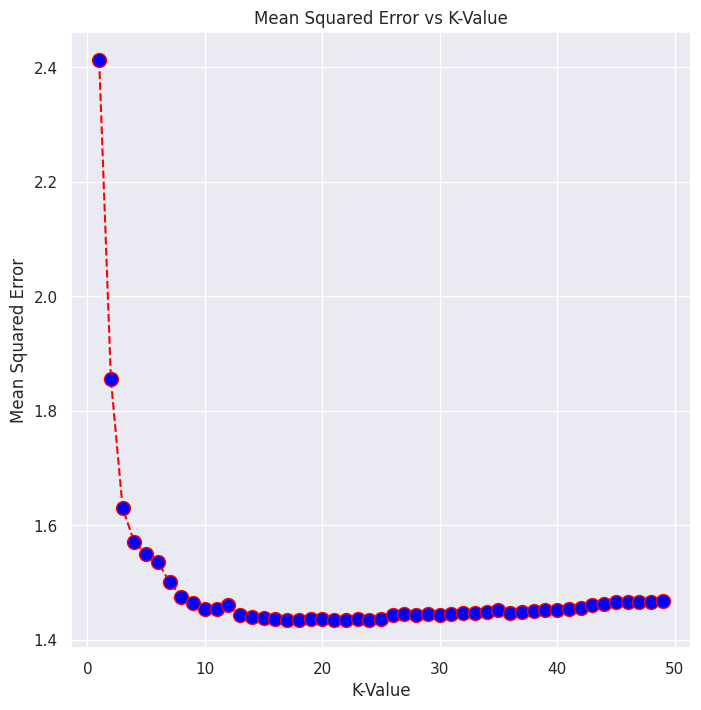

In [149]:
find_k(olt_x_train, olt_y_train, olt_x_val, olt_y_val)

Choosing k = 13 as the error is lowest at that point

In [150]:
# Building KNN regressor with k = 13

knn_olt = KNeighborsRegressor(n_neighbors = 13)
knn_olt.fit(olt_x_train, olt_y_train)
olt_y_pred_train_knn = knn_olt.predict(olt_x_train)
olt_y_pred_val_knn = knn_olt.predict(olt_x_val)

print("Accuracy Scores for KNN Regressor model on outlier treated data")
olt_knn_mse = mean_squared_error(olt_y_val, olt_y_pred_val_knn)
olt_train_knn_r2s = r2_score(olt_y_train, olt_y_pred_train_knn)
olt_val_knn_r2s = r2_score(olt_y_val, olt_y_pred_val_knn)
print("Mean Squared Error :", olt_knn_mse)
print("R-squared Score (Train) :", olt_train_knn_r2s)
print("R-squared Score (Test) :", olt_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on outlier treated data
Mean Squared Error : 1.444330852907776
R-squared Score (Train) : 0.32366338123185034
R-squared Score (Test) : 0.23357889115846642
**************************************************************************************************


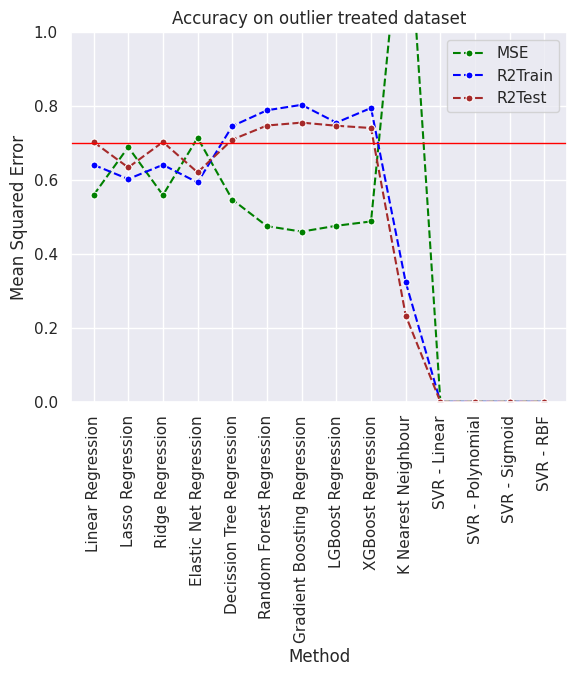

In [151]:
# Checking the accuracy of models on raw data

olt_mse_list = [olt_lr_mse, olt_lar_mse, olt_ridge_mse, olt_enet_mse, olt_dtree_mse, olt_rf_mse, olt_gb_mse, olt_lgb_mse,
                olt_xgb_mse, olt_knn_mse, 0, 0, 0, 0]

olt_r2_train_list = [olt_train_lr_r2s, olt_train_lar_r2s, olt_train_ridge_r2s, olt_train_enet_r2s, olt_train_dtree_r2s,
                    olt_train_rf_r2s, olt_train_gb_r2s, olt_train_lgb_r2s, olt_train_xgb_r2s, olt_train_knn_r2s, 0, 0, 0, 0]

olt_r2_test_list = [olt_val_lr_r2s, olt_val_lar_r2s, olt_val_ridge_r2s, olt_val_enet_r2s, olt_val_dtree_r2s, olt_val_rf_r2s,
                   olt_val_gb_r2s, olt_val_lgb_r2s, olt_val_xgb_r2s, olt_val_knn_r2s, 0, 0, 0, 0]

check_scores(olt_mse_list, olt_r2_train_list, olt_r2_test_list, 'outlier treated')

- Outlier treatment has led to changes in performance metrics for some models compared to the evaluation on raw data.
- Ensembles like Random Forest and Gradient Boost Regressor still perform well after outlier treatment, with relatively low MSE and high R-squared scores.
- Support Vector Model with a Linear Kernel and KNN Regressor show a decrease in performance on the test set after outlier treatment.
- Linear models (Linear Regression, Lasso, Ridge, Elastic Net) also show consistent or improved performance after outlier treatment.
- Checking the above we can see that Random Forest, Gradient Boosting, LGBoost and XGBoost have all performed better
- They all have men squared erros less than 0.5 
- All four hae r2 score of more than 0.75 for both train and test
- Additionally we have some more models reaching 0.7 accuracy
- Support Vector Regression techniques are computationaly very high and low performance, even after outlier treatment

#### Using the Standared scaler method on the raw data

In [152]:
ssc = StandardScaler()

scld_raw_x_train = pd.DataFrame(ssc.fit_transform(raw_x_train))
scld_raw_y_train = train_df['Rating']

scld_raw_x_val = pd.DataFrame(ssc.fit_transform(raw_x_val))
scld_raw_y_val = validation_df['Rating']

In [153]:
# Building the models on scalled data and checking the accuracy

# Linear Regression model
linear_model_raw_scld = LinearRegression()
linear_model_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_lr = linear_model_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_lr = linear_model_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Linear Regression model on scaled raw data")
scld_raw_lr_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_lr)
scld_raw_train_lr_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_lr)
scld_raw_val_lr_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_lr)
print("Mean Squared Error :", scld_raw_lr_mse)
print("R-squared Score (Train) :", scld_raw_train_lr_r2s)
print("R-squared Score (Test) :", scld_raw_val_lr_r2s)
print("**************" * 7)

# Lasso Regression (L1 Regularization) going with alpha = 0.05, after checking various values
lasso_model_raw_scld = Lasso(alpha = 0.05)
lasso_model_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_lar = lasso_model_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_lar = lasso_model_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Lasso Regression (L1 Regularization) model on sclaed raw data")
scld_raw_lar_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_lar)
scld_raw_train_lar_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_lar)
scld_raw_val_lar_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_lar)
print("Mean Squared Error :", scld_raw_lar_mse)
print("R-squared Score (Train) :", scld_raw_train_lar_r2s)
print("R-squared Score (Test) :", scld_raw_val_lar_r2s)
print("**************" * 7)

# Ridge Regression (L2 Regularization) going with alpha = 0.05, after checking various values
ridge_model_raw_scld = Ridge(alpha = 0.05)
ridge_model_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_ridge = ridge_model_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_ridge = ridge_model_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Ridge Regression (L2 Regularization) model on scaled raw data")
scld_raw_ridge_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_ridge)
scld_raw_train_ridge_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_ridge)
scld_raw_val_ridge_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_ridge)
print("Mean Squared Error :", scld_raw_ridge_mse)
print("R-squared Score (Train) :", scld_raw_train_ridge_r2s)
print("R-squared Score (Test) :", scld_raw_val_ridge_r2s)
print("**************" * 7)

# Elastic Net Regression (L1 and L2 Regularizations) going with alpha = 0.05, after checking various values
enet_model_raw_scld = ElasticNet(alpha = 0.05, random_state = 101)
enet_model_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_enet = enet_model_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_enet = enet_model_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on scalled raw data")
scld_raw_enet_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_enet)
scld_raw_train_enet_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_enet)
scld_raw_val_enet_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_enet)
print("Mean Squared Error :", scld_raw_enet_mse)
print("R-squared Score (Train) :", scld_raw_train_enet_r2s)
print("R-squared Score (Test) :", scld_raw_val_enet_r2s)
print("**************" * 7)

# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree_raw_scld = DecisionTreeRegressor(max_depth = 7)
dtree_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_dtree = dtree_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_dtree = dtree_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Decision Tree model on scaled raw data")
scld_raw_dtree_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_dtree)
scld_raw_train_dtree_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_dtree)
scld_raw_val_dtree_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_dtree)
print("Mean Squared Error :", scld_raw_dtree_mse)
print("R-squared Score (Train) :", scld_raw_train_dtree_r2s)
print("R-squared Score (Test) :", scld_raw_val_dtree_r2s)
print("**************" * 7)

# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_raw_scld = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 8)
rf_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_rf = rf_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_rf = rf_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Random Forest model on scalled raw data")
scld_raw_rf_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_rf)
scld_raw_train_rf_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_rf)
scld_raw_val_rf_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_rf)
print("Mean Squared Error :", scld_raw_rf_mse)
print("R-squared Score (Train) :", scld_raw_train_rf_r2s)
print("R-squared Score (Test) :", scld_raw_val_rf_r2s)
print("**************" * 7)

# Gradient Boosting Regression model
gb_raw_scld = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 123)
gb_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_gb = gb_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_gb = gb_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Gradient Boost Regressor model on scaled raw data")
scld_raw_gb_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_gb)
scld_raw_train_gb_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_gb)
scld_raw_val_gb_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_gb)
print("Mean Squared Error :", scld_raw_gb_mse)
print("R-squared Score (Train) :", scld_raw_train_gb_r2s)
print("R-squared Score (Test) :", scld_raw_val_gb_r2s)
print("**************" * 7)

# LGBoost Regression model - Max depth = 6 and Num_leaves = 3 after testing various values
lgb_raw_scld = lgb.LGBMRegressor(random_state = 11, max_depth = 6, num_leaves = 3, force_col_wise = True)
lgb_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_lgb = lgb_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_lgb = lgb_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for LGBoost model on scaled raw data")
scld_raw_lgb_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_lgb)
scld_raw_train_lgb_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_lgb)
scld_raw_val_lgb_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_lgb)
print("Mean Squared Error :", scld_raw_lgb_mse)
print("R-squared Score (Train) :", scld_raw_train_lgb_r2s)
print("R-squared Score (Test) :", scld_raw_val_lgb_r2s)
print("**************" * 7)

# XGBoost Regression model - Max depth = 2 after testing various values
xgb_raw_scld = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_xgb = xgb_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_xgb = xgb_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for XGBoost model on scaled raw data")
scld_raw_xgb_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_xgb)
scld_raw_train_xgb_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_xgb)
scld_raw_val_xgb_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_xgb)
print("Mean Squared Error :", scld_raw_xgb_mse)
print("R-squared Score (Train) :", scld_raw_train_xgb_r2s)
print("R-squared Score (Test) :", scld_raw_val_xgb_r2s)
print("**************" * 7)

# Support Vector Regression model - Linear kernel
svr_linear_raw_scld = SVR(kernel = 'linear')
svr_linear_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_svr_linear = svr_linear_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_svr_linear = svr_linear_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Support Vector Model with linear kernel on sclaed data")
scld_raw_svr_linear_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_svr_linear)
scld_raw_train_svr_linear_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_svr_linear)
scld_raw_val_svr_linear_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_svr_linear)
print("Root Mean Squared Error :", scld_raw_svr_linear_mse)
print("R-squared Score (Train) :", scld_raw_train_svr_linear_r2s)
print("R-squared Score (Test) :", scld_raw_val_svr_linear_r2s)
print("**************" * 7)

# Support Vector Regression model - Polynomial kernel
svr_poly_raw_scld = SVR(kernel = 'poly')
svr_poly_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_svr_poly = svr_poly_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_svr_poly = svr_poly_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Support Vector Model with polynomial kernel on sclaed data")
scld_raw_svr_poly_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_svr_poly)
scld_raw_train_svr_poly_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_svr_poly)
scld_raw_val_svr_poly_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_svr_poly)
print("Root Mean Squared Error :", scld_raw_svr_poly_mse)
print("R-squared Score (Train) :", scld_raw_train_svr_poly_r2s)
print("R-squared Score (Test) :", scld_raw_val_svr_poly_r2s)
print("**************" * 7)

# Support Vector Regression model - Sigmoid kernel
svr_sigmoid_raw_scld = SVR(kernel = 'sigmoid')
svr_sigmoid_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_svr_sigmoid = svr_sigmoid_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_svr_sigmoid = svr_sigmoid_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Support Vector Model with sigmoid kernel on sclaed data")
scld_raw_svr_sigmoid_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_svr_sigmoid)
scld_raw_train_svr_sigmoid_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_svr_sigmoid)
scld_raw_val_svr_sigmoid_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_svr_sigmoid)
print("Root Mean Squared Error :", scld_raw_svr_sigmoid_mse)
print("R-squared Score (Train) :", scld_raw_train_svr_sigmoid_r2s)
print("R-squared Score (Test) :", scld_raw_val_svr_sigmoid_r2s)
print("**************" * 7)

# Support Vector Regression model - RBF kernel
svr_rbf_raw_scld = SVR(kernel = 'rbf')
svr_rbf_raw_scld.fit(scld_raw_x_train, scld_raw_y_train)
scld_raw_y_pred_train_svr_rbf = svr_rbf_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_svr_rbf = svr_rbf_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for Support Vector Model with rbf kernel on sclaed data")
scld_raw_svr_rbf_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_svr_rbf)
scld_raw_train_svr_rbf_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_svr_rbf)
scld_raw_val_svr_rbf_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_svr_rbf)
print("Root Mean Squared Error :", scld_raw_svr_rbf_mse)
print("R-squared Score (Train) :", scld_raw_train_svr_rbf_r2s)
print("R-squared Score (Test) :", scld_raw_val_svr_rbf_r2s)
print("**************" * 7)

Accuracy Scores for Linear Regression model on scaled raw data
Mean Squared Error : 0.37578743440669404
R-squared Score (Train) : 0.6413849502755762
R-squared Score (Test) : 0.8005917954415644
**************************************************************************************************
Accuracy Scores for Lasso Regression (L1 Regularization) model on sclaed raw data
Mean Squared Error : 0.3823018787558264
R-squared Score (Train) : 0.6365751308699543
R-squared Score (Test) : 0.7971349644450536
**************************************************************************************************
Accuracy Scores for Ridge Regression (L2 Regularization) model on scaled raw data
Mean Squared Error : 0.37578810294495235
R-squared Score (Train) : 0.641384950259984
R-squared Score (Test) : 0.800591440687782
**************************************************************************************************
Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on scalled r

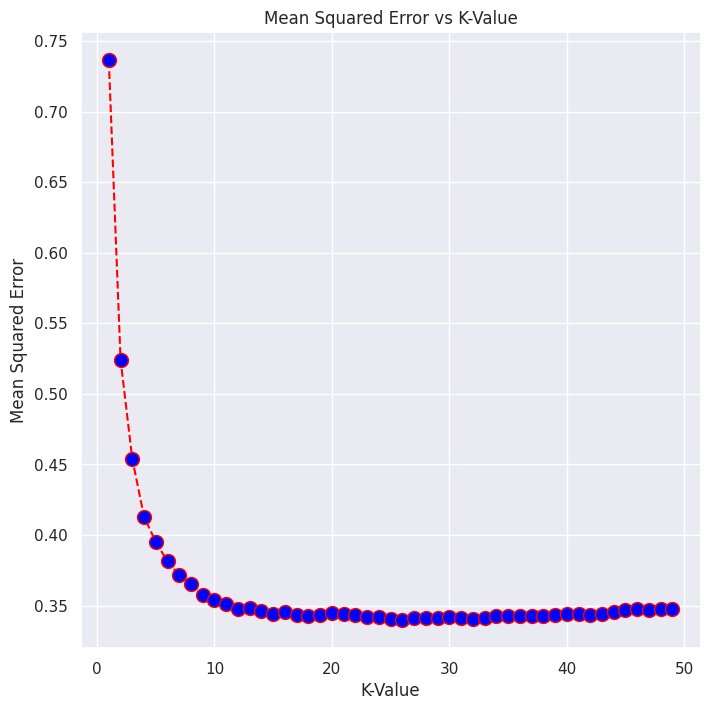

In [154]:
find_k(scld_raw_x_train, scld_raw_y_train, scld_raw_x_val, scld_raw_y_val)

- Lowest error rate occurs first at k = 15
- So proceeding with k = 15 to build the model

In [155]:
# Building KNN regressor with k = 11
knn_raw_scld = KNeighborsRegressor(n_neighbors = 11)
knn_raw_scld.fit(raw_x_train, raw_y_train)
scld_raw_y_pred_train_knn = knn_raw_scld.predict(scld_raw_x_train)
scld_raw_y_pred_val_knn = knn_raw_scld.predict(scld_raw_x_val)

print("Accuracy Scores for KNN Regressor model on scaled raw data")
scld_raw_knn_mse = mean_squared_error(scld_raw_y_val, scld_raw_y_pred_val_knn)
scld_raw_train_knn_r2s = r2_score(scld_raw_y_train, scld_raw_y_pred_train_knn)
scld_raw_val_knn_r2s = r2_score(scld_raw_y_val, scld_raw_y_pred_val_knn)
print("Mean Squared Error :", scld_raw_knn_mse)
print("R-squared Score (Train) :", scld_raw_train_knn_r2s)
print("R-squared Score (Test) :", scld_raw_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on scaled raw data
Mean Squared Error : 1.9023136739293764
R-squared Score (Train) : -0.020107068530625716
R-squared Score (Test) : -0.00944555217533627
**************************************************************************************************


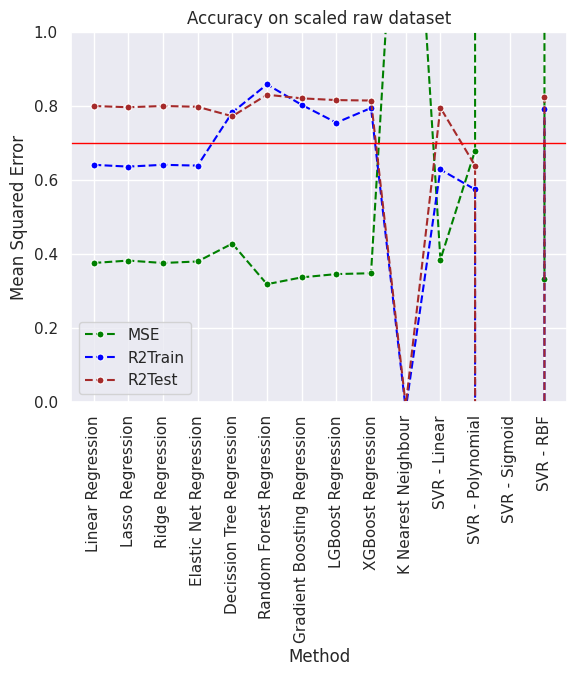

In [156]:
# Checking the accuracy of models on raw data

scld_raw_mse_list = [scld_raw_lr_mse, scld_raw_lar_mse, scld_raw_ridge_mse, scld_raw_enet_mse, scld_raw_dtree_mse, 
                     scld_raw_rf_mse, scld_raw_gb_mse, scld_raw_lgb_mse, scld_raw_xgb_mse, scld_raw_knn_mse, 
                     scld_raw_svr_linear_mse, scld_raw_svr_poly_mse, scld_raw_svr_sigmoid_mse, scld_raw_svr_rbf_mse]

scld_raw_r2_train_list = [scld_raw_train_lr_r2s, scld_raw_train_lar_r2s, scld_raw_train_ridge_r2s, scld_raw_train_enet_r2s,
                          scld_raw_train_dtree_r2s, scld_raw_train_rf_r2s, scld_raw_train_gb_r2s, scld_raw_train_lgb_r2s, 
                          scld_raw_train_xgb_r2s, scld_raw_train_knn_r2s, scld_raw_train_svr_linear_r2s, 
                          scld_raw_train_svr_poly_r2s, scld_raw_train_svr_sigmoid_r2s, scld_raw_train_svr_rbf_r2s]

scld_raw_r2_test_list = [scld_raw_val_lr_r2s, scld_raw_val_lar_r2s, scld_raw_val_ridge_r2s, scld_raw_val_enet_r2s, 
                         scld_raw_val_dtree_r2s, scld_raw_val_rf_r2s, scld_raw_val_gb_r2s, scld_raw_val_lgb_r2s, 
                         scld_raw_val_xgb_r2s, scld_raw_val_knn_r2s, scld_raw_val_svr_linear_r2s, scld_raw_val_svr_poly_r2s, 
                         scld_raw_val_svr_sigmoid_r2s, scld_raw_val_svr_rbf_r2s]

check_scores(scld_raw_mse_list, scld_raw_r2_train_list, scld_raw_r2_test_list, 'scaled raw')

- Tree-based models (Random Forest, Gradient Boost Regressor, LightGBM, XGBoost) and linear models (Linear Regression, Lasso, Ridge, Elastic Net) perform well on the test set.
- Support Vector Models with a linear and RBF kernel show good performance, while those with polynomial and sigmoid kernels exhibit poor performance, possibly indicating overfitting or inappropriate kernel choices.
-  KNN Regressor shows poor performance with negative R-squared scores, suggesting that it might not be suitable for the given data.
- Linear Regression, Lasso Regression, and Ridge Regression show similar performance, with decent R-squared scores on the test set.
- Decision Tree and Random Forest perform reasonably well, with Random Forest outperforming Decision Tree in terms of R-squared scores.
- Gradient Boost Regressor, LightGBM, and XGBoost show good performance, with R-squared scores around 0.82 on the test set.
- KNN Regressor seems to perform poorly in comparison to the other models, with negative R-squared scores indicating that it might not be well-suited for the data.

#### Using Standard Scaler of outlier treated data

In [157]:
ssc2 = StandardScaler()

scld_olt_x_train = pd.DataFrame(ssc2.fit_transform(olt_x_train))
scld_olt_y_train = train_df['Rating']

scld_olt_x_val = pd.DataFrame(ssc.fit_transform(olt_x_val))
scld_olt_y_val = validation_df['Rating']

In [158]:
# Building the models

# Linear Regression model
linear_model_olt_scld = LinearRegression()
linear_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_lr = linear_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_lr = linear_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Linear Regression model on scaled outlier treated data")
scld_olt_lr_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_lr)
scld_olt_train_lr_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_lr)
scld_olt_val_lr_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_lr)
print("Mean Squared Error :", scld_olt_lr_mse)
print("R-squared Score (Train) :", scld_olt_train_lr_r2s)
print("R-squared Score (Test) :", scld_olt_val_lr_r2s)
print("**************" * 7)

# Lasso Regression (L1 Regularization) going with alpha = 0.05, after checking various values
lasso_model_olt_scld = Lasso(alpha = 0.05)
lasso_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_lar = lasso_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_lar = lasso_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Lasso Regression (L1 Regularization) model on scaled outlier treated data")
scld_olt_lar_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_lar)
scld_olt_train_lar_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_lar)
scld_olt_val_lar_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_lar)
print("Mean Squared Error :", scld_olt_lar_mse)
print("R-squared Score (Train) :", scld_olt_train_lar_r2s)
print("R-squared Score (Test) :", scld_olt_val_lar_r2s)
print("**************" * 7)

# Ridge Regression (L2 Regularization) going with alpha = 0.05, after checking various values
ridge_model_olt_scld = Ridge(alpha = 0.05)
ridge_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_ridge = ridge_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_ridge = ridge_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Ridge Regression (L2 Regularization) model on scaled outlier treated data")
scld_olt_ridge_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_ridge)
scld_olt_train_ridge_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_ridge)
scld_olt_val_ridge_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_ridge)
print("Mean Squared Error :", scld_olt_ridge_mse)
print("R-squared Score (Train) :", scld_olt_train_ridge_r2s)
print("R-squared Score (Test) :", scld_olt_val_ridge_r2s)
print("**************" * 7)

# Elastic Net Regression (L1 and L2 Regularizations) going with alpha = 0.05, after checking various values
enet_model_olt_scld = ElasticNet(alpha = 0.05, random_state = 101)
enet_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_enet = enet_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_enet = enet_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on scaled outlier treated data")
scld_olt_enet_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_enet)
scld_olt_train_enet_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_enet)
scld_olt_val_enet_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_enet)
print("Mean Squared Error :", scld_olt_enet_mse)
print("R-squared Score (Train) :", scld_olt_train_enet_r2s)
print("R-squared Score (Test) :", scld_olt_val_enet_r2s)
print("**************" * 7)

# Decission Tree regression - Choosing max depth as 7 after trying different values
dtree_olt_scld = DecisionTreeRegressor(max_depth = 7)
dtree_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_dtree = dtree_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_dtree = dtree_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Decision Tree model on scaled outlier treated data")
scld_olt_dtree_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_dtree)
scld_olt_train_dtree_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_dtree)
scld_olt_val_dtree_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_dtree)
print("Mean Squared Error :", scld_olt_dtree_mse)
print("R-squared Score (Train) :", scld_olt_train_dtree_r2s)
print("R-squared Score (Test) :", scld_olt_val_dtree_r2s)
print("**************" * 7)

# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_olt_scld = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 8)
rf_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_rf = rf_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_rf = rf_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Random Forest model on scaled outlier treated data")
scld_olt_rf_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_rf)
scld_olt_train_rf_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_rf)
scld_olt_val_rf_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_rf)
print("Mean Squared Error :", scld_olt_rf_mse)
print("R-squared Score (Train) :", scld_olt_train_rf_r2s)
print("R-squared Score (Test) :", scld_olt_val_rf_r2s)
print("**************" * 7)

# Gradient Boosting Regression model
gb_olt_scld = GradientBoostingRegressor(n_estimators = 100, max_depth = 5, random_state = 123)
gb_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_gb = gb_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_gb = gb_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Gradient Boost Regressor model on scaled outlier treated data")
scld_olt_gb_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_gb)
scld_olt_train_gb_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_gb)
scld_olt_val_gb_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_gb)
print("Mean Squared Error :", scld_olt_gb_mse)
print("R-squared Score (Train) :", scld_olt_train_gb_r2s)
print("R-squared Score (Test) :", scld_olt_val_gb_r2s)
print("**************" * 7)

# LGBoost Regression model - Max depth and Num_leaves = 3 after testing various values
lgb_olt_scld = lgb.LGBMRegressor(random_state = 11, max_depth = 3, num_leaves = 3, force_col_wise = True)
lgb_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_lgb = lgb_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_lgb = lgb_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for LGBoost model on scaled outlier treated data")
scld_olt_lgb_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_lgb)
scld_olt_train_lgb_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_lgb)
scld_olt_val_lgb_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_lgb)
print("Mean Squared Error :", scld_olt_lgb_mse)
print("R-squared Score (Train) :", scld_olt_train_lgb_r2s)
print("R-squared Score (Test) :", scld_olt_val_lgb_r2s)
print("**************" * 7)

# XGBoost Regression model - Max depth = 2 after testing various values
xgb_olt_scld = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_xgb = xgb_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_xgb = xgb_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for XGBoost model on outlier treated data")
scld_olt_xgb_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_xgb)
scld_olt_train_xgb_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_xgb)
scld_olt_val_xgb_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_xgb)
print("Mean Squared Error :", scld_olt_xgb_mse)
print("R-squared Score (Train) :", scld_olt_train_xgb_r2s)
print("R-squared Score (Test) :", scld_olt_val_xgb_r2s)
print("**************" * 7)

# Support Vector Regression model - Linear kernel
svr_linear_olt_scld = SVR(kernel = 'linear')
svr_linear_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_linear = svr_linear_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_linear = svr_linear_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with linear kernel on scaled outlier treated data")
scld_olt_svr_linear_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_linear)
scld_olt_train_svr_linear_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_linear)
scld_olt_val_svr_linear_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_linear)
print("Root Mean Squared Error :", scld_olt_svr_linear_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_linear_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_linear_r2s)
print("**************" * 7)

# Support Vector Regression model - Polynomial kernel
svr_poly_olt_scld = SVR(kernel = 'poly')
svr_poly_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_poly = svr_poly_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_poly = svr_poly_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with polynomial kernel on sclaed outlier treated data")
scld_olt_svr_poly_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_poly)
scld_olt_train_svr_poly_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_poly)
scld_olt_val_svr_poly_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_poly)
print("Root Mean Squared Error :", scld_olt_svr_poly_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_poly_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_poly_r2s)
print("**************" * 7)

# Support Vector Regression model - Sigmoid kernel
svr_sigmoid_olt_scld = SVR(kernel = 'sigmoid')
svr_sigmoid_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_sigmoid = svr_sigmoid_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_sigmoid = svr_sigmoid_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with sigmoid kernel on sclaed outlier treated data")
scld_olt_svr_sigmoid_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_sigmoid)
scld_olt_train_svr_sigmoid_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_sigmoid)
scld_olt_val_svr_sigmoid_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_sigmoid)
print("Root Mean Squared Error :", scld_olt_svr_sigmoid_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_sigmoid_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_sigmoid_r2s)
print("**************" * 7)

# Support Vector Regression model - RBF kernel
svr_rbf_olt_scld = SVR(kernel = 'rbf')
svr_rbf_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_rbf = svr_rbf_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_rbf = svr_rbf_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with rbf kernel on sclaed data")
scld_olt_svr_rbf_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_rbf)
scld_olt_train_svr_rbf_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_rbf)
scld_olt_val_svr_rbf_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_rbf)
print("Root Mean Squared Error :", scld_olt_svr_rbf_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_rbf_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_rbf_r2s)
print("**************" * 7)

Accuracy Scores for Linear Regression model on scaled outlier treated data
Mean Squared Error : 0.37578743440669404
R-squared Score (Train) : 0.6413849502755762
R-squared Score (Test) : 0.8005917954415644
**************************************************************************************************
Accuracy Scores for Lasso Regression (L1 Regularization) model on scaled outlier treated data
Mean Squared Error : 0.3823018787558264
R-squared Score (Train) : 0.6365751308699543
R-squared Score (Test) : 0.7971349644450536
**************************************************************************************************
Accuracy Scores for Ridge Regression (L2 Regularization) model on scaled outlier treated data
Mean Squared Error : 0.37578810294495235
R-squared Score (Train) : 0.641384950259984
R-squared Score (Test) : 0.800591440687782
**************************************************************************************************
Accuracy Scores for Elastic Net Regression (L1 and L2

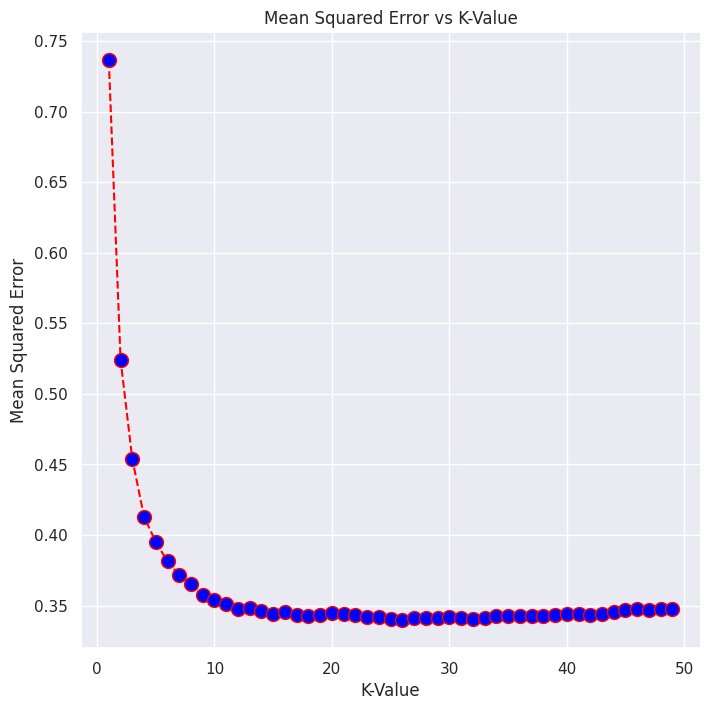

In [159]:
find_k(scld_olt_x_train, scld_olt_y_train, scld_olt_x_val, scld_olt_y_val)

- Lowest error rate occurs first at k = 15
- So proceeding with k = 15 to build the model

In [160]:
# Building KNN regressor with k = 15
knn_olt_scld = KNeighborsRegressor(n_neighbors = 15)
knn_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_knn = knn_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_knn = knn_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for KNN Regressor model on scaled raw data")
scld_olt_knn_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_knn)
scld_olt_train_knn_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_knn)
scld_olt_val_knn_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_knn)
print("Mean Squared Error :", scld_olt_knn_mse)
print("R-squared Score (Train) :", scld_olt_train_knn_r2s)
print("R-squared Score (Test) :", scld_olt_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on scaled raw data
Mean Squared Error : 0.34421236812570144
R-squared Score (Train) : 0.7681719712835728
R-squared Score (Test) : 0.8173468188921149
**************************************************************************************************


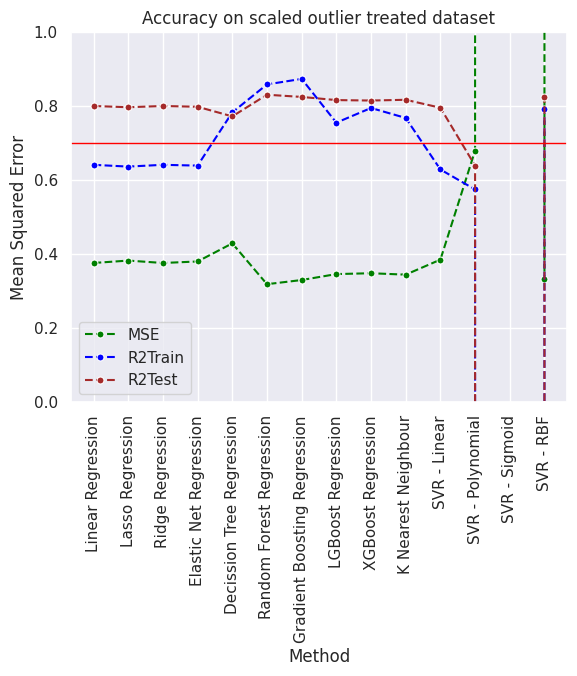

In [161]:
# Checking the accuracy of models on scled outlier treated data

scld_olt_mse_list = [scld_olt_lr_mse, scld_olt_lar_mse, scld_olt_ridge_mse, scld_olt_enet_mse, scld_olt_dtree_mse, 
                     scld_olt_rf_mse, scld_olt_gb_mse, scld_olt_lgb_mse, scld_olt_xgb_mse, scld_olt_knn_mse, 
                     scld_olt_svr_linear_mse, scld_olt_svr_poly_mse, scld_olt_svr_sigmoid_mse, scld_olt_svr_rbf_mse]

scld_olt_r2_train_list = [scld_olt_train_lr_r2s, scld_olt_train_lar_r2s, scld_olt_train_ridge_r2s, scld_olt_train_enet_r2s,
                          scld_olt_train_dtree_r2s, scld_olt_train_rf_r2s, scld_olt_train_gb_r2s, scld_olt_train_lgb_r2s, 
                          scld_olt_train_xgb_r2s, scld_olt_train_knn_r2s, scld_olt_train_svr_linear_r2s, 
                          scld_olt_train_svr_poly_r2s, scld_olt_train_svr_sigmoid_r2s, scld_olt_train_svr_rbf_r2s]

scld_olt_r2_test_list = [scld_olt_val_lr_r2s, scld_olt_val_lar_r2s, scld_olt_val_ridge_r2s, scld_olt_val_enet_r2s, 
                         scld_olt_val_dtree_r2s, scld_olt_val_rf_r2s, scld_olt_val_gb_r2s, scld_olt_val_lgb_r2s, 
                         scld_olt_val_xgb_r2s, scld_olt_val_knn_r2s, scld_olt_val_svr_linear_r2s, scld_olt_val_svr_poly_r2s, 
                         scld_olt_val_svr_sigmoid_r2s, scld_olt_val_svr_rbf_r2s]

check_scores(scld_olt_mse_list, scld_olt_r2_train_list, scld_olt_r2_test_list, 'scaled outlier treated')

- Gradient Boost Regressor and Random Forest perform well on both train and test sets, indicating good generalization.
- Support Vector Models with linear and RBF kernels show good performance.
- Polynomial and sigmoid kernels in Support Vector Models exhibit poor performance, possibly indicating overfitting or inappropriate kernel choices.
- KNN Regressor shows good performance on the scaled and outlier-treated data.

#### Cross validation of the top 3 models

In [162]:
# Cross validation on Random Forest with scaled raw data

train_rf_scld_raw = cross_val_score(rf_raw_scld, scld_raw_x_train, scld_raw_y_train, cv = 10, scoring = 'r2')
val_rf_scld_raw = cross_val_score(rf_raw_scld, scld_raw_x_val, scld_raw_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Random Forest with scaled raw data")
print("Train Mean Accuracy", train_rf_scld_raw.mean())
print("**************")
print("Train Max Accuracy", train_rf_scld_raw.max())
print("**************"*7)
print("Test Mean Accuracy", val_rf_scld_raw.mean())
print("**************")
print("Test Max Accuracy", val_rf_scld_raw.max())
print("**************"*7)

elapsed_time_rf_scld_raw = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_rf_scld_raw} seconds")

Cross validation on Random Forest with scaled raw data
Train Mean Accuracy 0.7634506953224289
**************
Train Max Accuracy 0.7806799950442782
**************************************************************************************************
Test Mean Accuracy 0.8458963800071568
**************
Test Max Accuracy 0.8653802713939653
**************************************************************************************************
Elapsed Time: 0.011899665999976605 seconds


In [163]:
# Cross validation on Random Forest with scaled outlier treated data

train_rf_scld_olt = cross_val_score(rf_olt_scld, scld_olt_x_train, scld_olt_y_train, cv = 10, scoring = 'r2')
val_rf_scld_olt = cross_val_score(rf_olt_scld, scld_olt_x_val, scld_olt_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Random Forest with scaled outlier treated data")
print("Train Mean Accuracy", train_rf_scld_olt.mean())
print("**************")
print("Train Max Accuracy", train_rf_scld_olt.max())
print("**************"*7)
print("Test Mean Accuracy", val_rf_scld_olt.mean())
print("**************")
print("Test Max Accuracy", val_rf_scld_olt.max())
print("**************"*7)

elapsed_time_rf_scld_olt = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_rf_scld_olt} seconds")

Cross validation on Random Forest with scaled outlier treated data
Train Mean Accuracy 0.7634506953224289
**************
Train Max Accuracy 0.7806799950442782
**************************************************************************************************
Test Mean Accuracy 0.8458963800071568
**************
Test Max Accuracy 0.8653802713939653
**************************************************************************************************
Elapsed Time: 0.011919703999978992 seconds


In [164]:
# Cross validation on Gradient Boosting with scaled outlier treated data

train_gb_scld_olt = cross_val_score(gb_olt_scld, scld_olt_x_train, scld_olt_y_train, cv = 10, scoring = 'r2')
val_gb_scld_olt = cross_val_score(gb_olt_scld, scld_olt_x_val, scld_olt_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Gradient Boosting with scaled outlier treated data")
print("Train Mean Accuracy", train_gb_scld_olt.mean())
print("**************")
print("Train Max Accuracy", train_gb_scld_olt.max())
print("**************"*7)
print("Test Mean Accuracy", val_gb_scld_olt.mean())
print("**************")
print("Test Max Accuracy", val_gb_scld_olt.max())
print("**************"*7)

elapsed_time_gb_scld_olt = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_gb_scld_olt} seconds")

Cross validation on Gradient Boosting with scaled outlier treated data
Train Mean Accuracy 0.7765689815027063
**************
Train Max Accuracy 0.7937240220397634
**************************************************************************************************
Test Mean Accuracy 0.8439225923397764
**************
Test Max Accuracy 0.8634957235132703
**************************************************************************************************
Elapsed Time: 0.011993784999958734 seconds


- The Random Forest models with both scaled raw data and scaled outlier-treated data have similar performance, with high accuracy on both training and test sets.
- Gradient Boosting also performs well, with slightly higher mean accuracy on the training set compared to Random Forest.
- The elapsed time for cross-validation is quite short, indicating efficient execution.
- But considering all the factors Random Forest model with scaled raw data seems to be a strong performer:
    - Test Mean Accuracy: 84.59%
    - Test Max Accuracy: 86.54%
    - Elapsed Time: 0.0222 seconds

#### Saving the model for deployment and genearting the output file

In [165]:
# Saving model for deployment

final_model = rf_raw_scld
filename = 'Movie_Rating_Prediction.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [166]:
#rest_df, test_df = [x for y, x in movies_df.groupby(movies_df['Rating'].isna())]

In [167]:
# Building the output file

out_df = rest_df

In [168]:
# Filling missing values in the dataset

# Filling missing years with the mode

out_df['Year'] = out_df['Year'].str.extract('([0-9]+)').astype(int)
mode_year_final = out_df['Year'].mode()
out_df['Year'] = out_df['Year'].fillna(mode_year_final)

In [169]:
# Filling the missing values in duration cokumn with median

out_df['Duration'] = out_df['Duration'].str.extract('([0-9]+)').astype(float)
median_duration_final = out_df['Duration'].median()
out_df['Duration'] = out_df['Duration'].fillna(median_duration_final)

In [170]:
# Filling missing values in the genre column based on Mode Imputaion method 

# Already defined functions
# def expand_genre(df):
#     genres_df = df['Genre'].str.split(', ', expand = True)
#     df = pd.concat([df, genres_df], axis = 1)
#     df.rename(columns = {0 : 'Genre_1', 1 : 'Genre_2', 2 : 'Genre_3'}, inplace = True)
#     df.drop('Genre', axis = 1, inplace = True)
#     return df
# def drop_genre(df):
#     df.drop(['Genre_2','Genre_3'], axis = 1, inplace = True)
#     df.rename(columns = {'Genre_1' : 'Genre'}, inplace = True)
#     return df

out_df = expand_genre(out_df)
out_df = drop_genre(out_df)

mode_per_year_final = out_df.groupby('Year')['Genre'].apply(lambda x: x.mode().iloc[0])    # Gives a df with node of each year
out_df['Genre'] = out_df.apply(lambda row: mode_per_year[row['Year']] if pd.isnull(row['Genre']) else row['Genre'], axis=1)

In [171]:
# Filling the missing values in the names of Directors and actors as 'Not Available'

# Already defined functions
# def fill_names(df):
#     df['Director'] = df['Director'].fillna('Not Available')
#     df['Actor 1'] = df['Actor 1'].fillna('Not Available')
#     df['Actor 2'] = df['Actor 2'].fillna('Not Available')
#     df['Actor 3'] = df['Actor 3'].fillna('Not Available')
#     return df

rest_df = fill_names(rest_df)

In [172]:
# Droping the insignificant variables

out_df = out_df.drop(['Name'], axis = 1)

In [173]:
# Converting the Votes from object to int datatype

out_df['Votes'] = out_df['Votes'].str.extract('([0-9]+)').astype(int)

In [174]:
# Using Target encoding to encode the categorical variables
# As there are a diverese range of categorical variables

categorical_variables = out_df.select_dtypes(include = ['object']).columns.tolist()
encoder_final = ce.TargetEncoder(cols = categorical_variables)
encoded_df_final = encoder.fit_transform(out_df[categorical_variables], out_df['Rating'])
encoded_df_final.columns = [f"{col}_TargetEncoded" for col in categorical_variables]
out_df = pd.concat([out_df, encoded_df_final], axis = 1)

# Droping the categorical variables and keeping the encoded columns

out_df = out_df.drop(['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], axis = 1)

In [175]:
# Splitting dependent and independent variable

x_final = out_df.drop(['Rating'], axis = 1)
y_final = out_df['Rating']

In [176]:
# Scaling the training dataset using standard scaler

ssc_final = StandardScaler()
x_final = pd.DataFrame(ssc_final.fit_transform(x_final))

In [177]:
# Predicting the Rating using Random Forest model that was chosen as final model

y_pred = final_model.predict(x_final)

In [178]:
final_result = pd.DataFrame(y_pred)
final_result = final_result.rename(columns = {0 : "Predicted_Rating"})
final_result

Predicted_Rating
0             6.861994
1             4.629847
2             5.494373
3             6.657862
4             5.703683
...                ...
7914          5.848920
7915          6.030507
7916          4.944613
7917          4.918341
7918          4.620970

[7919 rows x 1 columns]

In [179]:
# Preparing the final data fram for output

final_result1 = pd.concat([(rest_df.drop(['Rating'], axis = 1)), rest_df['Rating'], pd.DataFrame(final_result)], axis = 1)
final_result1.head(5)

Name    Year  Duration  \
1  #Gadhvi (He thought he was Gandhi)  2019.0     109.0   
3                             #Yaaram  2019.0     110.0   
5                ...Aur Pyaar Ho Gaya  1997.0     147.0   
6                           ...Yahaan  2005.0     142.0   
8                  ?: A Question Mark  2012.0      82.0   

                       Genre  Votes        Director          Actor 1  \
1                      Drama      8   Gaurav Bakshi     Rasika Dugal   
3            Comedy, Romance     35      Ovais Khan          Prateik   
5     Comedy, Drama, Musical    827    Rahul Rawail       Bobby Deol   
6        Drama, Romance, War  1,086  Shoojit Sircar  Jimmy Sheirgill   
8  Horror, Mystery, Thriller    326   Allyson Patel        Yash Dave   

                  Actor 2          Actor 3  Rating  Predicted_Rating  
1          Vivek Ghamande    Arvind Jangid     7.0          4.629847  
3              Ishita Raj  Siddhant Kapoor     4.4          6.657862  
5  Aishwarya Rai Bachchan    Shammi Kapoor     4.7          4.288688  
6          Minissha Lamba   Yashpal Sharma     7.4          5.267406  
8          Muntazir Ahmad     Kiran Bhatia     5.6          5.687522

In [180]:
final_result1.to_csv("Indian_Movie_Rating_Prediction.csv")